In [1]:
#keyword_extraction
import math
import jieba
jieba.load_userdict('output.txt')
import jieba.posseg as psg
from jieba.analyse import *
from jieba import analyse
import functools
from gensim import corpora, models


# 停用词表加载方法
def get_stopword_list():
    # 停用词表存储路径，每一行为一个词，按行读取进行加载
    # 进行编码转换确保匹配准确率
    stop_word_path = 'stop_words.txt'
    stopword_list = [sw.replace('\n', '') for sw in open(stop_word_path,encoding='utf-8').readlines()]
    return stopword_list


# 分词方法，调用结巴接口
def seg_to_list(sentence, pos=False):
    if not pos:
        # 不进行词性标注的分词方法
        seg_list = jieba.cut(sentence)
    else:
        # 进行词性标注的分词方法
        seg_list = psg.cut(sentence)
    #print(seg_list)
    return seg_list


# 去除干扰词
def word_filter(seg_list, pos=False):
    stopword_list = get_stopword_list()
    filter_list = []
    
    # 根据POS参数选择是否词性过滤
    ## 不进行词性过滤，则将词性都标记为n，表示全部保留
    for seg in seg_list:
        if not pos:
            word = seg
            flag = 'n'
        else:
            word = seg.word
            flag = seg.flag
        '''
        if not flag.startswith('n'):
            continue 
        
        if flag not in ['ns', 'n', 'vn', 'v','eng','x']:
            continue
        '''
        # 过滤停用词表中的词，以及长度为<2的词
        if not word in stopword_list and len(word) > 1:
            filter_list.append(word)

    return filter_list


# 数据加载，pos为是否词性标注的参数，corpus_path为数据集路径
def load_data(pos=False, corpus_path='corpus.txt'):
    # 调用上面方式对数据集进行处理，处理后的每条数据仅保留非干扰词
    doc_list = []
    for line in open(corpus_path, 'r',encoding='utf-8'):
        content = line.strip()
        seg_list = seg_to_list(content, pos)
        filter_list = word_filter(seg_list, pos)
        doc_list.append(filter_list)

    return doc_list

# idf值统计方法
def train_idf(doc_list):
    idf_dic = {}
    # 总文档数
    tt_count = len(doc_list)

    # 每个词出现的文档数
    for doc in doc_list:
        for word in set(doc):
            idf_dic[word] = idf_dic.get(word, 0.0) + 1.0

    # 按公式转换为idf值，分母加1进行平滑处理
    for k, v in idf_dic.items():
        idf_dic[k] = math.log(tt_count / (1.0 + v))

    # 对于没有在字典中的词，默认其仅在一个文档出现，得到默认idf值
    default_idf = math.log(tt_count / (1.0))
    return idf_dic, default_idf


#  排序函数，用于topK关键词的按值排序
def cmp(e1, e2):
    import numpy as np
    res = np.sign(e1[1] - e2[1])
    if res != 0:
        return res
    else:
        a = e1[0] + e2[0]
        b = e2[0] + e1[0]
        if a > b:
            return 1
        elif a == b:
            return 0
        else:
            return -1

# 主题模型
class TopicModel(object):
    # 三个传入参数：处理后的数据集，关键词数量，具体模型（LSI、LDA），主题数量
    def __init__(self, doc_list, keyword_num, model='LSI', num_topics=4):
        # 使用gensim的接口，将文本转为向量化表示
        # 先构建词空间
        self.dictionary = corpora.Dictionary(doc_list)
        # 使用BOW模型向量化
        corpus = [self.dictionary.doc2bow(doc) for doc in doc_list]
        # 对每个词，根据tf-idf进行加权，得到加权后的向量表示
        self.tfidf_model = models.TfidfModel(corpus)
        self.corpus_tfidf = self.tfidf_model[corpus]

        self.keyword_num = keyword_num
        self.num_topics = num_topics
        # 选择加载的模型
        if model == 'LSI':
            self.model = self.train_lsi()
        else:
            self.model = self.train_lda()

        # 得到数据集的主题-词分布
        word_dic = self.word_dictionary(doc_list)
        self.wordtopic_dic = self.get_wordtopic(word_dic)

    def train_lsi(self):
        lsi = models.LsiModel(self.corpus_tfidf, id2word=self.dictionary, num_topics=self.num_topics)
        return lsi

    def train_lda(self):
        lda = models.LdaModel(self.corpus_tfidf, id2word=self.dictionary, num_topics=self.num_topics)
        return lda

    def get_wordtopic(self, word_dic):
        wordtopic_dic = {}

        for word in word_dic:
            single_list = [word]
            wordcorpus = self.tfidf_model[self.dictionary.doc2bow(single_list)]
            wordtopic = self.model[wordcorpus]
            wordtopic_dic[word] = wordtopic
        return wordtopic_dic

    # 计算词的分布和文档的分布的相似度，取相似度最高的keyword_num个词作为关键词
    def get_simword(self, word_list):
        sentcorpus = self.tfidf_model[self.dictionary.doc2bow(word_list)]
        senttopic = self.model[sentcorpus]

        # 余弦相似度计算
        def calsim(l1, l2):
            a, b, c = 0.0, 0.0, 0.0
            for t1, t2 in zip(l1, l2):
                x1 = t1[1]
                x2 = t2[1]
                a += x1 * x1
                b += x1 * x1
                c += x2 * x2
            sim = a / math.sqrt(b * c) if not (b * c) == 0.0 else 0.0
            return sim

        # 计算输入文本和每个词的主题分布相似度
        sim_dic = {}
        for k, v in self.wordtopic_dic.items():
            if k not in word_list:
                continue
            sim = calsim(v, senttopic)
            sim_dic[k] = sim
        
        keys=[]
        for k, v in sorted(sim_dic.items(), key=functools.cmp_to_key(cmp), reverse=True)[:self.keyword_num]:
            print(k + "/ ", end='')
            keys.append(k)
        print()
        return keys

    # 词空间构建方法和向量化方法，在没有gensim接口时的一般处理方法
    def word_dictionary(self, doc_list):
        dictionary = []
        for doc in doc_list:
            dictionary.extend(doc)

        dictionary = list(set(dictionary))

        return dictionary

    def doc2bowvec(self, word_list):
        vec_list = [1 if word in word_list else 0 for word in self.dictionary]
        return vec_list
    
    
def topic_extract(word_list, model, pos=False, keyword_num=20):
    #训练语料库
    doc_list = load_data(pos)
    topic_model = TopicModel(doc_list, keyword_num, model=model)
    keys=topic_model.get_simword(word_list)
    return keys 


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Public\Documents\Wondershare\CreatorTemp\jieba.cache
Loading model cost 0.903 seconds.
Prefix dict has been built succesfully.


In [21]:
# !/usr/bin/evn python
# _*_ coding: utf-8 _*_
import pymysql
import re
import jieba
import jieba.posseg as psg
jieba.load_userdict('output.txt')
from jieba.analyse import *
from jieba import analyse
analyse.set_stop_words("stop_words.txt")

import importlib,sys
importlib.reload(sys)
import numpy as np
import scipy.io as io
import math
import pickle

import networkx as nx
import matplotlib.pyplot as plt
# mat_path='###'
# mat=np.zeros([4,20])
# io.savemat(mat_path,{'name':mat})
# p th百分位计算公式
# (n-1)*p=i+j
# i:整数部分；j:小数部分
# res=(1-j)*array[i]+j*array[i+1]

n=0
p=0.1
try:
    # 创建连接
    conn = pymysql.connect(host='116.56.143.162',
                           port=3306,
                           user='student',
                           passwd='student',
                           db='intelligentService',
                           charset='utf8',
                           use_unicode=True, )
    # 创建游标
    cursor = conn.cursor()
    search_subject=[]
    sql="select DISTINCT(subject1) from subject_relationship_base_reference "
    cursor.execute(sql)
    res1=list(cursor.fetchall())
    result_all=[]
    count=0
    sql_keys=""
    for x in res1:
        search_subject.append(x[0])
        if x[0]=='EM':
            count+=1 
            continue
        if(count==len(res1)-1):
            sql_keys+=" keywords like '%"+x[0]+"%'"
        else:
            sql_keys+=" keywords like '%"+x[0]+"%' or "
        count+=1
#          keywords="机器学习"
#             keywords=x[0]
    sql_top = "select id,title,abstract,keywords,content,paper_type from pdf2text where pdf2text.id in (select max(id) from pdf2text GROUP BY pdf2text.title)  and  ( "
    sql_bottom=" ) and length(title)<> CHARACTER_LENGTH(title) and length(abstract)<> CHARACTER_LENGTH(abstract) and length(keywords)<> CHARACTER_LENGTH(keywords) and date is not NULL  order by date limit 0,1980"
    sql=sql_top+sql_keys+sql_bottom
    print("sql",sql)
    cursor.execute(sql)
    result = list(cursor.fetchall())
    n=len(result)
#      print ("2222",n)
#         result_all+=result
#         m=len(result_all)
#         print ("3333",m)
#         # 关闭游标
    cursor.close()
except Exception as e:
    print(e)

sql select id,title,abstract,keywords,content,paper_type from pdf2text where pdf2text.id in (select max(id) from pdf2text GROUP BY pdf2text.title)  and  (  keywords like '%神经网络%' or  keywords like '%决策树%' or  keywords like '%机器学习%' or  keywords like '%卷积神经网络%' or  keywords like '%深度神经网络%' or  keywords like '%Bagging%' or  keywords like '%集成学习%' or  keywords like '%随机森林%' or  keywords like '%迁移学习%' or  keywords like '%贝叶斯%' or  keywords like '%AdaBoost%' or  keywords like '%Boosting%' or  keywords like '%k近邻%' or  keywords like '%聚类%' or  keywords like '%隐马尔可夫%' or  keywords like '%强化学习%' or  keywords like '%支持向量机%' or  keywords like '%LSTM%' or  keywords like '%循环神经网络%' or  keywords like '%条件随机场%' or  keywords like '%贝叶斯网%' or  keywords like '%CART%' or  keywords like '%ID3%' or  keywords like '%k-means%' or  keywords like '%划分聚类%' or  keywords like '%特征选择%' or  keywords like '%C4.5%' or  keywords like '%GBDT%' or  keywords like '%核函数%' or  keywords like '%非线性支持向量机%' ) and length(title

控制/ 动力学/ 机器人/ 存在/ 指出/ 方向/ 人工神经网络/ 现状/ 困难/ 研究/ 提出/ 应用/ 介绍/ 
统计学/ 介绍/ 发现/ 讨论/ 相关/ 技术/ 研究/ 分析/ 机器学习/ 问题/ 知识/ 提出/ 系统/ 现有/ 
计划/ 简称/ 规划/ 期望/ 计算技术/ 长期/ 措施/ 项目/ 世纪/ 技术/ 目标/ 目的/ 基础/ 社会/ 介绍/ 策略/ 计算机/ 得到/ 信息/ 领域/ 
联想/ 层次/ 确认/ 相似/ 类比/ 同类/ 分为/ 优先/ 原则/ 合理/ 语义/ 设计/ 突出/ 相应/ 组成/ 特征/ 原理/ 系统/ 实例分析/ 计算模型/ 
对话/ 知识表示/ 管理/ 作业/ 灵活/ 适应性/ 新型/ 系统结构/ 决策/ 操纵/ 研究者/ 调度/ 机构/ 动态/ 多类/ 统一/ 用来/ 决策支持系统/ 具备/ 求解/ 
诊断系统/ 完善/ 生成/ 汉语/ 逐步/ 规则库/ 研制/ 知识库/ 词库/ 处于/ 有待/ 学生/ 手段/ 语句/ 阶段/ 包括/ 特别/ 介绍/ 建立/ 模型/ 
随机/ 带有/ 噪声/ 样例/ 判定/ 问题/ 学习/ 证明/ 解决/ 模型/ 分类/ 提出/ 
规划/ 半径/ 指出/ 讨论/ 优化/ 吸引/ 学习/ 神经网络/ 问题/ 训练样本/ 特点/ 常见/ 二次/ 得到/ 进行/ 方法/ 比较/ 算法/ 利用/ 现有/ 
联想/ 多项式/ 规划/ 指出/ 反馈/ 数学/ 记忆/ 讨论/ 复杂性/ 优化/ 成熟/ 某种/ 学习/ 技术/ 发展/ 问题/ 计算/ 算法/ 方法/ 给出/ 
定量/ 知识库/ 实例/ 专家/ 故障诊断/ 知识/ 准确/ 解释/ 过程/ 产生/ 学习/ 用于/ 快速/ 提出/ 领域/ 模型/ 系统/ 相应/ 比较/ 方法/ 
推理/ 诊断系统/ 适合/ 联系/ 符号/ 故障诊断/ 优缺点/ 思维/ 机械设备/ 分开/ 区别/ 智能/ 指出/ 神经网络/ 综合/ 分析/ 模型/ 研究/ 提出/ 方法/ 
等价/ 混合型/ 不确定性/ 非线性/ 梯度/ 权值/ 可微/ 常规/ 映射/ 模糊神经网络/ 变换/ 模糊/ 算子/ 函数/ 建模/ 更新/ 增强/ 价值/ 运算/ 实现/ 
并用/ 降水量/ 解耦/ 内存/ 预报/ 组织/ 快速性/ 神经元/ 状态/ 规则/ 数据结构/ 复杂/ 修正/

大大降低/ 模块/ 集成/ 大规模网络/ 明显提高/ 模块化/ 进化/ 神经网络/ 构成/ 复杂/ 难度/ 实用/ 获得/ 速度/ 设计/ 大规模/ 继承/ 用于/ 学习/ 部分/ 
小波变换/ 快速/ 图像/ 抽取/ 效果/ 特征/ 神经网络/ 识别/ 学习/ 方法/ 原理/ 取得/ 较好/ 提出/ 进行/ 训练/ 
进化/ 课题/ 包括/ 模糊系统/ 若干/ 人工神经网络/ 作者/ 力学/ 部分/ 国内外/ 状况/ 模拟/ 介绍/ 问题/ 生物/ 参考/ 进展/ 工作/ 计算/ 智能/ 
锅炉/ 故障诊断/ BAM/ 联想/ 记忆/ 存储/ 限制/ 多重/ 神经网络/ 机理/ 完成/ 控制/ 方式/ 示例/ 采用/ 并用/ 解决/ 故障/ 模式/ 有效/ 
显得/ 反映/ 测量方法/ 稳态/ 速度慢/ 完成/ 任务/ 10/ 故障/ 难以/ 调整/ 参数/ 获取/ 速度快/ 数据/ 可行/ 跟踪/ 信号/ 情况/ 异常/ 
含有/ 英语/ 语法/ 参照/ 类型/ 剔除/ 排序/ 归纳/ 句子/ 语言学/ 很高/ 语料/ 标注/ 抽取/ 词性/ 符合/ 约束/ 短语/ 明显/ 所有/ 
垫层/ 简化/ 干预/ 人为/ 自由度/ 材料/ 变异/ BP/ 分解/ 特性/ 结构化/ 若干个/ 网络模型/ 模拟实验/ 进一步提高/ 模糊/ 神经/ 增强/ 机制/ 包装/ 
Q学习/ 反复/ 动作/ 强化学习/ 来自/ 看成/ 全面/ 心理学/ 瞬时/ 相应/ 启发/ 评价/ 映射/ 差分法/ 适应/ 讨论/ 试验/ 状态/ 过程/ 行为/ 
句子/ 抽象/ 构成/ 泛化/ 判断/ 语句/ 摘要/ 关键/ 简单/ 若干/ 核心/ 规则/ 文摘/ 形成/ 该文/ 概念/ 预处理/ 手段/ 重点/ 部分/ 
SLT/ 一篇/ 学者/ 性质/ 拟合/ 概率密度/ 国内/ 有限/ 前提/ 统计学/ 属于/ 估计/ 思想/ Vapnik/ 着重/ 样本数/ 取得/ 介绍/ 统计/ 模式识别/ 
修改/ 电路/ 硬件/ 人工神经网络/ 存储/ 网络系统/ 综述/ 指出/ 关键技术/ 进展/ 权值/ 神经/ 重要性/ 神经网络/ 分析/ 实现/ 应用/ 学习/ 发展/ 系统/ 
移动机器人/ 模糊化/ 易于/ 室外/ 转向/ 反映/ 鲁棒性/ 过程/ 分为/ 较大/ 行驶/ 速度/ 相结

遥感/ 特征映射/ 二值/ 组织/ 支撑/ 目标/ 矢量/ 很好/ 缩短/ 神经网络/ 目标识别/ 图像/ 相结合/ 大幅度/ 时间/ 比较/ 识别/ 方法/ 利用/ 训练/ 
成熟/ 效率高/ 原型系统/ C4.5/ 模块/ 设计与实现/ 通用/ 数据挖掘/ 决策树/ 说明/ 耗时/ 介绍/ 分类/ 系统/ 挖掘/ 采用/ 方法/ 
SVM分类器/ 正例/ 反馈/ 组成/ 图像检索/ 特征空间/ 训练样本/ 交互/ 查找/ 每次/ 泛化能力/ 标记/ 整个/ 分类器/ 分布/ 重要/ 所得/ 角度/ 用户/ 有限/ 
信度/ 心理学/ 反复/ 学科/ 基本原理/ 看作/ 分配/ 来自/ 时间/ 强化学习/ 学习/ 解决/ 介绍/ 用来/ 实现/ 问题/ 过程/ 系统/ 作用/ 文章/ 
边缘检测/ 个子/ 手写体/ 左右/ 取得/ 数字/ 网络/ 神经网络/ 算子/ 全局/ 水平/ 训练/ 分别/ 方向/ 分类器/ 识别/ 特征/ 较好/ 得到/ 分类/ 
HMM/ 计算机/ 简称/ 孤立/ 搜索/ 最佳/ 语音/ 分段/ 网格/ models/ 检测器/ 识别系统/ Markov/ 实际/ 输入/ 最新/ 一条/ 连续/ 路径/ 精简/ 
设计与实现/ 成熟/ C4.5/ 原型系统/ 挖掘/ 说明/ 耗时/ 数据挖掘/ 决策树/ 系统/ 分类/ 模块/ 效率高/ 通用/ 方法/ 介绍/ 采用/ 
页面/ 关联规则/ 聚类分析/ 推荐/ 单独/ 改善/ 发现/ 测度/ 访问/ 较高/ 个性化/ 显著/ 表明/ 使用/ 相结合/ 预处理/ 提高/ 比较/ 应用/ 准确率/ 
之中/ 预警系统/ 因果关系/ 生态/ 生态系统/ 认识/ 相互关系/ 着重/ 行为/ 深入/ 工作/ 忽视/ 帮助/ 发现/ 之间/ 知识/ 关键/ 大多数/ 提供/ 解释/ 
展望/ 新途径/ 保障/ 推理/ 规则/ 混合/ 现代/ 热点/ 单一/ 实时/ 混合模型/ 可靠性/ 知识/ 故障诊断/ 难点/ 安全性/ 智能/ 前景/ 领域/ 良好/ 
动画/ 音视频/ 同步/ 真实/ 定性/ 大规模/ 运动/ 回避/ 网格/ 驱动/ 缺陷/ 标准/ 独立/ 表征/ 可用/ 真实感/ 语音识别/ 不高/ MPEG/ 映射/ 
模式匹配/ Agent/ 全局/ 新颖/ 语义/ 找出/ 转换/ 实例

混沌/ 演化/ 时滞/ 网络系统/ 非常复杂/ 微分方程/ 神经/ 若干/ 包括/ 内容/ 依赖于/ 动力学/ 存在/ 稳定性/ 运动/ 趋势/ 亟待解决/ 动态/ 广泛/ 状态/ 
矢量/ 介绍/ SVM/ 该文/ 支撑/ 机器学习算法/ 作用/ 详细/ 算法/ 研究/ 改进/ 
两层/ 时滞/ 联想/ 模式匹配/ 充分条件/ 无关/ 双向/ 判定/ 一类/ 推广/ 图像处理/ 全局/ 说明/ Lyapunov/ 网络模型/ 记忆/ 领域/ 信号/ 收敛/ 特性/ 
机器翻译/ 类比/ 智能/ 第一/ 例子/ 讨论/ 学习/ 技术/ 方法/ 机器学习/ 应用/ 研究/ 部分/ 
计划/ 知识表示/ 相似/ 维护/ 细致/ 类比/ 途径/ 决策/ 知识/ 本项/ 理论/ 规划/ 具体/ 确定/ 比较/ 数学模型/ 建模/ 转换/ 模型/ 目标/ 
表达/ 可扩展性/ 困难性/ 检测模型/ 升级/ 聚类分析/ 可行/ 入侵/ 测试数据/ 集中/ 适应能力/ 降低/ 遗传/ 网络结构/ 获取/ 需要/ 局限性/ 必要/ 行为/ 此类/ 
共同/ 朴素贝叶斯/ 构造方法/ 征集/ 贡献/ 特征空间/ 单词/ 关联/ 冗余/ 做出/ 较强/ 文本分类/ 未能/ 筛选/ 策略/ 设计/ 性能/ 给出/ 剔除/ 处理/ 
广义/ 存储/ 表达/ 概括/ 维护/ 决策/ 关联规则/ 扩展/ 优化策略/ 树结构/ 易于/ 代价/ 规则/ 无法/ 所有/ 意义/ 发现/ 相应/ 快速/ 算法/ 
目录/ 示例/ 中文/ 转化/ 页面/ 思路/ 数据集/ 特殊/ Web/ 任务/ 推荐/ 结果显示/ 提供/ 学习/ 挖掘/ 能够/ 解决/ 有效/ 提出/ 实验/ 
浏览/ 存储/ 索引/ 原型系统/ 语义/ 可视化/ 结构化/ 查询/ 数据库/ 交互/ 内部/ 语义信息/ 外部/ 描述/ 多维/ 高效/ 利用/ 特征/ 进行/ 系统/ 
启发式/ 英文/ 性间/ 节点/ 属性/ 要求/ 交互/ 归纳/ 冗余/ 普遍/ 扩展/ 测试/ 较大/ 之间/ 优于/ ID3算法/ 模糊/ 选择/ 构建/ 实验/ 
客户关系管理/ 重视/ 客户/ 表现/ 资源/ 数据挖掘/ 很好/ 泛化能力/ 超平面/ 成功/ 成熟/ 核函数/ 银行/ 特征提取/ 当前/ 工具/ 越来越/ 企业/ 最优/ 领域/

回归分析/ 回归/ 贝叶斯网络/ UCI/ 取得/ 原则/ 良好/ 用于/ 朴素贝叶斯/ 学习/ 构造/ 节点/ 决策树/ 机器学习/ 混合/ 数据集/ 验证/ 效果/ 进行/ 结合/ 
统计学习理论/ 故障/ 制约/ 训练样本/ 机械故障/ 故障诊断/ 滚动轴承/ 智能化/ 分类方法/ 途径/ 效果/ BP神经网络/ 少样本/ 达到/ 优于/ SLT/ SVM/ 原因/ 提供/ 介绍/ 
Viseme/ 头部/ viseme/ 圆度/ 全面/ 语音识别/ 差别/ 加权/ 状态/ 动画/ 连续/ 单位/ 定义/ 训练数据/ 建模/ 所得/ 语音/ 捆绑/ HMM/ 该文/ 
学会/ Agent/ 场上/ 行动/ 用于/ 选择/ 球队/ 当前/ 探讨/ 实例/ 判断/ 状态/ 仿真/ 决定/ 行为/ 能力/ 训练/ 是否/ 不可/ 研究/ 
识别系统/ 味觉/ 梯度下降法/ 划分/ 对系统/ 聚类方法/ 11/ 精炼/ 解释性/ 规则/ 模糊神经网络/ 能力/ 参数/ 实现/ 提取/ 模糊/ 聚类/ 信号/ 使用/ 学习/ 
基本原理/ 联想/ 转换/ 机制/ 因果关系/ 状况/ 类比/ 重点/ 深入/ 进展/ 代表性/ 讨论/ 实现/ 系统/ 方法/ 进行/ 学习/ 重要/ 问题/ 分析/ 
糖尿病/ 干预/ 相互关系/ 之中/ 97/ 预警/ 规则/ 发病/ C4.5算法/ 基本一致/ 医学/ 解释/ 正确/ 测数据/ 程度/ 控制/ 认识/ 大量/ 建立/ 重要/ 
抽样/ 糖尿病/ 决策树分类/ 一致/ 健康/ 调查/ 疾病/ C4.5算法/ 相对/ 层次/ 测试/ 潜在/ 直观/ 前景/ 决策/ 正确/ 选用/ 首次/ 发病/ 趋于/ 
作者/ 细胞/ 时滞/ 充分条件/ 报道/ 适当/ 微分方程/ 渐近/ 泛函/ 轨迹/ 精炼/ 动态/ 推广/ 文献/ 流行/ 该文/ 线性/ 定义/ Lyapunov/ 行为/ 
基本原理/ 常用/ 展望/ ID3/ 原理/ 介绍/ 改进/ 算法分析/ C4.5/ 解决/ 分析/ 分类/ 技术/ 进行/ 问题/ 方法/ 提出/ 决策树/ 特点/ 
入侵/ 增量/ 因果关系/ 攻击/ 检测时间/ 实时/ 分布式/ 分级/ 重复性/ 因果/ 告警/ 入侵检测/ 性能测试/ 关联/ 有效性/ 完善/ 场景/ 分为/ 精简/ 完整

二阶/ 词性/ 汉语/ 词汇/ 二元/ 隐马尔可夫模型/ 数据稀疏/ 完全/ 相结合/ 给出/ 统计/ 概率/ 标准/ 表明/ 实验/ 平滑/ 理论/ 扩展/ 算法/ 提出/ 
预报/ 初探/ 内容/ 前景/ 实例/ 显示/ 泛化能力/ 核心思想/ 困难/ 建模/ 统计学习理论/ 良好/ 介绍/ 简要/ 难以/ 便于/ 探讨/ 支持向量机/ 应用/ 优点/ 
经验风险最小化/ 结构风险最小化/ 高度/ 推广/ 映射/ 组织/ 适应能力/ 讨论/ 统计学习理论/ 认为/ 记忆/ 出色/ 支持向量机/ 非线性/ 联想/ 统计/ 性能/ 基础/ 介绍/ 成为/ 
标题/ 归纳/ 抽取/ 结构/ 论文/ 令人满意/ 正确性/ 给出/ 建模/ 合并/ 分布/ 文档/ 结构化/ 特征/ 标记/ 进行/ 算法/ 利用/ 实验/ 提出/ 
CART/ EM/ 反应/ 转换/ 相邻/ 隐马尔可夫模型/ 文件/ 扩展/ 估计/ 一维/ 概率/ 二维/ 平面/ 优于/ 图像分类/ 隐马尔可夫/ 转移/ 依赖/ 基础/ 最优/ 
激励函数/ 给出/ 网络结构/ 网络学习/ 本质/ 指导/ 前向/ 限定/ 动态调整/ 数值/ 良好/ 结构风险最小化/ 具体/ 在线学习/ 满足/ 较快/ 统计学习理论/ 隐含/ 方向/ 原则/ 
值得/ 测定/ 理论依据/ 数据分析方法/ 黏度/ 最优/ 引入/ 机器学习算法/ 说明/ 函数/ SVM/ 最佳/ 最小二乘法/ 物理/ 效果/ 发现/ 实验/ 进行/ 应用/ 
访问/ 语义特征/ 频繁/ 日志/ 原型系统/ 本体/ 决策/ 特征向量/ 造成/ 开销/ 减少/ 左右/ 缓存/ 抽取/ 处理/ 分布/ 语义/ 理论/ 表明/ 实例/ 
Q学习/ 趋近/ 足球/ 先验知识/ 明显/ 初始状态/ 更快/ 收敛/ 速度/ 决策/ 学习效率/ 优化/ 典型/ 最优/ 经验/ 机器人/ 模糊/ 优于/ 专家/ 充分利用/ 
理论依据/ 非线性/ 联想/ 高度/ 出色/ 映射/ 进展/ 组织/ 讨论/ 过程/ 记忆/ 未来/ 热点/ 神经网络/ 重要/ 领域/ 发展/ 适应能力/ 成为/ 人工智能/ 
所学/ 解释/ 克服/ 拥有/ 传统/ 完善/ 知识/ 程序/ 学习/ 结构/ 要求/ 领域/ 技术/ 问题/ 系统/ 考虑/ 介绍/ 采用/ 
遗传/ 排序/ 

依赖性/ 通信网络/ 平稳/ 一套/ 改变/ BP神经网络/ 据预测/ 用作/ 泛化能力/ 估计/ BP/ 抗干扰能力/ 网络模型/ 很好/ 过滤/ 较强/ 并行/ 区间/ 指导/ 业务/ 
垃圾邮件/ 邮件/ 独立/ 保留/ 表达/ 贝叶斯/ 内容/ 联系/ 特征参数/ 大部分/ 仿真/ 参数/ 无法/ 影响/ 过滤/ 不强/ 热点/ 类模型/ 优于/ 条件/ 
网络通信/ AR/ 视频流/ 准确度/ 要求/ 满足/ 误差/ 充分利用/ 视频/ 模糊/ 优势/ 流量/ 逻辑/ 实时性/ 神经网络/ 预测/ 目的/ 特性/ 可靠性/ 显著/ 
垃圾邮件/ 邮件/ 结构特征/ 出色/ 双层/ 接近/ 过滤/ 分开/ 分析表明/ 差异/ 分布差异/ 论文/ 理论/ 已经/ 使用/ 结构/ 特征/ 分析/ 发现/ 较大/ 
表达/ DBSCAN/ 酵母/ 近邻/ 细胞/ 基因/ 敏感/ 个数/ 调控/ 类别/ 作出/ 并用/ 密度/ 公开/ 噪声/ 功能/ 该文/ 微阵列/ 对数/ 数据集/ 
垃圾邮件/ 邮件/ 弥补/ 缺陷/ 过滤/ 往往/ 单一/ 多个/ 了比/ 优势/ 限制/ 构造/ 典型/ 角色/ 表明/ 该文/ 重要/ 机器学习算法/ 不足/ 充分利用/ 
模糊神经网络/ 储层/ 饱和度/ 途径/ 测井/ 实例/ 遗传/ 展示/ 规划/ 常规/ 建模/ 评价/ 一条/ 探索/ 高效性/ 对比/ 参数/ 应用/ 信息/ 技术/ 
浅析/ 定义/ 机器/ 类比/ 解释/ 完成/ 归纳/ 机械学习/ 服务/ 介绍/ 学习/ 在于/ 任务/ 神经网络/ 人类/ 活跃/ 知识/ 结构/ 包括/ 人工智能/ 
返回/ 知识表示/ Internet/ 检索/ 虚拟/ SVD/ 想要/ 文档/ 人们/ 巨大/ 关键词/ 耗时/ web/ 搜索引擎/ 自动/ 动态性/ 相似/ 全球/ 困难/ 快速/ 
决策支持/ 个性化/ 面向/ 实施/ 数据挖掘技术/ 发现/ 个体/ 知识/ 教学/ 针对性/ 平台/ 网络/ 构建/ 大量/ 信息/ 数据/ 分类/ 特征/ 技术/ 分析/ 
节约/ 判定/ 树算法/ ID3算法/ 计算速度/ 着重/ 优化/ 面对/ 引入/ 计算/ 研究/ 学习/ 快速/ 时间/ 参数/ 提高/ 分类/ 
前景/ 出色/ 分类方法/ 新型/ 性能/ 领域/ 存

预处理/ C4.5决策树/ 指出/ 高校/ 抽取/ 决定/ 正确/ 决策分析/ 若干/ 就业/ 选取/ 类别/ 知识/ 结论/ 决策树/ 得到/ 管理/ 单位/ 特点/ 挖掘/ 
检测系统/ Adaboost算法/ 形状/ 减小/ 系统结构/ 措施/ 行人检测/ 监控/ 15/ 描述/ 序列/ 实时/ 距离/ 中远/ 人体/ 达到/ 干扰/ 场景/ 旨在/ 常见/ 
平均值/ 直方图/ 纹理/ 描述/ 随机性/ 误检率/ 找到/ 一幅/ 一致/ 判别/ 光滑性/ 几何/ 由此/ 完成/ 相结合/ 特征向量/ 梯度/ 10/ 方差/ 候选/ 
探讨/ 大规模/ 增量/ 选取/ 活跃/ 快速/ 实验验证/ 约束/ 初始/ 优化/ 针对/ 介绍/ SVM/ 有效性/ 运用/ 算法/ 提出/ 问题/ 简单/ 支持向量机/ 
粗糙集/ 前人/ 模式识别/ 多个/ 特征选择/ NP/ 内容/ 重要环节/ 属性约简/ 完全/ 知识/ 处理/ 大量/ 广泛/ 数学/ 理论/ 工作/ 过程/ 证明/ 重要/ 
面积/ 量化/ 推广应用/ ROC/ ANN/ 特征参数/ 综合评价/ supportvectormachine/ artificialneuralnetwork/ 分类器/ 参数优化/ 优劣/ 曲线/ 支持/ 直观/ 要求/ 普适/ 评估/ 帮助/ 灵敏度/ 
约简/ 判别/ 较强/ 决策表/ 冗余/ 设备/ 粗糙集/ C4.5/ 重复/ 分类器/ 离散/ 原始/ 用于/ 故障/ 样本/ 完整/ 故障诊断/ 诊断模型/ 速度/ 往往/ 
RBF神经网络/ 误报率/ 网络流量/ KDD99/ 入侵/ 入侵检测/ 安全/ 径向基函数神经网络/ 性能测试/ 确定/ 引入/ 管理/ 径向基函数/ 监测/ 98/ 达到/ 采用/ 设计/ 运行/ 检测/ 
几何/ 支持向量/ 增量/ 样本数/ 规模较/ 集合/ 运算/ 实验验证/ 二次/ 集中/ 代表/ 速度/ 一部分/ 很大/ 程度/ 标准/ 训练样本/ 检测/ 分类精度/ 提高/ 
视觉特征/ 不确定性/ 模糊化/ 贝叶斯网络/ 表达/ 分级/ 模糊性/ 细胞/ 得出/ 低层/ GMM/ 智能/ 定量/ 影像/ 客观/ 辅助/ 模糊/ 融合/ 高斯混合模型/ 语义/ 
表达式/ 体系结构/ 并发/ 解释/ 移植/ 瓶颈/ 硬件/ 软

网络攻击/ 大规模/ 评述/ 简要/ 网络环境/ 入侵检测技术/ 关键技术/ 主流/ 智能/ 发展趋势/ 概述/ 该文/ 方向/ 介绍/ 发展/ 机器学习/ 阐述/ 实现/ 入侵检测/ 结合/ 
文本分类/ 兴趣/ 正例/ 困难/ 构造/ 正负/ 多类/ 属于/ 预处理/ 收集/ 训练/ 指导/ 速度/ 分类精度/ 学习/ 需要/ 大量/ 模型/ 分类器/ 样例/ 
过滤/ 反馈/ 模板/ 地表/ 动态调整/ 特征选择/ 用户/ 定位/ 能够/ 传统/ 处理/ 构建/ 信息/ 适应/ 相关/ 不同于/ 提出/ 技术/ 准确/ 系统/ 
孤立/ 增大/ 再次/ 相似/ 分组/ 组织/ 原始数据/ 随之/ 拓扑结构/ 结构/ 噪音/ 最大/ 矩阵/ 数据/ 神经元/ 数据量/ 分析/ 需要/ 很大/ 网络/ 
多媒体/ 索引/ 空间数据/ 加速/ 研究课题/ 查询/ 高维索引/ 评价准则/ 最新/ 相似性/ 结构/ 大规模/ 检索/ 方向/ 总结/ 需要/ 数据集/ 今后/ 领域/ 因素/ 
概率论/ 贝叶斯方法/ 噪声/ 简化/ 知识/ 面向/ 溢出/ 数据挖掘/ 序列/ 贝叶斯/ 挖掘/ 复杂度/ 验证/ 基础/ 序列模式/ 研究/ 优越性/ 热点/ 描述/ 处理/ 
基因表达数据/ DNA/ 微阵列/ 基因/ 认识/ 人工智能技术/ 内容/ 网络模型/ 规律/ 合适/ 生物信息学/ 调控/ 分析方法/ 构建/ 生物/ 进展/ 网络/ 数据分析方法/ 最新/ 技术支持/ 
图像检索/ 纹理/ 特殊/ 检索/ Boosting/ 挑战性/ 语义标注/ 颜色/ 生成/ 分辨率/ 正确率/ 隐马尔科夫模型/ 包含/ 测试/ 图片/ 同一/ 关键词/ 关联/ 模板/ 语义/ 
IT/ 形状/ 统计/ 参数/ 判别/ 判别方法/ 做出/ 方向/ 标准/ 数据库/ 使用/ 判断/ 结合/ 处理/ 评价/ 支持向量机/ 诊断/ 提取/ 分类/ 识别方法/ 
无监督学习/ 模式匹配/ 问答/ 即可/ 每种/ 训练集/ 实例/ 以上/ 汉语/ 不足/ 无监督/ 答案/ 水平/ 抽取/ 学习/ 大幅度/ 模式/ 论文/ 性能/ 互联网/ 
概率图模型/ 逻辑/ 前沿技术/ 统计学习理论/ 马尔可夫/ 对抗/ 初步/ 展望/ 网络/ 探讨/ 支持向量机/ AI/ 现状/ 涌现/ 若干/ 

税收/ 测算/ 计算效率/ 介绍/ 挖掘/ 知识/ 行业/ 改进/ 理论依据/ 模型/ 理论/ 实现/ C4.5/ 领域/ 提高/ 评估/ 算法/ 应用/ 设计/ 结合/ 
交通/ 均值/ 刻画/ 分配/ 现场/ 流量/ 预处理/ 局限性/ 丰富/ 精确/ 检测/ 密度/ 标定/ 回归/ 测试/ 聚类/ 大量/ 动态/ 过程/ 信息/ 
系统地/ ROC/ 优缺点/ 展望/ 客观/ 研究成果/ 环境影响/ 国内外/ 用来/ 优势/ 详细分析/ 可信度/ 全面/ 机器学习/ 衡量/ 特别/ 分析/ 正确率/ 描述/ 数据/ 
收敛性/ 漂移/ 带宽/ 推导/ 均值/ 关键技术/ 密度/ 核函数/ 参数估计/ 展望/ 模式/ 说明/ 归纳/ 函数/ 方向/ 讨论/ 步骤/ 矩阵/ 重点/ 理论/ 
置信度/ 算法训练/ 证候/ 对样本/ 数量/ 专家/ 训练样本/ 背景/ 耗时/ 先验信息/ 先验知识/ 原理/ 标记/ 知识/ 很大/ 优化算法/ 计算/ 应用领域/ 复杂性/ 所需/ 
文本分类/ 频率/ 中文/ 互信息/ 集合/ 特征选择/ 类别/ 统计量/ 重要环节/ 给定/ 标记/ 预先/ 语料/ 优势/ 比较/ 任务/ 内容/ 文档/ 判定/ 进行/ 
文档/ 句子/ 单词/ 文档聚类/ 强度/ 初步/ 粗糙集/ 表达/ 频繁/ 反映/ 合并/ 依据/ 特征向量/ 阈值/ Web/ 模式/ 链接/ 精度/ 方向/ 类间/ 
清洗/ 并用/ 剪枝/ 离散/ 说明/ 知识/ 因素/ 性值/ 决策树/ 挖掘出/ 意义/ 目的/ 规则/ 评估/ 快速/ 需要/ 发现/ 达到/ 数据仓库/ 实现/ 
年代/ 结构风险最小化/ 90/ 广阔/ 开发/ 模式识别/ 特有/ 非线性/ 原理/ 表现/ 世纪/ 20/ 前景/ 小样/ 优势/ 综述/ 许多/ 函数/ 中期/ SVM/ 
几何/ K均值/ 起始/ 相似/ 预处理/ 距离/ 整个/ 相邻/ 聚类算法/ 方向/ 形状/ 之间/ 聚类方法/ 方差/ 轨迹/ 奠定/ 聚类/ 标的/ 异常检测/ 运动/ 
文档聚类/ 文档/ 单个/ 查询/ 参加/ 比赛/ 检索系统/ 中所/ 以此/ 信息检索/ 相对/ 查询扩展/ 介绍/ 取得/ 再次/ 类别/ 相似度/ 国际/ 扩展/ 效果/ 
药物/ 一类/ 征文/ 专利/ 有助于/ 交

证候/ 证型/ 数学模型/ 中医/ 找出/ 规律/ 输入输出/ 总结/ 体现/ 拟合/ 人工神经网络/ 线性/ 最好/ 数理/ 静态/ 非线性/ 系统/ 建立/ 分析/ 综合/ 
若干/ 样本/ 递归/ 基因/ 肿瘤/ 贡献/ 较低/ 候选/ 最佳/ 可行性/ 子集/ 分类/ 特征/ 优于/ 一组/ 给出/ 选取/ 得到/ SVM/ 灵敏度/ 
反复/ 差距/ 直到/ 图像检索/ 出发/ 逻辑/ 标记/ 用户/ 底层/ 方便/ 模糊/ 满意/ 视觉特征/ 能力/ 检索/ 结构/ 建立/ 性能/ 精度/ 高层/ 
高维数据/ 偏好/ 揭示/ 赋权/ 综合/ 不足/ 最佳/ 客观/ 说明/ 属性/ 结构特征/ 粒子群优化算法/ 投影/ 体系/ 维子/ 统一/ 现有/ 类模型/ 适应/ 主观/ 
单元/ 音素/ 数字/ DBN/ 单流/ 替代/ 扩展/ 联系/ 高斯混合模型/ 单音/ 语音识别/ 上下文/ 数据库/ 协同/ 对应/ 最好/ 发音/ 每个/ 贝叶斯网络/ 动态/ 
判别分析/ 合成/ 并以/ 说明/ 活性/ 尝试/ 化合物/ 所得/ 步骤/ 生物/ 判别/ 关系/ 分子/ 药物/ 未知/ 直观/ 明显/ 具体/ 相结合/ 引入/ 
语料/ 构造方法/ 术语/ 词语/ 本体/ 聚类算法/ 语义相似度/ 抽取/ 概率/ 多重/ 聚类/ 上下文/ 专业/ 相似度/ 状况/ 公式/ 效果/ 度量/ 信息/ medoids/ 
逻辑程序/ 建议/ 知识表示/ 参数估计/ 贝叶斯/ 随机/ 方向/ 进展/ 很大/ 给出/ 重点/ 取得/ 逻辑/ 贝叶斯网络/ 概率/ 文章/ 介绍/ 此类/ 形式化/ 已经/ 
体系结构/ 压力/ 合成/ 属性/ 用户数/ 展示/ P2P/ 一次/ 相同/ 满足用户/ 并发/ 为此/ 缓解/ 代价/ 数据分析/ 分布式/ 特定/ 数据可视化/ 瓶颈/ 情况/ 
FC/ 后验概率/ 人脸识别/ 概率密度/ 估计/ 类间/ 分布/ 高斯/ 子集/ 非参数/ 严格/ 改进/ 方案/ 传统/ 考虑/ 优于/ 贝叶斯/ 模型/ 采用/ 简单/ 
简要/ 机械/ 决策/ 新型/ 统计学习理论/ 小样/ 进展/ 讨论/ 推广性/ 故障诊断/ SVM/ 前景/ 支持向量机/ 介绍/ 机器学习/ 存在/ 较好/ 特点/ 研究/ 应用/ 
差异/ 现状/ 数

能量/ 旋转/ 环形/ 自然/ 共生/ 傅里叶变换/ 包含/ 分解/ 带来/ 区域/ 参数/ 确定/ 矩阵/ 两组/ 纹理/ 扩展/ 解决/ 统计/ 图像/ 25/ 
积累/ 政策/ 决策者/ 充分利用/ C4.5/ 制度/ 最优化/ 找出/ 人数/ 关键因素/ 挖掘/ 递增/ 制定/ 公平/ 系统/ 辅助/ 参数/ 设置/ 亟待解决/ 决策树/ 
限制性/ 精确性/ Weka/ 贝叶斯/ 分类方法/ 性间/ 网络结构/ 贝叶斯网络/ 朴素贝叶斯/ 牺牲/ 统计学/ 依赖/ 热点/ 论文/ 检验/ 寻找/ 理论/ 表现/ 广泛/ 成熟/ 
电压/ 逻辑/ 低频/ 三相/ 电路/ 元件/ 新型/ 故障诊断/ 故障/ 能量/ 小波分析/ 同一/ 数学模型/ 精确/ DSP/ 诊断/ 分离/ 实用价值/ 特征向量/ 非线性/ 
邮件/ 垃圾邮件/ 对系统/ 易于/ 特征选择/ 进一步提高/ 电子邮件/ 算法优化/ 分析表明/ 遗传/ GA/ 庞大/ 该文/ 结合/ 中文/ 分类器/ 采用/ 有效/ 预处理/ 处理/ 
污染物/ 数学模型/ 普遍存在/ 测量/ 解决方案/ 网络结构/ 某种/ 参数选择/ 控制/ 可行/ 浓度/ 化学/ 精度/ 数据处理/ 物理/ 有机/ 满意/ 实际/ 相关性/ 光谱/ 
行业/ 运行/ 实际/ 税收/ C4.5算法/ 简要/ 效率/ C4.5/ 思想/ 可靠/ 测算/ 改进/ 结合/ 表明/ 介绍/ 领域/ 提高/ 传统/ 数据挖掘/ 验证/ 
数据采集/ 信号强度/ 第二阶段/ 检验/ 推广/ 最佳/ 指纹/ 采集/ 接收/ 输入/ 坐标/ 定位/ 信号/ 测试/ 数据/ 计算/ 位置/ 验证/ 之间/ 复杂度/ 
群体/ 偏好/ 成员/ 奇异/ 一致/ 重新/ 人数/ 少数/ 专家/ 保护/ 可行性/ 矢量/ 接受/ 重复/ 意见/ 单独/ 十分/ 特性/ 说明/ 统一/ 
SupportVectorMachine/ 路况/ 行驶/ 集上/ 严重/ 子集/ 浮动/ 上述/ 隶属度/ 判断/ 显著/ 矩阵/ 模式/ 针对性/ 评价/ 设计/ 表明/ 提升/ 测试/ 精度/ 
工况/ 时滞/ 工业/ 优质/ 集成/ 控制模型/ 生产/ 主元分析/ 目标函数/ 控制/ 高产/ 抑制/ 指导/ 预测模型/ 能耗/ 差分/ 焦炭/ 产量/ 波动

推广/ 文本分类/ 有待/ 介绍/ 两类/ 多类/ 支持向量机/ 决策树/ 课题/ 讨论/ 有效/ 详细/ 结合/ 特点/ 问题/ 现有/ 分类/ 研究/ 一项/ 基础/ 
统计学习理论/ SupportVectorMachine/ 相当/ 早已/ 出色/ SVM/ 工具/ 热点/ 当前/ 总结/ 预测/ 方法/ 支持向量机/ 综述/ 分类/ 介绍/ 解决/ 成为/ 进行/ 算法/ 
MS/ 形状/ 表达/ 同步/ 信噪比/ 线性/ 新颖/ 几何/ 轮廓/ 视频流/ 视觉/ 030/ dB/ 测试环境/ 级别/ LDA/ 贝叶斯网络/ 判别分析/ 特征提取/ 口形/ 
H.264/ 选择算法/ 何种/ 70/ 83/ 视频/ 快速/ 30/ 减少/ 平均/ 当前/ 得出/ dB/ 计算/ 优化/ 保证/ 大量/ 具体/ 选择/ 网络/ 
挑战/ 模糊性/ 机器学习模型/ 严峻/ 面临/ 说明/ 面对/ 嵌入/ 一类/ 稳定性/ 局部/ 给出/ 有效/ 模糊/ 动态/ 现有/ 研究/ 线性/ 改进/ 问题/ 
反应/ 搜索/ 查询/ 测试表明/ 重大/ 异构/ P2P/ 能力/ 延迟/ 网络模型/ 挑战/ 节点/ 支持/ 相比/ 充分利用/ 模拟/ 物理/ 高效/ 简单/ 模型/ 
垃圾邮件/ 开销/ 推理/ 特征词/ 过滤/ 直接/ 环节/ 整个/ 函数/ 针对性/ 存在/ 关键/ 差异性/ 特征选择/ 效率/ 体现/ 更具/ 准确性/ 贝叶斯/ 特征/ 
HAMs/ 耦合/ 典型/ 定义/ 给出/ 三者/ 观点/ 有向无环图/ 适合/ 体系/ 明确/ 说明/ 引入/ 策略/ 关系/ 使用/ 形式/ 框架/ 概念/ 一类/ 
汉语/ 最长/ 后处理/ 条件随机场/ 不够/ 弥补/ 全面/ 规则库/ 获取/ CRF/ 名词/ 规则/ 开放/ 自动识别/ 边界/ 短语/ 基础/ 机器学习模型/ 错误/ 统计/ 
子类/ 文本分类/ 主观/ 层次/ 内部/ 强烈/ 数据偏斜/ 所属/ 缓解/ 分类器/ 的样/ 分布/ 影响/ 概率/ 特点/ 依赖于/ 局部/ 决策/ 全局/ 数据分布/ 
互信息/ 难点/ 专利/ 多层次/ 资源/ 词性/ 标记/ 选取/ 摘要/ 条件随机场/ 语义知识/ 策略/ 名词/ 选择/ 知识/ 测试/ 世界/ 短语/ 序列/ 综合/ 
文本聚类/

重建/ 同一个/ 编码/ 强弱/ 表征/ 加快/ 质量/ 情况/ 对象/ 快速/ 程度/ 聚类分析/ 广泛/ 改进/ 相似/ 分组/ 较高/ 之间/ 定义/ 相关/ 
时间序列/ 通信/ 分析表明/ 个体/ 异常/ 分离/ 并能/ 构造/ 特性/ 变化/ 神经网络/ 预测模型/ 窗口/ 分析方法/ 筛选/ 相关/ 精度/ 序列/ 移动/ 有效/ 
属性约简/ 成因/ 收集/ 冗余/ 原因/ 数据挖掘方法/ 实例/ 挖掘/ 决策树/ 规则/ 运用/ C4.5算法/ 相结合/ 条件/ 理论/ 产生/ 可行/ 采用/ 表明/ 构建/ 
电子/ 必要/ 适用/ 内容/ 总体/ 数据挖掘技术/ 标准/ 第一步/ 属于/ 创建/ 合格/ 作业/ 分为/ 阶段/ 相似度/ 成绩/ 主观性/ 计算机/ 预处理/ 学生/ 
平均值/ 构件/ 特征选择/ 可用性/ 中文/ 方便/ 文本分类/ 平台/ 分类器/ 语料库/ 阐述/ 辅助/ 比较/ 中文分词/ 基础/ 评估/ 技术/ 问题/ 效果/ 过程/ 
模糊控制/ 很好/ 泛化能力/ 控制器/ 速度快/ LS/ 对象/ 学习/ 设计/ 优点/ 控制算法/ SVM模型/ 依赖/ 非线性/ 情况/ 探讨/ 提出/ 支持向量机/ 方法/ 仿真/ 
垃圾邮件/ 邮件/ 过滤器/ 过滤/ 类别/ 标注/ 训练样本/ 主动/ 遇到/ 各项/ 文本分类/ 评价/ 具备/ 包含/ 指标/ 预处理/ 技术相结合/ 往往/ 成为/ 质量/ 
生物医学/ 文本挖掘/ 命名实体识别/ 会议/ 命名实体/ 60/ 关系抽取/ 世纪/ 论文/ 挑战/ 缩写/ 学术会议/ 综述/ 近期/ 相关/ 简要/ 一项/ 建设/ 文献/ 发表/ 
词义/ 词性/ 英语/ 短语/ 模板/ 中文/ 必不可少/ ACE/ 自动识别/ 属于/ 任务/ 内容/ 名词/ 借助/ 结果显示/ 识别/ 达到/ 召回率/ 资源/ 保证/ 
归一化/ 径向基函数/ 分量/ 数据库/ ORL/ 核函数/ 降维/ 遇到/ 人脸识别/ 改善/ 小样/ 集中/ 矩阵/ 人脸/ 特征向量/ 每个/ 选取/ 证明/ 正确/ 速度/ 
数据分析方法/ 数据库/ C4.5算法/ 直观/ 数据挖掘/ 关注/ 给出/ 简单/ 发现/ 特点/ UCI/ 数据分析/ 已经/ 决策树/ 准确率/ 大量/ 决策/ 高等/

人群/ Boosting/ 重要性/ 流行病学/ 回归/ 临床/ 中医/ 通常/ boosting/ 健康/ 变量/ 调查/ 结论/ 统计/ 建模/ 准确性/ 准确率/ 目的/ 度量/ 重要/ 
AdaBoost算法/ Boosting/ 用来/ 基本原理/ 精度/ 领域/ 机器学习/ 介绍/ 研究/ 提高/ 流行/ 算法/ 学习/ 
反复/ DBSCAN/ 维特/ 指定/ FC/ 某种/ 距离/ 无监督/ 多个/ 密度/ 直至/ 对数/ 迭代/ 评价/ 信息增益/ 再次/ 监督/ 次数/ 聚类算法/ 重新/ 
希望/ 原有/ 最为/ 令人满意/ 感知器/ 整体/ 样本分布/ 模块化/ 最小/ 目标/ 最大/ 能力/ 分类器/ 综合/ 广泛/ 空间/ 非线性/ 预期/ 机器学习/ 学习/ 
推广/ 原始数据/ 平衡/ 支持向量/ 分类方法/ 能力/ 采样/ 数据集/ SVM/ 利用/ 使用/ 支持向量机/ 求出/ 分类精度/ 相结合/ 方法/ 采用/ 针对/ 问题/ 分类/ 
C4.5算法/ ID3算法/ ID3/ 决策树/ 论述/ 决策树分类/ 属性/ 决策/ 说明/ 表示/ 选取/ C4.5决策树/ 实例/ 解析/ 特别/ 得到/ 效率/ 比较/ 提高/ 学习/ 
全局/ 期望/ 参数选择/ 流形学习/ 降维/ 效率/ 线性/ AP/ 机器学习算法/ 两类/ 局部/ 优点/ 比较/ 映射/ 参考/ 目前/ 分为/ 提供/ 执行/ 发展/ 
片段/ 克隆/ 编码/ 归纳/ 本质/ 动物/ 植物/ 途径/ 基因组学/ 同源/ 局限性/ 进展/ 发挥/ 调控/ 一类/ 21/ 序列/ 核心思想/ 打分/ 优点/ 
综述/ 概率/ 总结/ 详细/ 现状/ 统计/ 未来/ 推理模型/ 逻辑/ 前景/ 广泛/ 学习/ 预测/ 模式/ 存在/ 关系/ 分析/ 重要/ 人工智能/ 准确度/ 
免疫/ 粒子群优化/ 粒子群优化算法/ 记忆/ 敏感/ 极值/ 简单/ K均值/ 机制/ 但其/ 稳定/ 初始聚类中心/ 局部/ 陷入/ 该文/ 改进/ 功能/ 结合/ 聚类/ 更好/ 
搜索算法/ 优化组合/ 灰色/ 状况/ 评判/ 改善/ 仿真/ 遍历/ 综合/ 温度/ 对象/ 神经网络/ 有机/ 跟踪/ 14/ 获得/ 预测模型/ 优化/ 系统/ 过程/ 
模拟退火算法/ 广义/ 顺

女性/ 汽车/ 边缘检测/ 特征空间/ 成本/ 预处理/ 摄像机/ 检测系统/ 边缘/ 模式识别/ 分类器/ 类型/ 平均/ 50/ BP神经网络/ 智能/ 针对/ 描述/ 实现/ 图像/ 
优化算法/ 实时性/ 漏报/ 现实意义/ 入侵/ 较大/ 统计学习理论/ 严峻/ 完整/ 要求/ 十分/ 部分/ 讨论/ 入侵检测/ 成功/ 缺点/ SVM/ 存在/ 之中/ 基础/ 
词义/ 特征词/ 阈值/ 划分/ 词林/ 稀疏/ 遇到/ 向量空间/ 概念/ 调整/ 解决/ 修正/ 证实/ 给出/ 建立/ 单个/ 关系/ 高维/ 降维/ 同义词/ 
起到/ 银行贷款/ 客户/ C4.5算法/ 讲解/ 解释/ 原理/ 详细/ 这类/ 以往/ 预测模型/ 降低/ 案例/ 安全/ 贷款/ 是否是/ 是否/ 银行/ 提取/ 风险/ 
抽样/ 交叉验证/ 依赖性/ 数据模型/ 关联/ 原子/ 关联规则/ 代码/ 热点/ 10/ 大规模/ 给出/ 高于/ 次序/ 表示/ 数据集/ 说明/ 类模型/ UCI/ 提供/ 
多类/ 类别/ 符号/ 恰当/ 特征值/ 类型/ 数学/ 未知/ 支持向量机/ 分类器/ 的样/ 比较/ 分类/ 空间/ 成功/ 识别/ 提取/ 研究/ 运用/ 实验/ 
先验/ 贝叶斯模型/ 输出层/ RBF神经网络/ 某种/ 迁移/ 分布/ 隐藏层/ 线性回归/ 层次/ 相似/ 任务/ 迁移学习/ 学习/ 预测性/ 方案/ 假设/ 回归/ 参数/ 共同/ 
新兴/ 清晰/ 普遍/ 复杂网络/ 行为/ 相互连接/ Web/ 研究者/ 全面/ 隐含/ 十分/ 网络分析/ 试图/ 有益/ 密集/ 节点/ 理论意义/ 生物信息学/ 国内外研究现状/ 稀疏/ 
无线/ 定位系统/ 流形/ 只用/ 室内外/ 记数/ 保持/ 热门/ 出发/ 室内/ 容易/ 受到/ 定位/ 系统/ 已经/ 难点/ 降维/ 覆盖/ 面临/ 挖掘/ 
会议/ 机器学习模型/ Agent/ 国际/ 普适/ 实例/ 快速/ 分类器/ 优缺点/ 方向/ 设计/ 对比/ 使用/ 应用/ 发展/ 计算/ 研究/ 得到/ 数据/ 机器学习/ 
压缩/ 共振/ SupportVectorMachine/ 特征映射/ 理论/ 泛化能力/ 效率/ 大规模/ 低下/ 分别/ 聚类/ 神经网络/ 速度/ 分类/ 学习/ SV

交叉验证/ 网络流量/ 识别技术/ 端口/ 无须/ 标签/ C4.5算法/ 成功/ 国家/ 协议/ 特征选择/ 传输层/ 测试集/ 遗传算法/ 运营/ 流量/ 子集/ 评估/ 测试/ 分类/ 
直方图/ 像素/ 交叉验证/ 低维/ 深入分析/ 特征提取/ 多类/ 二维/ 识别方法/ 27/ 映射/ 蛋白质/ 子结构/ 关系/ 简洁/ 反映/ 共生/ 所有/ 图像/ 折叠/ 
包装/ 过滤器/ KNN/ 混合特征/ 优特/ 明显提高/ 去掉/ 选择算法/ 标准/ UCI/ DR/ 降维/ 阶段/ 特征选择/ 包括/ 效率/ 分别/ 输入/ 重要/ 实际/ 
满足用户/ 局限性/ 个性化/ 数字图书馆/ 实践/ 更多/ 创建/ 增加/ 说明/ 服务/ 用户/ 智能/ 种类/ 简要/ 查找/ 信息/ 引入/ 探讨/ 解决/ 机器学习/ 
贝叶斯网/ 多项式/ 因果关系/ 子图/ 便于/ 推理/ 不可/ 知识表示/ 定向/ 十分/ 次数/ 无向/ 局部/ 搜索/ 最大/ 复杂性/ 混合/ 保留/ 方向/ 打分/ 
区别/ 插值/ 反复/ 神经元/ BP/ 激励函数/ 多项式/ 以往/ 避免/ 权值/ 网络模型/ 计算速度/ 三层/ 修正/ 迭代/ 更快/ 直接/ 公式/ 正交/ 结构/ 
MIL/ 同一个/ 兴趣/ 含有/ Web/ 一幅/ 一个样/ 迭代/ 搜索/ 图像分类/ 语义/ 真实/ 属于/ 标注/ 经典/ 启发式/ 数据集/ 区域/ 表明/ 用户/ 
限制/ 抽取/ 排序/ 文本/ 为对/ LDA/ 较少/ 新颖/ 推导/ 判别分析/ 转换/ 简化/ 线性/ UCI/ 特征选择/ 全部/ 获得/ 了比/ 搜索/ 采用/ 
梯度下降法/ 推导/ 修正/ 激励函数/ 权值/ 逼近/ 缺点/ 第一/ 近似/ 直接/ 理论/ 构造/ 计算速度/ 思想/ 迭代/ 公式/ 神经网络/ 依据/ 结构/ 一类/ 
修改/ 敏感性/ 电子邮件/ 样本分布/ 避免/ 权值/ 召回率/ aboost/ 改变/ 训练样本/ Ad/ 不断/ 有效/ 表明/ 训练/ 适应/ 实验/ 精度/ 提高/ 分类/ 
信息增益/ 特定/ 大小/ C4.5算法/ 协调/ 决策者/ 依靠/ 先验知识/ 改进/ 构造/ 合理/ 决策树/ 准确/ 准确率/ 分类/ 知识/ 学习/ 有效性/ 领域/ 人工/ 

疾病/ 冲突/ 候选/ 进化/ 酵母/ 找出/ 三维/ 算法来/ 考虑/ 调控/ 发现/ 分辨/ 挖掘出/ 高质量/ 求解/ 的样/ 相关/ 相互/ 基因/ 优化/ 
协方差/ 插值/ 取证/ 相机/ 并以/ 未知/ 较差/ 多类/ 可扩展性/ 平均/ 28/ SFFS/ 准确性/ 鉴别/ 来源/ 统计/ 拍摄/ 输入/ 一类/ 检测/ 
防火墙/ 信息化建设/ 网络安全/ 流入/ 良好/ 正常/ 保障/ web/ 攻击/ 农业/ 智能化/ 智能/ 网络/ 实现/ 选择/ 收集/ 模块/ 判断/ 发展/ 信息/ 
短期/ 气象/ 电力/ 粒子群/ 参数优化/ 1.2/ 类型/ 负荷/ 网络/ 电网/ 以内/ 精度高/ 径向基函数神经网络/ 日期/ 天气/ 快速/ 粒子群算法/ 因素/ 稳定/ 优于/ 
显著性/ PLS/ 基因芯片/ 分子/ 发生/ 差异/ 步骤/ 最小二乘/ 中国/ 分析方法/ 13/ 生物学/ 治疗/ 基因/ 寻找/ 人类/ 胃癌/ 顺序/ 分开/ 系数/ 
重复/ 子带/ 尺度/ 初始化/ 一层/ FC/ 自然/ 分辨率/ 漂移/ 相结合/ 最终/ 最小/ 快速/ 均值/ 分割/ 特性/ 原始/ 聚类/ 小波变换/ 优于/ 
单词/ 文字/ 交互式/ 层次化/ 标题/ 中英文/ 替代/ 引擎/ 实时/ 交互/ 树结构/ 语言/ 树算法/ 字符/ 改造/ 中文/ 递归/ 文档/ 摘要/ 搜索引擎/ 
不确定性/ 定性/ 主动防御/ 系统安全/ 定量/ 级别/ 风险/ 估算/ 能力/ 预处理/ 模糊/ 风险因素/ 评估/ 威胁/ 量化/ 不易/ 缺乏/ 很大/ 经过训练/ 指标/ 
手写/ 维数/ 特征提取/ 多类/ 合适/ 前景/ Gabor/ 论文/ 理想/ 数据库/ 滤波器/ 交叉验证/ MNIST/ 原理/ 识别/ 降低/ 数字/ 现象/ 特征向量/ 仿真/ 
平方和/ 近似/ 只能/ 最小化/ 代表/ 定位/ 迭代/ 目标函数/ Means/ 评估/ 依赖性/ 高质量/ 局部搜索/ 指导/ 最优/ NP/ 很好/ 初始/ 启发式/ 构成/ 
严密/ 归入/ 语言/ 理论/ 多类/ 自然/ 文本分类/ 多个/ 更新/ 类别/ 许多/ 时间/ 管理/ 增加/ SVM分类器/ 文本/ 一项/ 常用/ 增量/ 领域/ 
判别/ 光滑/ 大多数/ 

电机/ 历史/ 前景/ 发展/ 现状/ 支持向量机/ 阐述/ 介绍/ 理论/ 复杂/ 应用/ 进行/ 展望/ 设计/ 
看出/ 概率神经网络/ C5/ 40/ CART/ 下降/ 湖北省/ 大小/ 最好/ .0/ 敏感性/ 噪声/ 整体/ 分类精度/ 样本/ 最高/ 10/ 达到/ 数据源/ 方面/ 
时间序列/ 价格/ 单个/ 近期/ 分为/ 部分/ 基础/ 更好/ 相结合/ 系统/ 分析/ 目的/ 神经网络/ 因素/ 精度/ 思想/ 设计/ 分别/ 组合/ 提高/ 
FC/ 无监督/ 结束/ 保留/ 继续/ 连续/ 执行/ 聚类分析/ 为数/ 聚类/ 条件/ 对数/ 特征/ 迭代/ 样本/ 可行/ 特性/ 聚类算法/ 降维/ 编码/ 
相似度计算/ 推荐算法/ 项目/ 用户建模/ 用户/ 过滤/ 评分/ 稀疏/ 表示/ 引起/ 知识/ 粒度/ 较大/ 混合/ 矩阵/ 推荐/ 协作/ 组成部分/ 验证/ 结合/ 
几何/ 同类/ 支持向量/ 弊端/ 构成/ 后者/ 子集/ 取得/ 性质/ 耗费/ 特征空间/ 聚类/ 以此/ 对数/ 聚类算法/ 解决/ 证明/ 方程/ 任务/ 良好/ 
DSP/ 芯片/ 识别系统/ 神经网络/ 嵌入式/ 满足/ 系统/ 软件/ 特点/ 速度/ 实时/ 价值/ 实际/ 硬件/ 构建/ 效率/ 使用/ 需要/ 利用/ 识别/ 
浅析/ 文本分类/ 很好/ 数据挖掘/ 背景/ 计算机/ 发展/ 现状/ 分支/ 核心/ 学科/ 技术/ 机器学习/ 重要/ 人工智能/ 研究/ 部分/ 方面/ 进行/ 得到/ 
传感器/ MATLAB/ 温度/ 方便/ 之外/ 环节/ 控制/ 精度高/ 映射/ 改进/ 非线性/ 控制算法/ 神经网络/ 检测/ 控制器/ 实用/ 针对/ 建立/ 工具/ 系统/ 
人脸识别/ 高维/ ORL/ 人脸/ RBF神经网络/ 维空间/ 主成分分析/ 很强/ 功能/ 线性/ 映射/ 克服/ 围绕/ 特征提取/ 图像/ 鉴别/ 存在/ 较高/ 解决/ 小样/ 
VC/ 结构风险最小化/ 统计学习理论/ 算法分析/ 支持向量机/ 准备/ 技术/ 常用/ 原则/ 今后/ 总结/ 分析/ 理论/ 模式识别/ 基础/ 精确/ 方法/ 当前/ 进行/ 提出/ 
全文/ 历程/ 自然语言处理/ 特别/ 面临/ 内容/ 总结/ 做出/ 详

程序/ 实时/ 模糊系统/ 动态/ 辨识/ 黑箱/ 人类/ 模糊神经网络/ 知识抽取/ 成为/ 开发/ 速度快/ 网络/ 调整/ 新型/ 最大/ 热点/ 泛化能力/ 径向/ 扩展/ 
无须/ 泛化能力/ 卡尔曼滤波/ 更新/ 增强/ 在线学习/ 模糊神经网络/ 修剪/ 规则/ 组织/ 本算法/ 增加/ 逼近/ 扩展/ 加速/ 快速/ 参数/ 网络/ 构造/ 速度/ 
CPU/ 高维/ 查询/ 解码/ 更新/ 原有/ 顺序/ 硬件/ 动态/ 单元/ 版权/ 视频流/ 级别/ 匹配/ 增量/ 最高/ 保护/ 词频/ means/ 完全/ 
Hopfield/ 两类/ BP/ 相同/ 本质/ 并行计算/ 神经网络/ 拓扑结构/ 类型/ 体现/ 网络模型/ 探讨/ 证实/ 表现/ 人工神经网络/ 线性/ 定义/ 神经/ 网络/ 分别/ 
12/ 成员/ 泛化能力/ 集成学习/ 加权/ MH/ 文本分类/ 实时/ 较高/ 适用/ 精确/ AdaBoost/ 逼近/ 指示器/ 知识/ 所有/ 框架/ 适应/ 更新/ 机制/ 
文本分类/ 性质/ 关键/ 是从/ 抽象/ 相应/ 构造/ 描述/ 统计/ 高度/ 用于/ 说明/ 很好/ 理论/ 分类/ 支持向量机/ 模型/ 角度/ 模式/ 给出/ 
合成/ 角度/ 诸如/ 平坦/ 当前/ 满足/ 情形/ 尺度/ 组合/ 方向/ 不足/ 复杂/ 需求/ 样本/ 典型/ 总结/ 分布/ 综述/ 核函数/ 单个/ 
说明/ 克服/ 加权/ 直接/ 数据集/ 缺点/ 处理/ 证明/ 中心/ 实验/ 聚类/ 有效/ 复杂度/ 实现/ 聚类算法/ 经典/ 比较/ 问题/ 存在/ 理论/ 
调用/ 警报/ 入侵检测/ 非法/ 网络服务/ 参考/ 资源/ 异常/ 意见/ 程序/ 行之有效/ 正常/ 过程/ 发现/ 发出/ 行为/ 有效/ 系统/ 技术/ 提供/ 
支持向量/ 详尽/ 相近/ 极大地提高/ 回归/ 已有/ 稀疏/ 确定/ 迭代/ 最小二乘支持向量机/ 保留/ 相比/ 数目/ 模拟/ 精度/ 学习/ 获得/ 标准/ 利用/ 速度/ 
舰船/ 促进/ 数学模型/ 深度/ 特殊/ 信息化/ 电力系统/ 实用化/ 时代/ 故障诊断/ 特点/ 包括/ 恢复/ 优缺点/ 指出/ 尤其/ 故障/ 相结合/ 数据融合/ 发展趋势/ 
粒子/ 对应关系

切分/ 跨越/ 输出/ 歧义/ 双层/ 模型学习/ 标记/ 中文/ 2006/ 待测/ 旨在/ 登录/ 分词/ 错误/ 减少/ CRF/ 标注/ 中文分词/ 精度/ 提高/ 
流形/ 投影/ 尤其/ 对流/ 维空间/ 手写体/ 描述/ 整体/ 降维/ 刻画/ 结构特征/ 能够/ 数据集/ 表明/ 比较/ 有效/ 局部/ 结构/ 聚类/ 数据/ 
燃烧/ 实例分析/ RBF/ 组合/ 实时/ 核函数/ 子模/ 指导/ 空气/ 搜索算法/ 样本数/ 加权/ 模糊/ 预测模型/ 启发式/ 调整/ 表明/ 有效/ 检测/ 过程/ 
集成性/ 往往/ 信息增益/ 入侵检测/ 不好/ 个体/ 集成/ 剔除/ 空间/ 造成/ 降低/ 维数/ 若干个/ 较好/ 效果/ 表现/ 优于/ 分类器/ 选择/ 评价/ 
嵌入式/ 通信/ 开发人员/ LVQ/ 神经/ 多个/ 网络模型/ 故障诊断/ 运用/ 维护/ 稳定性/ 鲁棒性/ Matlab/ 诊断/ 实例/ 文章/ 人员/ 准确/ 准确性/ 模式/ 
种子/ 入侵检测/ 初始化/ 少量/ 半监督/ 入侵检测技术/ 以往/ 不足/ 聚类/ 标记/ 性能/ 异常/ 系统/ 明显/ 辅助/ 针对/ 用于/ 对数/ 研究/ 改善/ 
评分/ 近邻/ 大规模/ 下降/ 实时性/ 真实/ 最近/ 协同过滤/ 邻居/ 项目/ k近邻/ 时会/ 推荐/ 优化/ 密度/ 合理/ 个性化/ 大幅/ 通常/ 规模/ 
飞机/ 压缩/ 线段/ 拟合/ 质心/ 鲁棒性/ 机器人/ 运算/ 集合/ 区域/ 中多/ 要求/ 同一/ 构成/ 准确性/ 距离/ 函数/ 缺陷/ 检查/ 实时/ 
成员/ 生成/ 受限/ 聚类算法/ 融合/ 先验信息/ 谱分析/ 限制/ 矩阵/ 集成/ 数据集/ 考虑/ 联合/ 产生/ 过程/ 显著/ 存在/ 提出/ 聚类/ 性能/ 
XML/ 挖掘/ 文档聚类/ 加权/ 召回率/ 比例/ 改变/ 蕴含/ 频繁/ 一组/ 权值/ 距离/ 内部/ 实际/ 过程/ 历史/ 变化/ 结构/ 组成/ 文档/ 
类目/ 反映/ 集成学习/ 巧妙/ AdaBoost算法/ 加入/ 通常/ 标的/ UCI/ 样本/ AdaBoost/ 改进/ 阈值/ 集中/ 策略/ 分类器/ 参数/ 选择/ 实验数据/ 最佳/ 
预处理/ 首次/ C4.5决策树/ 

C4.5算法/ 层面/ 网络安全/ 规则/ 数据挖掘技术/ 分类/ 流程/ 首要/ 正确/ 决策树/ 描述/ 资产/ 评估/ 提取/ 基础/ 操作系统/ 识别/ 过程/ 今后/ 应用/ 
只用/ 压缩/ 相似度/ 中数/ 巨大/ 相似/ 整体/ 很高/ 最大化/ 一组/ 生物/ 很好/ 差异/ 面向/ 现实/ 构造/ 序列/ 中心/ 距离/ 虚拟/ 
简称/ 垃圾邮件/ 效果显著/ 集成学习/ 个体/ 个数/ 朴素贝叶斯/ 文本分类/ 效果/ 复杂度/ 提高/ 取得/ 异构/ 学习器/ 函数/ 集成/ 分类器/ 时间/ 性能/ 结合/ 
后验概率/ 信道/ 分析法/ 推导/ 扩散/ 先验/ 贝叶斯/ 充分利用/ 更好/ 函数/ 互补性/ 观测/ 质量/ 实证/ 原始/ 描述/ 利用/ 最优/ 信息/ 参数/ 
股票/ 股票市场/ 高度/ RBF神经网络/ RBF/ 预测模型/ 将来/ 逼近/ 映射/ 良好/ 一类/ 时间序列/ 个数/ 实例/ 短期/ 情况/ 股票数/ 全局/ 结构/ 建立/ 
能耗/ 交通/ TSP/ 道路/ 简易/ 计算方法/ 新型/ 人工神经网络/ 服务/ 限度/ 融合/ 拓展/ 最大/ 出行/ 线路/ 优秀/ 混合/ 降低/ 盲目性/ 进化/ 
Agent/ C4.5算法/ Java/ 后台/ System/ 合作/ 人机/ 开发工具/ 开发/ 数据挖掘技术/ 实例/ 优越性/ 准确/ 机器学习算法/ 静态/ 平台/ 环境/ 优于/ 调度/ 运用/ 
归纳/ 逐步/ 伴随/ 学科/ 相互影响/ 深入/ 学习/ 人工智能/ 建立/ 逻辑/ 系统/ 方向/ 机器学习/ 研究/ 基础/ 
视觉/ 人脸/ 工具箱/ 人脸识别/ BP/ 设定/ 准确率/ 图像/ 理论知识/ 机器人/ 判别/ Matlab/ 信息/ 输入/ 识别方法/ 目标/ 讨论/ 网络/ 系统/ 能够/ 
向量空间模型/ 文档聚类/ TF/ IDF/ 具备/ 聚类算法/ means/ 映射/ 节点/ 速度快/ 快速/ 初始值/ 初始/ 聚类方法/ 混合/ 构建/ 产生/ 优于/ 方案/ 文档/ 
类模型/ 私有/ 倾向/ 统计分析/ 模块/ 区分/ 类型/ 实验数据/ 代码/ 失效/ 公开/ 故障/ 静态/ 影响/ 严重/ 程度/ 度量/ 之间/ 软件/ 预测/ 
网页/ 标题/ 

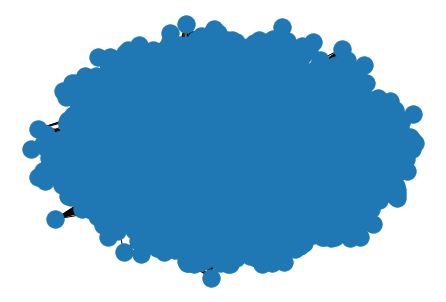

In [27]:

#图
bg_graph=nx.MultiGraph()

if result:

    # 主题词抽取
    for x in result:
        title=x[1]
        #print ("title:",title)
        abs=x[2]
        #print (abs)
        abs_title=abs+title
        keyw=str(x[3])
        keyw = keyw.split(';')
        abs_title=abs_title.replace(' ', '').strip()
        _sentences=abs.replace(' ','').strip()

        if _sentences.find('。')!=-1:
            abs_sentences=_sentences.split('。')
        elif _sentences.find('.')!=-1:
            abs_sentences=_sentences.split('.')
        else:
            abs_sentences.append(_sentences) 
        content=x[4]
       # print("               ")
       # print(content+"\n")
        kw=[]
        freq={}
        count_ky=0


        pos = True
        seg_list = seg_to_list(abs_title, pos)
        filter_list = word_filter(seg_list, pos)
        keywords=topic_extract(filter_list, 'LDA', pos)

        #add keywords as nodes
        bg_graph.add_nodes_from(keywords)
        weight=0
        for i in range(0,len(keywords)):
            node1=keywords[i]
            for j in range(i+1,len(keywords)): 
                node2=keywords[j]
                if  node1!=node2:
#                     所有的共现关系边权重 暂设为1    
#                         node_dict[node2]=1
                    count_node1=0 #关键词1出现的句子数
                    count_node2=0 #关键词2出现的句子数
                    count_node1_node2=1 #关键词1和2共现的句子数
                    for s in abs_sentences:
                            if node1 in s:
                                  count_node1+=1
                            if node2 in s:
                                  count_node2+=1
                            if node1 in s and node2 in s :
                                  count_node1_node2+=1

                    if node1 in title and node2 in title:
                              count_title=2

                    else:
                              count_title=1

                    if node1 in title:
                              count_node1+=1

                    if node2 in title:
                            count_node2+=1

                    if (count_node1+count_node2)!=0:    
                        weight=float(2*count_title*count_node1_node2*math.log(1.72+len(abs_sentences)+1))/float(count_node1+count_node2)

                    else:
                        weight=0
                        print("error")                        
                #bbg_edges=list(bg_graph.edges())
                if bg_graph.has_edge(node1,node2):
                    bg_graph[node1][node2][0]['weight']+=weight
                else:
                    bg_graph.add_edge(node1,node2,weight=weight)
        """     
        print(bg_graph.number_of_nodes())
        print(bg_graph.number_of_edges()) 
        print(bg_graph.nodes)
        for (u, v, wt) in bg_graph.edges.data('weight'):
               print('(%s, %s, %.3f)' % (u, v, wt))
        """
print(bg_graph.number_of_nodes())
print(bg_graph.number_of_edges()) 
#print(bg_graph.edges)
nx.draw(bg_graph)
plt.show()    

            
            
            

          

In [55]:
try:
    # 创建连接
    conn = pymysql.connect(host='116.56.143.162',
                           port=3306,
                           user='student',
                           passwd='student',
                           db='intelligentService',
                           charset='utf8',
                           use_unicode=True, )
    # 创建游标
    cursor = conn.cursor()
    search_subject=[]
    sql="select DISTINCT(subject1) from subject_relationship_base_reference "
    cursor.execute(sql)
    res1=list(cursor.fetchall())
    result_all=[]
    count=0
    sql_keys=""
    for x in res1:
        search_subject.append(x[0])
        if x[0]=='EM':
            count+=1 
            continue
        if(count==len(res1)-1):
            sql_keys+=" keywords like '%"+x[0]+"%'"
        else:
            sql_keys+=" keywords like '%"+x[0]+"%' or "
        count+=1
#          keywords="机器学习"
#             keywords=x[0]
    sql_top2 = "select id,title,abstract,keywords,content,paper_type from pdf2text where pdf2text.id in (select max(id) from pdf2text GROUP BY pdf2text.title)  and  ( "
    sql_bottom2=" ) and length(title)<> CHARACTER_LENGTH(title) and length(abstract)<> CHARACTER_LENGTH(abstract) and length(keywords)<> CHARACTER_LENGTH(keywords) and date is not NULL  order by date limit 1981,10000"
    sql2=sql_top2+sql_keys+sql_bottom2
    print("sql",sql2)
    cursor.execute(sql2)
    result2 = list(cursor.fetchall())
    n2=len(result2)
#      print ("2222",n)
#         result_all+=result
#         m=len(result_all)
#         print ("3333",m)
#         # 关闭游标
    cursor.close()
except Exception as e:
    print(e)

sql select id,title,abstract,keywords,content,paper_type from pdf2text where pdf2text.id in (select max(id) from pdf2text GROUP BY pdf2text.title)  and  (  keywords like '%神经网络%' or  keywords like '%决策树%' or  keywords like '%机器学习%' or  keywords like '%卷积神经网络%' or  keywords like '%深度神经网络%' or  keywords like '%Bagging%' or  keywords like '%集成学习%' or  keywords like '%随机森林%' or  keywords like '%迁移学习%' or  keywords like '%贝叶斯%' or  keywords like '%AdaBoost%' or  keywords like '%Boosting%' or  keywords like '%k近邻%' or  keywords like '%聚类%' or  keywords like '%隐马尔可夫%' or  keywords like '%强化学习%' or  keywords like '%支持向量机%' or  keywords like '%LSTM%' or  keywords like '%循环神经网络%' or  keywords like '%条件随机场%' or  keywords like '%贝叶斯网%' or  keywords like '%CART%' or  keywords like '%ID3%' or  keywords like '%k-means%' or  keywords like '%划分聚类%' or  keywords like '%特征选择%' or  keywords like '%C4.5%' or  keywords like '%GBDT%' or  keywords like '%核函数%' or  keywords like '%非线性支持向量机%' ) and length(title

In [56]:
bg_graph.number_of_nodes()

4058

In [ ]:
import csv
import os

if result2:
    
    paper_graph=nx.MultiGraph()  #单篇论文图
    feature_list=[]
    paper_list=[]
    pid=0
    for x in result2:
        pid+=1
        # 主题词抽取
        title=x[1]

        #print ("title:",title)
        abs=x[2]
        #print (abs)
        paper_list.append([pid,title,abs])
        abs_title=abs+title
        keyw=str(x[3])
        keyw = keyw.split(';')
        abs_title=abs_title.replace(' ', '').strip()
        _sentences=abs.replace(' ','').strip()

        if _sentences.find('。')!=-1:
            abs_sentences=_sentences.split('。')
        elif _sentences.find('.')!=-1:
            abs_sentences=_sentences.split('.')
        else:
            abs_sentences.append(_sentences) 
            
        content=x[4]

        pos = True
        seg_list = seg_to_list(abs_title, pos)
        filter_list = word_filter(seg_list, pos)
        keywords=topic_extract(filter_list, 'LDA', pos)
        
        #初始化，构建单篇论文图
        paper_graph.clear()
        #领域内所有论文图
        ps_graph=bg_graph.copy()   
        #add keywords as nodes
        paper_graph.add_nodes_from(keywords)
        
        weight=0
        
        count_bg_edges=bg_graph.size() #背景边数
        count_bg_nodes=bg_graph.number_of_nodes()#背景结点数
        weights_bg_edges=bg_graph.size('weight') #背景边权重之和
        
        total_edges=0#总边数
        total_nodes=0#总结点数
        
        count_new_edges=0#新边的数量    
        weights_new_edges=0#新边权重之和
        
        count_add_bg_edges=0#添加的背景边数
        weights_add_bg_edges=0#添加的背景边的权重之和
        
        count_cnn_edges=0#连接边数
        weights_cnn_edges=0#连接边的权重之和
        
        count_rf_bg_edges=0 #增强的背景边
        weights_pre_rf_edges=0 #增强的背景边原来的权重
        
        weights_add_pre_rf_edges=0 #添加到增强背景边的权重之和
        
        weights_rf_bg_edges=0 #增强背景边的权重之和

        count_new_bg_edges=0 
        count_new_add_edges=0
        #21.**
        count_21_feature=0 
        
        #bg_nodes=list(bg_gragh.nodes())   #背景图中所有结点列表
        #bg_edges=list(bg_gragh.edges())   #背景图中所有边列表
        
        #遍历paperGraph    
        for i in range(0,len(keywords)):
            node1=keywords[i]
            for j in range(i+1,len(keywords)): 
                node2=keywords[j]
                if  node1!=node2:
#                     所有的共现关系边权重 暂设为1    
#                         node_dict[node2]=1
                    count_node1=0 #关键词1出现的句子数
                    count_node2=0 #关键词2出现的句子数
                    count_node1_node2=1 #关键词1和2共现的句子数
                    for s in abs_sentences:
                            if node1 in s:
                                  count_node1+=1
                            if node2 in s:
                                  count_node2+=1
                            if node1 in s and node2 in s :
                                  count_node1_node2+=1

                    if node1 in title and node2 in title:
                              count_title=2

                    else:
                              count_title=1

                    if node1 in title:
                              count_node1+=1

                    if node2 in title:
                            count_node2+=1

                    if (count_node1+count_node2)!=0:    
                        weight=float(2*count_title*count_node1_node2*math.log(1.72+len(abs_sentences)+1))/float(count_node1+count_node2)
                    else:
                        weight=0
                        print("error")
               
                paper_graph.add_edge(node1,node2,weight=weight)
                
                has_node1=bg_graph.has_node(node1)
                has_node2=bg_graph.has_node(node2)
                #新边
                if has_node1==False and has_node2==False:    
                    # 新边数量  
                    #f 1.
                    count_new_edges+=1 
                    # f 6.
                    #新边权重之和
                    weights_new_edges+=weight 
                    #加入背景图
                    ps_graph.add_edge(node1,node2,weight=weight)
                    
                #连接边
                if (has_node1==True and has_node2==False) or (has_node1==False and has_node2==True):
                    #连接边数量
                    #f 5.
                    count_cnn_edges+=1 
                    # f 8.
                    #连接边的权重之和
                    weights_cnn_edges+=weight 
                    # f 21.
                    if has_node1==True:
                        count_21_feature+=len(bg_graph.__getitem__(node1))
                    if has_node2==True:
                        count_21_feature+=len(bg_graph.__getitem__(node2))                 
                    
                    #加入背景图
                    ps_graph.add_edge(node1,node2,weight=weight)
                    
                #添加的背景边
                if has_node1 and has_node2  and bg_graph.has_edge(node1,node2)==False:
                    #添加的背景边数量  
                    #f 2
                    count_add_bg_edges+=1 
                    # f 7
                    #添加的背景边的权重之和
                    weights_add_bg_edges+=weight
                    #加入背景图
                    ps_graph.add_edge(node1,node2,weight=weight)
                                                                   
                #增强的背景边
                if has_node1 and has_node2  and bg_graph.has_edge(node1,node2):                                                         
                    pre_weight=bg_graph[node1][node2][0]['weight'] 
                   #增强的背景边数之和
                    count_rf_bg_edges+=1 
                    #增强的背景边原来的权重之和  
                    weights_pre_rf_edges+=pre_weight       
                    #增强的背景边的权重之和
                    weights_rf_bg_edges=weights_bg_edges+pre_weight+weight 
                    #添加到增强背景边的权重之和
                    weights_add_pre_rf_edges+=weight 
                    #加入背景图，修改背景边权重
                    ps_graph[node1][node2][0]['weight']+=weight

        total_nodes=ps_graph.number_of_nodes()#总节点数  
        total_edges=ps_graph.size() #总边数            
        #3.总边数-背景图边数
        feature3=total_edges-count_bg_edges
        #4.总结点数-背景图节点数
        feature4=total_nodes-count_bg_nodes 
        #9.**
        feature9=float(total_nodes)/float(total_edges)-float(count_bg_nodes)/float(count_bg_edges) 
        #10.**
        feature10=float(total_nodes)/float(count_bg_nodes)-float(total_edges)/float(count_bg_edges) 
        #11.新边的数量和增加的背景边的数量之间的比率
        try:
            feature11=float(count_new_edges)/float(count_add_bg_edges) 
        except Exception as e:
            feature11=0
        #12.新边的数量和连接边的数量之间的比率
        try:
            feature12=float(count_new_edges)/float(count_cnn_edges) 
        except Exception as e:
            feature12=0
        #13.连接边的数量和增加的背景边的数量之间的比率
        try:
            feature13=float(count_cnn_edges)/float(count_add_bg_edges) 
        except Exception as e:
            feature13=0
        #14.新边的权重之和和增强的背景边权重之和之间的比率
        try:
            feature14=float(weights_new_edges)/float(weights_add_bg_edges) 
        except Exception as e:
            feature14=0
        #15.新边的权重之和和连接边权重之和之间的比率
        try:
            feature15=float(weights_new_edges)/float(weights_cnn_edges) 
        except Exception as e:
            feature15=0
        #16.连接边权重之和和添加背景边权重之和之间的比率
        try:
            feature16=float(weights_cnn_edges)/float(weights_add_bg_edges) 
        except Exception as e:
            feature16=0

        #17.添加的背景边权重之和与原有背景边权重之和之间的比率
        try:
            feature17=float(weights_add_bg_edges)/float(weights_bg_edges) 
        except Exception as e:
            feature17=0
        #18. 新边权重之和与背景边权重和之间的比率
        try:
            feature18=float(weights_new_edges)/float(weights_bg_edges) 
        except Exception as e:
            feature18=0
        #19.添加到增强背景边的权重之和与背景边权重之和之间的比率
        try:
            feature19=float(weights_add_pre_rf_edges)/float(weights_bg_edges) 
        except Exception as e:
            feature19=0
        #20.添加的背景边数与增强的背景边数之比
        try:
            feature20=float(count_add_bg_edges)/float(count_rf_bg_edges) 
        except Exception as e:
            feature20=0
#                 print(e)      

        #论文图推入背景图                            
        bg_graph=ps_graph.copy()
        """
        print("total",total_nodes,total_edges)
        print("background",count_bg_nodes,count_bg_edges)
        print("new",count_new_edges,weights_new_edges)
        print("add",count_add_bg_edges,weights_add_bg_edges)
        print("cnn",count_cnn_edges,weights_cnn_edges)
        print("reinforced",count_rf_bg_edges)
        print("21th",count_21_feature)
        """
        
        feature_list.append([pid,count_new_edges,count_add_bg_edges,feature3,feature4,count_cnn_edges,weights_new_edges,weights_add_bg_edges,weights_cnn_edges,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,count_21_feature])
        


                                                 

            
                                                 
                                                 
                                                
            
            
                

故障诊断/ 关联规则/ 诊断模型/ 无线传感器网络/ 采集/ 部署/ 挖掘/ 节点/ 比较/ C4.5算法/ 故障/ 农业/ 环境/ 方法/ 数据/ 能够/ 模型/ 识别/ 进行/ 建立/ 
凸函数/ 由此/ 性质/ 信息增益/ 阐述/ ID3算法/ 不足/ 计算效率/ 原理/ 改进/ 特点/ 研究/ 决策树/ 简化/ 存在/ 思想/ 计算/ 提高/ 利用/ 
数据仓库/ C4.5算法/ 管理/ 有用/ 面向/ 模型构建/ 指标/ 考核/ 科学/ 改进/ 定义/ 部门/ 挖掘/ 准确/ 应用/ 分析/ 确定/ 信息/ 系统/ 提出/ 
管理/ 图像标注/ 上海/ 检索/ 挑战性/ 遇到/ 关键词/ Internet/ 目标/ 海量/ 每幅/ 综述/ 主题模型/ 标注/ 常用/ 上下文/ 包括/ 辅助/ 相关/ 相对/ 
凸函数/ 原算法/ 信息熵/ 决策树分类/ ID3算法/ 简化/ 有所提高/ 构造/ 分裂/ 情况/ 重要性/ 具体/ 取值/ 数量/ 公式/ 反映/ 选择/ 参数/ 选取/ 介绍/ 
初始化/ 致使/ 随机/ 文本聚类/ 明显提高/ 概率/ 初始值/ 用以/ 聚类算法/ 归一化/ EM/ 互信息/ 过分/ 过度/ 准确度/ 实验验证/ 分析模型/ 文本/ 训练/ 聚类/ 
优越性/ 金字塔/ 图像去噪/ 细节/ 滤波器/ 隐马尔可夫/ 去噪/ 相关性/ 边缘/ 系数/ 图像/ 保持/ 双树/ 较好/ 对比/ 特点/ 仿真/ 验证/ 方向/ 统计/ 
文本挖掘/ 百分点/ 内容/ 噪声/ 海量/ means/ 召回率/ 文本/ 积累/ 文档/ 高出/ medoids/ 性能/ 鲁棒/ 后者/ 异常/ 聚类算法/ 指标/ 两类/ 中数/ 
完整/ 服务/ 展示/ 高校/ 剪枝/ 学院/ 图书馆/ 数据挖掘/ 完成/ 规则/ 数据采集/ 生成/ 最终/ 结论/ 预处理/ 分类/ 评价/ 研究/ 设计/ 得出/ 
训练集/ 相比/ AP/ 聚类算法/ SVM分类器/ 小样/ 分类精度/ 融合/ 高质量/ 混合/ 支持向量机/ 设计/ 预测/ 优化/ 得到/ 实验/ 分类器/ 应用/ 传统/ 数据集/ 
图像标注/ 多样性/ 完整/ 训练集/ 集成/ 成员/ 每个/ 很好/ 集成学习/ 属性/ 所有/ 贝叶斯/ 分类/ 分类器/ 构造/ 之间/ 自动/ 针对

In [ ]:
 #存至featrue.csv
with open('featrue.csv','w',newline='') as f:
    writer=csv.writer(f)
    writer.writerows(feature_list)
    f.close()
 

In [ ]:
 #存至featrue.csv
with open('paper_info.csv','w',newline='') as f:
    writer=csv.writer(f)
    writer.writerows(paper_list)
    f.close()

In [52]:
with open('featrue.csv') as csvfile:
    csv_reader = csv.reader(csvfile)  # 使用csv.reader读取csvfile中的文件
    for row in csv_reader:  # 将csv 文件中的数据保存到birth_data中
        print(row)

['0', '0', '0', '0', '0', '0', '0', '0', '0.0', '0.0', '0', '0', '0', '0', '0', '0', '0.0', '0.0', '0.00047725305188627134', '0.0', '0']
['0', '0', '0', '0', '0', '0', '0', '0', '0.0', '0.0', '0', '0', '0', '0', '0', '0', '0.0', '0.0', '0.000530580159778838', '0.0', '0']
['0', '8', '8', '0', '0', '0', '24.82894079355942', '0', '-4.3066870597692486e-07', '-2.9138484288981914e-05', '0.0', '0', '0.0', '0.0', '0', '0.0', '2.80953003316616e-05', '0.0', '0.0005642472816608715', '0.04395604395604396', '0']


In [ ]:
#提取的21种图形特征作为自编码神经网络的输入特征






In [ ]:
#  将论文图加入至背景图
# 21种图形变化特征
count_bg_edges=bg_gragh.number_of_edges() #背景边数
count_bg_nodes=bg_gragh.number_of_nodes()#背景结点数
total_edges=0#总边数
total_nodes=0#总结点数
count_new_edges=0#新边的数量           
count_add_bg_edges=0#添加的背景边数
count_cnn_edges=0#连接边数
weights_new_edges=0#新边权重之和
weights_add_bg_edges=0#添加的背景边的权重之和
weights_cnn_edges=0#连接边的权重之和
count_rf_bg_edges=0 #增强的背景边
weights_pre_rf_edges=0 #增强的背景边原来的权重
weights_bg_edges=0 #背景边的权重
count_new_bg_edges=0 
count_new_add_edges=0

if result2:
    





In [ ]:
            
           # for keyword in topic_extract(filter_list, 'LDA', pos):
                #         所有的关键词（实体）权重暂设为1
               #freq[keyword]=1.0
                
            """
             for keyword,weight in extract_tags(abs_title,allowPOS=('ns', 'n', 'vn', 'v','eng','x'),withWeight=True):
                
                if keyword not in stopwords and len(keyword)>1:
                    #print('%s %s' % (keyword,weight))
#         所有的关键词（实体）权重设为1
                    freq[keyword]=1.0
                    count_ky+=1
#                     print("count_ky",count_ky)
                if count_ky>=20:
                    break           
            
          
# 采用前3000篇论文构建的背景图：
            if x == result[0]:
                try:
                   with open('backgroundGraphDict2.pkl','rb') as f:
                    backgroundGraph=pickle.load(f)
#                  背景图中的结点集合
                    backgroundDot=list(backgroundGraph.keys())
                except Exception as e:
                    backgroundGraph={}
                    backgroundDot=[]
                    print(e)
# 论文图 paperGraph,numpy;结点集合freq,dict;
            paperGraph={}
            paperDot=list(freq.keys())
            for i in range(0,len(freq)):
                node1=list(freq.keys())[i]
#                 邻接表
                node_dict={}
                for j in range(0,len(freq)):
                    node2=list(freq.keys())[j]
                    if node1!=node2:
#                     所有的共现关系边权重 暂设为1    
#                         node_dict[node2]=1
                          count_node1=0 #关键词1出现的句子数
                          count_node2=0 #关键词2出现的句子数
                          count_node1_node2=1 #关键词1和2共现的句子数
                          for s in abs_sentences:
                            if node1 in s:
                                  count_node1+=1
                            if node2 in s:
                                  count_node2+=1
                            if node1 in s and node2 in s :
                                  count_node1_node2+=1
                        
                          if node1 in title and node2 in title:
                                count_title=2
            
                          else:
                                  count_title=1
                          if node1 in title:
                                count_node1+=1
                    
                          if node2 in title:
                                count_node2+=1
                
                          if (count_node1+count_node2)!=0:    
                            node_dict[node2]=float(2*count_title*count_node1_node2*math.log(1.72+len(abs_sentences)+1))/float(count_node1+count_node2)
            
                          else:
                            node_dict[node2]=0
                            print("error")
                paperGraph[node1]=node_dict

        
#  将论文图加入至背景图
# 21种图形变化特征
            total_edges=0#总边数
            total_nodes=0#总结点数
            count_bg_edges=0 #背景边数
            count_bg_nodes=0#背景结点数
            count_new_edges=0#新边的数量           
            count_add_bg_edges=0#添加的背景边数
            count_cnn_edges=0#连接边数
            weights_new_edges=0#新边权重之和
            weights_add_bg_edges=0#添加的背景边的权重之和
            weights_cnn_edges=0#连接边的权重之和
            count_rf_bg_edges=0 #增强的背景边
            weights_pre_rf_edges=0 #增强的背景边原来的权重
            weights_bg_edges=0 #背景边的权重
            count_new_bg_edges=0 
            count_new_add_edges=0
            
#             计算
            count_bg_nodes=len(backgroundGraph) #背景图节点数
            for x in list(backgroundGraph.keys()):
                 count_bg_edges+=len(backgroundGraph[x]) #背景图边数
                 for y in list(backgroundGraph[x].keys()):
                        weights_bg_edges+=backgroundGraph[x][y] #背景边权重之和
#             count_bg_edges=
            for x in list(paperGraph.keys()):
                if x not in list(backgroundGraph.keys()):
                    backgroundDot.append(x)
                    backgroundGraph[x]=paperGraph[x]
                    for y in list(paperGraph[x].keys()):
                        if y not in backgroundDot:
                            count_new_edges+=1 #1.新边数
                            weights_new_edges+=paperGraph[x][y] #6.新边权重之和
                        else:
                            count_cnn_edges+=1 #5.连接边数
                            weights_cnn_edges+=paperGraph[x][y] #8.连接边权重之和
                            count_new_add_edges+=backgroundGraph[x][y] #21.从已连接到论文图的新结点的背景结点引出的背景边数
                        
                else:
                    for y in list(paperGraph[x].keys()):
                        try:
                            tmp=backgroundGraph[x][y]
                            backgroundGraph[x][y]=tmp+paperGraph[x][y]
                            count_rf_bg_edges+=1  #增强的背景边
                        except Exception as e:
                            backgroundGraph[x][y]=paperGraph[x][y]
                            count_add_bg_edges+=1 #2.添加的背景边
                            weights_add_bg_edges+=paperGraph[x][y] #7.添加的背景边权重之和
                
            total_nodes=len(backgroundGraph) #总节点数  
            for x in list(backgroundGraph.keys()):
                 total_edges+=len(backgroundGraph[x]) #总边数
#             print("total",total_nodes,total_edges)
#             print("background",count_bg_nodes,count_bg_edges)
#             print("new",count_new_edges,weights_new_edges)
#             print("add",count_add_bg_edges,weights_add_bg_edges)
#             print("cnn",count_cnn_edges,weights_cnn_edges)
#             print("reinforced",count_rf_bg_edges)
            feature4=total_nodes-count_bg_nodes #4.总结点数-背景图节点数
            feature3=total_edges-count_bg_edges #3.总边数-背景图边数
            feature9=float(total_nodes)/float(total_edges)-float(count_bg_nodes)/float(count_bg_edges) #9.**
            feature10=float(total_nodes)/float(count_bg_nodes)-float(total_edges)/float(count_bg_edges) #10.**
            try:
                feature11=float(count_new_edges)/float(count_add_bg_edges) #11.新边的数量和增加的背景边的数量之间的比率
            except Exception as e:
                feature11=0
#                 print(e)
            try:
                feature12=float(count_new_edges)/float(count_cnn_edges) #12.新边的数量和连接边的数量之间的比率
            except Exception as e:
                feature12=0
#                 print(e)
            try:
                feature13=float(count_cnn_edges)/float(count_add_bg_edges) #13.连接边的数量和增加的背景边的数量之间的比率
            except Exception as e:
                feature13=0
#                 print(e)
            try:
                feature14=float(weights_new_edges)/float(weights_add_bg_edges) #14.新边的权重之和和增强的背景边权重之和之间的比率
            except Exception as e:
                feature14=0
#                 print(e)
            try:
                feature15=float(weights_new_edges)/float(weights_cnn_edges) #15.新边的权重之和和连接边权重之和之间的比率
            except Exception as e:
                feature15=0
#                 print(e)
            try:
                feature16=float(weights_cnn_edges)/float(weights_add_bg_edges) #16.连接边权重之和和添加背景边权重之和之间的比率
            except Exception as e:
                feature16=0
#                 print(e)
            try:
                feature17=float(weights_new_edges)/float(weights_add_bg_edges) #17.新边的权重之和和连接边权重之和之间的比率
            except Exception as e:
                feature17=0
#                 print(e)
            try:
                feature18=float(weights_add_bg_edges)/float(weights_bg_edges) #18. ??
            except Exception as e:
                feature18=0
#                 print(e)
            try:
                feature19=float(weights_new_edges)/float(weights_bg_edges) #19.新边权重之和和背景边权重之和
            except Exception as e:
                feature19=0
#                 print(e)
            try:
                feature20=float(count_add_bg_edges)/float(count_rf_bg_edges) #20.添加的背景边数与增强的背景边数之比
            except Exception as e:
                feature20=0
#                 print(e)
#             feature21=float()


  """


"""
            w1=w2=w3=w4=w5=w6=w7=w8=w9=w10=w11=w12=w13=w14=w15=w16=w17=w18=w19=w20=w21=1.0/21.0
            total_feature=w1*count_new_edges+w2*count_add_bg_edges+w3*feature3+w4*feature4+w5*count_cnn_edges
            total_feature+=w6*weights_new_edges+w7*weights_add_bg_edges+w8*weights_cnn_edges+w9*feature9+w10*feature10+w11*feature11+w12*feature12
            total_feature+=w13*feature13+w14*feature14+w15*feature15+w16*feature16+w17*feature17+w18*feature18+w19*feature19+w20*feature20+w21*count_new_add_edges
#             print("####",total_feature)
            feature_values.append(total_feature)
            if total_feature==0:
                print("total",total_nodes,total_edges)
                print("background",count_bg_nodes,count_bg_edges)
                print("new",count_new_edges,weights_new_edges)
                print("add",count_add_bg_edges,weights_add_bg_edges)
                print("cnn",count_cnn_edges,weights_cnn_edges)
                print("reinforced",count_rf_bg_edges)
#             _tmp_dict[]
            paper_sets[title]=total_feature
            
    
    
    
    
    
        if feature_values:
            feature_values.sort()
            p=0.99
#             print ("********",len(feature_values))
            w=float((len(feature_values)-1)*p)
            i=int(w)
            j=float(w-i)
            res=(1-j)*feature_values[i]+j*feature_values[i+1]
            print(res)
            p2=0.01
            w2=float((len(feature_values)-1)*p2)
            i2=int(w2)
            j2=float(w2-i2)
            res2=(1-j2)*feature_values[i2]+j2*feature_values[i2+1]
        f=open('test.txt','w+')
        f2=open('test_low.txt','w+')
        f.write("total nodes: "+str(total_nodes)+" total edges: "+str(total_edges)+"\n")
        #     保存到数据库
        try:
            conn = pymysql.connect(host='127.0.0.1',
                                   port=3306,
                                   user='root',
                                   passwd='',
                                   db='dbdemo',
                                   charset='utf8',
                                   use_unicode=True, )
        
            for x in list(paper_sets.keys()):
                # 创建游标
                cursor = conn.cursor()

                cursor.execute("insert into novelty(title,year,features) values (%s,%s,%s)",[x,'2015',paper_sets[x]])
                conn.commit()
                cursor.close()
                if paper_sets[x]>=res:
                    print("*****",x,paper_sets[x])
                    novel_paper_sets[x]=paper_sets[x]
                    for w in result:
                        if x==w[1]:
                            f.write("title: "+x+" novelty: "+str(paper_sets[x])+'\n')
                            f.write(str(w[2])+'\n')
    #                         f.write('\n')

                if paper_sets[x]<=res2:
                    print("TTTTT",x,paper_sets[x])
                    unnovel_paper_sets[x]=paper_sets[x]
                    for w in result:
                        if x==w[1]:
                            f2.write("title: "+x+" novelty: "+str(paper_sets[x])+'\n')
                            f2.write(str(w[2])+'\n') 
    #                         f.write('\n')
            f.close()
            f2.close()
          
            
            tmp_count+=1
            print(tmp_count)
        except Exception as e:
#             print e
            conn.rollback()
        finally:
            conn.close()

#         print(backgroundGraph)
#         print (len(backgroundDot))
"""

In [51]:
feature9=float(total_nodes)/float(total_edges)-float(count_bg_nodes)/float(count_bg_edges)
#feature9=round(float(total_nodes)/float(total_edges)-float(count_bg_nodes)/float(count_bg_edges),6) 
print(round(feature9,7))

-4e-07


In [18]:
novelty()

sql select id,title,abstract,keywords,content,paper_type from pdf2text where pdf2text.id in (select max(id) from pdf2text GROUP BY pdf2text.title)  and  (  keywords like '%神经网络%' or  keywords like '%决策树%' or  keywords like '%机器学习%' or  keywords like '%卷积神经网络%' or  keywords like '%深度神经网络%' or  keywords like '%Bagging%' or  keywords like '%集成学习%' or  keywords like '%随机森林%' or  keywords like '%迁移学习%' or  keywords like '%贝叶斯%' or  keywords like '%AdaBoost%' or  keywords like '%Boosting%' or  keywords like '%k近邻%' or  keywords like '%聚类%' or  keywords like '%隐马尔可夫%' or  keywords like '%强化学习%' or  keywords like '%支持向量机%' or  keywords like '%LSTM%' or  keywords like '%循环神经网络%' or  keywords like '%条件随机场%' or  keywords like '%贝叶斯网%' or  keywords like '%CART%' or  keywords like '%ID3%' or  keywords like '%k-means%' or  keywords like '%划分聚类%' or  keywords like '%特征选择%' or  keywords like '%C4.5%' or  keywords like '%GBDT%' or  keywords like '%核函数%' or  keywords like '%非线性支持向量机%' ) and length(title

******************
title: 前向神经网络设计问题的回顾与探索
本文评述了近十几年来国内外对前向神经网络设计问题的研究情况在分析各种已有设计方法优缺点的基础上提出另一种新的解决前向神经网络设计问题的方法并给出几个非常典型的设计模拟例子以说明本文所提出方法的有效性和潜力。 
******************
title: 进化神经网络研究进展
进化神经网络是将进化算法应用于神经网络的构造学习而得到的神经网络具有很强的鲁棒适应性。综述了进化神经网络方法及其应用研究新进展对研究中出现的一些问题进行了讨论与展望。 
******************
title: 模糊神经网络在时间序列预测中的应用
文中提出了将模糊聚类与梯度算法相结合的一种改进的训练模糊神经网络的混合型算法模拟结果表明模糊神经网络可以成功地用于时间序列的预测模糊神经网络的训练速度与模拟精度都优于传统多层网络 
******************
title: 故障诊断的智能模型研究述评
故障诊断中的智能模型主要有以下四种基于规则的诊断基于实例的诊断模糊诊断和基于神经网络的诊断。本文从诊断知识获取诊断结论的可靠性主要指对异常类故障的诊断能力以及解释能力三方面对这四种智能诊断模型进行了分析和评述并对智能诊断研究的发展趋势和有待解决的问题进行了分析与探讨。 
******************
title: 包装机械神经网络专家系统故障诊断新方法
首先介绍了包装机械中的裹包机在生产中常出现的故障诊断技术的基本内容 ,然后指出了单纯基于数据处理的各种传统诊断方法和一般专家诊断方法的缺点 ,进而探讨神经网络专家系统故障诊断方法用于系统故障诊断的基本原理结构具有自学习等优越性 ,并概括介绍了包装机器人神经网络专家诊断系统以及它的功能特点及其模拟 
******************
title: 深部开采诱发的岩爆及其防治策略──综合集成智能系统研究
深部开采诱发的岩爆是极其复杂的受到许多因素的控制。本文应用智能岩石力学的思想提出了岩爆风险估计与防治策略确定的综合集成智能模型。采用面向对象的技术开发了一个综合集成系统。它利用专家系统和神经网络模型根据所获得的现场测试和监测资料综合进行岩爆风险估计。针对可能发生的岩爆烈度建议合理的防治措施。 
******************
ti

******************
title: 强化学习理论、算法及应用
强化学习 (reinforcementlearning)一词来自于行为心理学 ,这一理论把行为学习看成是反复试验的过程 ,从而把环境状态映射成相应的动作 .首先全面地介绍了强化学习理论的主要算法 ,即瞬时差分法Q 学习算法及自适应启发评价算法 然后介绍了强化学习的应用情况 最后讨论了强化学习目前所要研究的问题 
******************
title: 关于自动文摘系统中文摘句式的一种机器学习方法
自动文摘系统中一个关键的问题是找出能构成摘要的重点句子。找出这些句子的方法很多但用机器学习的方法却较少该文提出了一种关于文摘句式的自动学习方法。该方法以经过简单的预处理的若干语句为训练样本集以正例句为基点进行由底向上的泛化学习抽象出关于句式的一般概念形成句式规则集作为判断文中哪些语句可作为文摘句的有效手段。这是文摘系统实现的核心部分。 
******************
title: 关于统计学习理论与支持向量机
模式识别函数拟合及概率密度估计等都属于基于数据学习的问题,现有方法的重要基础是传统的统计学,前提是有足够多样本,当样本数目有限时难以取得理想的效果.统计学习理论(SLT)是由Vapnik等人提出的一种小样本统计理论,着重研究在小样本情况下的统计规律及学习方法性质.SLT为机器学习问题建立了一个较好的理论框架,也发展了一种新的通用学习算法支持向量机(SVM),能够较好的解决小样本学习问题.目前,SLT和SVM已成为国际上机器学习领域新的研究热点.本文是一篇综述,旨在介绍SLT和SVM的基本思想特点和研究发展现状,以引起国内学者的进一步关注 
******************
title: 人工神经网络系统硬件实现的研究进展
本文综述了人工神经网络系统硬件实现的研究进展和关键技术并对人工神经网络基本单元电路的实现在片学习神经网络系统的实现及权值的存储和修改方法作了分析,指出神经网络系统的硬件实现对神经网络的研究和发展及应用的重要性。 
******************
title: 基于神经网络的室外移动机器人前轮转向模型
针对室外移动机器人的行驶特点 ,将车体模型划分为前轮转向模型速度模型和位姿模型三个部分 .提出用模糊集合与神经网络相结合来建立车体前轮转向模型的方

******************
title: 查询与发现:数据挖掘技术分析
探讨了数据库应用重要技术-数据挖掘技术描述了数据查询的结构已有的各种方式及常用技术涵盖了大部分流行工具比如分类聚类概括。总结了目前使用的统计与机器学习方法和新的解决方案。 
******************
title: 数据挖掘中的决策树技术及其应用
数据挖掘作为一种发现大量数据中潜在信息的数据分析方法和技术 ,已经成为相关各界关注的热点。其中 ,决策树技术以其出色的数据分析效率直观易懂的结果展示等特点 ,倍受广大用户的青睐。文章首先对决策树技术进行较为详尽的探讨 ,然后利用 SASEM工具 ,对该技术在客户关系管理中的应用进行了初步尝试。 
******************
title: 神经网络及其在股市预测中的应用
将BP神经网络和RBF神经网络应用于股市综合指数预测 .预测结果表明 ,RBF网络计算量少 ,学习速度快 ,预测精度高 
******************
title: 基于视频的人脸验证
本文提出了一种基于视频的人脸验证方法 .采用立体视觉方法初步将人脸区域与背景分割开 ,再根据多关联模板匹配方法精确定位人脸 .对定位后的人脸区域抽取特征器官位置 ,再依此裁剪出人脸样本 .从视频流中收集人脸样本 ,训练支持向量机 (SVM)作为验证器 .实验表明该方法在复杂的现场环境下是有效的鲁棒的 . 
******************
title: 神经网络规则抽取
神经网络是一种黑箱模型其学习到的知识蕴涵在大量连接权中不仅影响了用户对利用神经计算技术构建智能系统的信心还阻碍了神经网络技术在数据挖掘领域的应用由于对神经网络规则抽取进行研究有助于解决上述问题因此该领域已成为机器学习和神经计算界的研究热点介绍了神经网络规则抽取研究的历史综述了国际研究现状对关于这方面研究的不同看法进行了讨论并指出该领域中一些值得进一步研究的内容 
******************
title: 神经网络集成
神经网络集成通过训练多个神经网络并将其结论进行合成 ,可以显著地提高学习系统的泛化能力 .它不仅有助于科学家对机器学习和神经计算的深入研究 ,还有助于普通工程技术人员利用神经网络技术来解决真实世界中的问题 .因此 ,它被视为一种有广阔应用前景的工程化神经计算技术 ,已经成为

******************
title: 基于新型的竞争型神经网络的Web日志挖掘
提出了一种基于竞争的自激励神经网络学习算法SIN ,该算法综合了自适应谐振理论和竞争型神经网络的特点 ,并在隐含层采用了Hebb学习规则 ,既能保证原有记忆不受影响 ,又能对新的信息加以记忆 ,同时又克服了ART网络对噪音敏感的缺点 ,学习速度快 ,分类性能好 ,具有在线学习的功能 将该算法应用于Web日志挖掘能够有效地剔除噪音 ,得到很好的用户聚类和页面聚类的结果 ,为网站的管理者设计个性化的商务网站提供了有效的决策依据 
******************
title: 一种适用于图像拼接的自适应模板匹配算法
在图像拼接中通常使用模板匹配方法进行图像配准,模板特征选取基准模板位置与大小选取在很大程度上影响图像配准的准确度和速度。根据人类观察事物的行为特点,该文基于局部边缘密度LED和模糊聚类算法定位出特征物体区域,并在此区域上构建基准模板,在匹配上具有更高的可靠性。在模板匹配中采用加权相似性度量的方法,提高相似性度量的可靠性。据此,提出了一种强壮的自适应模板匹配算法,在自动图像拼接中体现出很强的实用性。 
******************
title: 基于增量学习支持向量机的音频例子识别与检索
音频例子识别与检索的主要任务是构造一个良好的分类学习机 ,而在构造过程中 ,从含有冗余样本的训练库中选择最佳训练例子节省学习机的训练时间是构造分类机面临的一个挑战 ,尤其是对含有大样本训练库音频例子的识别 由于支持向量是支持向量机中的关键例子 ,提出了增量学习支持向量机训练算法 在这个算法中 ,训练样本被分成训练子库按批次进行训练 ,每次训练中 ,只保留支持向量 ,去除非支持向量 与普通和减量支持向量机对比的实验表明 ,算法在显著减少训练时间前提下 ,取得了良好的识别检索正确率 
******************
title: 基于神经网络和灰色理论的密闭鼓风炉透气性预测模型
以密闭鼓风炉熔炼过程为研究对象 ,采用自适应组合集成技术将神经网络NN和灰色理论有机结合的方法建立了密闭鼓风炉透气性预测模型。仿真和工业应用结果表明 所提出的模型能很好地实现密闭鼓风炉透气性的预测 ,并能使铅锌产量得到显著的提高。 
******************
title: RFRA算

******************
title: 支持向量机的训练算法
大量数据下支持向量机(SVM)的训练算法是SVM研究的一个重要方向和广大研究者关注的焦点。该文回顾了近几年来这一领域的研究情况。该文从分析SVM训练问题的实质和难点出发,结合目前一些主要的SVM训练方法及它们之间的联系,重点阐述当前最有代表性的一种算法序贯最小优化(SMO)算法及其改进算法。从中可以看到,包括SMO在内的分解算法通过求解一系列规模较小的子问题逐步逼近最优解,从而避免存储整个Hessian矩阵,是解决大规模SVM训练问题的主要方法。而工作集的选择对于分解算法的收敛与否和收敛速度至关重要。 
******************
title: 机器学习研究
由于Internet的使用,不分时间与地域地获得信息已成为现实,但是,如何有效利用这些信息,并使用这些信息提高生产率成为迫切需要解决的问题.机器学习是解决这类问题的有效方法之一.在此将对目前机器学习研究的主要趋势理论与技术以及存在的问题,根据作者的研究经验进行综述,以便引起研究者的注意. 
******************
title: 一种针对名义尺度变量的优化聚类算法
经典的聚类分析技术如系统聚类法和K-means等主要是处理间隔尺度的变量,而对于名义尺度变量则不适合。文章借鉴认知心理学和优化学习的思想,对名义尺度变量的聚类问题进行了研究,定义了名义尺度变量的距离度量翻转距离,在此基础上,提出了一种目标函数优化制导的聚类算法,并演示了对名义尺度变量进行聚类的过程。实验表明,我们的算法结果可以得到合理的解释。 
******************
title: 一种基于机器学习的垃圾邮件智能过滤方法
为了更好的进行垃圾邮件过滤 ,介绍了NaiveBayes (N B )算法 ,并结合N B 算法和垃圾邮件过滤对N B 算法作了一些改进。之后 ,详细介绍了N B 算法在垃圾邮件智能过滤中的应用和实现 ,同时给出了应用的评估算法和评估结果。实验结果显示 ,把N B 算法应用到垃圾邮件过滤中可以取得很好的效果 
******************
title: 入侵检测系统自适应的研究
首先阐述入侵检测系统自适应性重要作用,接着比较两类入侵检测系统自适应性,从机器学习角度提出基于数据挖掘自适应入侵检测系统框架,并对常用机器学

******************
title: 基于神经网络的增量式crawler重访频率研究
crawler是搜索引擎必备的核心组件 ,以何种频率对变化的Web页面进行重访是增量式crawler要解决的主要问题 .结合人工神经网络建立页面变化模型 ,由模型确定增量式crawler重访时间 ,同时分析模型在实践中的应用 ,提出一种应用方案 ,具有较好的自适应性 . 
******************
title: 集成学习:Boosting算法综述
Boosting是近年来机器学习领域中一种流行的用来提高学习精度的算法,本文首先以AdaBoost为例对Boosting算法进行简单的介绍,并对Boosting的各种不同理论分析进行概括,然后介绍了Boosting在回归问题中的理论研究,最后对Boosting的应用以及未来的研究方向进行了讨论。 
******************
title: 一种使用属性表的快速概念聚类算法
形式概念分析是一种用于概念聚类的无监督机器学习技术,在数据挖掘信息检索等很多领域中得到了应用.将概念搜索空间重新组织成一棵前缀树,并构造了一张属性表,利用表中保存的数据对前缀树进行剪枝,使概念聚类的过程仅在一些有效的子空间中执行,进而提出了一种使用属性表的快速概念聚类算法.实验结果表明,该算法在稠密和稀疏的形式背景下均优于NextClosure算法. 
******************
title: 基于Boosting方法的人脸检测
该文提出一种基于Boosting方法的人脸检测算法。先用特征脸方法构造一个基于重建图像信噪比的阈值函数用于人脸检测,在此基础上,该文利用Boosting方法构造一个基于信噪比阈值的检测函数序列,然后以一定的方式将它们组合成一个总检测函数,据此判别一幅图像是否为人脸图像。实验结果显示,这种方法明显提高了检测性能。 
******************
title: 自学习在智能教学系统中的应用
采用信息论作为指导 ,对传统的CLS决策树学习算法进行改进 ,控制了决策树的大小。然后 ,根据学生认知水平的不同 ,将该算法运用于智能教学系统来建立决策树 ,指导教学方法的不断调整 ,达到因材施教的目的。 
******************
title: 基于正反馈的支持向量机
在分析现有的基于高斯核的支

******************
title: 基于聚类汇总的记录匹配算法
记录匹配算法在异构数据的集成和数据开采等领域应用广泛 ,其主要任务是找出来自不同数据源中代表同一对象实体的记录 ,这些记录具备相似的属性和属性值。为避免组合爆炸问题 ,现有的记录匹配算法不再对数据库中的记录数两两匹配 ,而是结合排序策略和静态聚类匹配方法实现 ,但这种静态方法不适应数据的动态变化。因此 ,本文提出基于聚类汇总的记录匹配算法 ,该算法可以解决静态方法导致的匹配记录丢失问题 ,同时能够减少计算量 ,提高匹配记录搜索效率。 
******************
title: 基于RBF神经网络的属性约简方法
提出了一种用径向基函数(Radial Basis Function)神经网络进行属性约简的方法定义了影响度等概念来量化评价各属性与待求解问题关系的紧密程度根据影响度对属性做出约简处理。实验表明该方法是合理有效的明显地提高了机器学习的性能。 
******************
title: 基于因素分析的复合神经网络及其在软测量中的应用
针对工业生产中 ,众多因素对生产影响程度不同的特点 ,提出了一种基于因素分析的复合神经网络 (FA MNN)模型 .介绍了FA MNN模型的结构 ,改进了神经网络的学习算法 ,并将其应用于氧化铝高压溶出过程中苛性比值及溶出率的软测量 ,利用现场实际运行数据进行仿真 ,结果表明FA MNN模型能有效实现苛性比值及溶出率的在线检测 
******************
title: 基于新型联想记忆神经网络的非线性系统辨识
Hopfield网络模型具有联想存储器功能,但对系统辨识不适用。具有动态记忆功能的Elman神经网络的泛化能力比较低。该文提出了一种新型联想记忆神经网络结构和学习算法,通过引入联想记忆衰减因子,提高了对非线性系统的辨识能力。通过与Elman动态神经网络辨识方法的仿真比较,说明联想记忆神经网络辨识方法具有很好的动态辨识能力和泛化能力。 
******************
title: 用适应度-距离选择机制遗传算法识别油气层
为提高遗传算法种群的多样性,在选择父辈串的时候通过综合考虑适应度值与彼此之间的海明距离确定选择机制,提出了基于适应度-距离(FDFitness-Distance)选择机制的遗传算法(GAGene

******************
title: 一种新的Bayes网络条件概率学习方法
针对大规模Bayes网络的条件概率赋值问题,提出一种学习方法.首先使用类层次结构定义一种新的基于层次的Bayes网络模型,用于表示大规模Bayes网络.然后将训练数据集由单个数据表的形式转化成多表数据库,其中每个数据库表对应一个Bayes网络模块.在此基础上导出条件概率计算公式,从每个数据库表中算出相应的Bayes网络模块的条件概率表,由此实现对整个层次Bayes网络的概率赋值.通过适当增加数据库表的数目来控制每个表中属性的个数,保证计算的可行性.将层次Bayes网络及计算公式用于解决图像中文本的自动检测与定位问题,实验结果表明了它们的有效性. 
******************
title: 单路口交通信号智能控制方法
应用模糊理论和机器学习方法,通过对到达车辆数目的模糊分类,将不同车辆数目到达情况下的信号控制决策方案以规则集的形式存储在知识库中,在交通信号控制过程中使用遗传算法对规则集进行改进.经过仿真实验,对该方法的控制效果与定时控制和感应控制进行了模拟比较,仿真实验的结果说明该方法的控制效果明显优于传统控制方式. 
******************
title: 边缘信息指导下的半模糊聚类图像分割方法
提出了一种利用边缘信息的半模糊均值聚类的图像分割算法,它先用边缘检测和区域生长算法对图像进行一次预分割,确定聚类的初始参数,然后在这个基础上对“边缘”部分的点采用模糊聚类非“边缘”部分使用分明聚类,避免了模糊聚类时初始参数设定的盲目性,减少了迭代时的计算量,提高了迭代收敛速度.除灰度特征外,聚类时还利用了点到类的距离特征,较好地保持了分割图像的连续性.直接观察对比多幅图像的分割实验结果可以明显地发现,该算法较常用的Otsu方法二维熵阈值分割方法以及FCM方法的分割结果更准确.就Lena图像而言,该算法的收敛速度也比一般的FCM快了将近一倍. 
******************
title: 人工神经网络知识增殖性分析
人工神经网络的知识增殖能力是该领域的热点和难点问题 ,具有重要的理论和实践意义 对人工神经网络的知识增殖性问题进行了较深入的探讨 ,从网络推广能力的角度分析了具有知识增殖能力的神经网络系统的结构设计问题 ,指出将多个网络个体结合在一起是实现人工

******************
title: 基于强泛化神经网络的大规模基因表达数据分析
DNA微阵列技术使人们可同时观测成千上万个基因的表达水平,对其数据的分析已成为生物信息学研究的焦点。针对微阵列基因表达数据维数高样本小非线性的特点,设计并实现了一种基因表达数据分类识别方法,针对结肠数据集的实验表明其泛化效果有所增强。 
******************
title: 一种多神经网络气流干燥水份软测量模型
影响气流干燥的因素很多,使由单个神经网络构成的软测量模型极其复杂,鲁棒性差。针对这个问题,利用主元分析法对辅助变量进行降维,再用基于进化策略的K-means聚类对数据进行分类,每类数据训练一个子神经网络模型,最后用PCR方法将子模型连接作为整个网络的输出。利用这一思想得到了气流干燥水份软测量模型,并对其重要环节进行了介绍。利用现场实际运行数据进行仿真,结果表明模型能有效检测气流干燥后精矿的含水率。 
******************
title: 基于SVM的分类预测
简单介绍了SVM的理论背景,详细介绍了基于SVM的分类预测方法,给出了基于SVM的分类预测技术的性能测试结果。指出该分类预测技术可将实际问题通过非线性变换转换到高维的特征空间,在高维空间中构造线性辨别函数来实现原空间中非线性辨别函数。 
******************
title: 一种有效的并行高维聚类算法
针对CLQUE算法聚类结果精确性不高的缺点,提出利用小波变换来生成自适应网格的方法对CLIQUE算法进行改进,将改进算法并行化以增强聚类维数升高时算法的可伸缩性,并将其应用于药品的销售预测。实验表明本算法聚类结果的精确性高,可伸缩性好,并且有效地降低了计算复杂度。 
******************
title: 基于神经网络的高效音频数据压缩方案
介绍了BP神经网络的基本原理和算法,并通过构造特殊的映射关系,精心设计的BP神经网络,获得一套基于神经网络的高效无损音频数据压缩方案。通过试验证明该方案行之有效,并且压缩比为71。 
******************
title: 一种基于自组织分级聚类的数据挖掘方法
针对传统自组织聚类方法处理数据在多维空间中存在多样性和从基本或低层次概念 上发现强关联规则中的不足,提出了一种基于自组织分级聚类的数据挖掘方法该方法采

title: 基于网络拓扑的网络安全事件宏观预警与响应分析
为及早发现并有效控制大规模爆发的网络安全事件的发生发展,本着主动测量和异常检测相结合的思路,设计实现了大规模网络安全事件协作预警系统,重点探讨了基于聚类算法的宏观预警分析控制点选择控制建议生成等关键技术,经可视化处理,取得了较好应用效果. 
******************
title: 一种基于贝叶斯测度的有监督离散化方法
传统的朴素贝叶斯不能处理连续属性,文中基于贝叶斯测度提出一种有监督离散化方法。它能够在无先验知识的前提下,自动寻求最佳的离散子区间数目和区间划分。在此基础上根据MDL准则控制离散化子区间的数目,使学习方法的精确度和复杂度达到均衡。在UCI机器学习数据集上对该方法进行了验证,取得了良好的效果。 
******************
title: 边坡角设计的支持向量机建模与精度影响因素研究
运用人工智能领域最新的基于结构风险最小化原理的机器学习算法支持向量机(SVM)算法,采用线性Linear 和径向基函数 RBF 两种核函数以及 不敏感和 Quadratic 两种损失函数,并且考虑惩罚参数 C 的不同,编写了相应的程序对影响边坡角设计的诸多因素进行了机器学习,经过反复调整相关参数和计算对比,找到了拟合精度很高的支持向量机网络,并以此网络对测试样本作预测检验模型的可靠性对影响支持向量机建模精度的各种影响因素作了计算和分析,在此基础上,初步确定了各参数对 SVM 模型精度影响大小的顺序,为 SVM 在类似工程上的应用提供了借鉴。 
******************
title: 基于Bagging的选择性聚类集成
使用集成学习技术来提高聚类性能.由于聚类使用的训练样本缺乏期望输出,与监督学习下的集成相比,在对个体学习器进行结合时更加困难.通过对不同的聚类结果进行配准,并基于互信息权进行个体学习器的选择,提出了基于Bagging的选择性聚类集成算法.实验表明,该算法能够有效地改善聚类结果. 
******************
title: 贝叶斯网络的简约模式表达
当现实问题域包含连续变量时,研究人员通常在建模前进行离散化预处理。文章将朴素贝叶斯的条件独立性假设进行推广以处理连续变量,在此基础上提出广义朴素贝叶斯学习方法(GNB)。该方法不仅能避免离散化引起的信息损失对判决精度

脸部表情的识别分类是一个非常复杂的问题,采用传统的方法很难取得满意的结果。为此,通过Gabor滤波器对人脸部图像进行滤波,提取滤波后图像的统计信息作为表情识别的特征信息,采用多分类器集成的方法对得到的神经网络输出向量进行线性加权集成得到最终的识别结果。实验结果表明了该方法的正确性。 
******************
title: 一种基于免疫原理的新优化遗传算法
将静态繁殖理论和机器学习原理引入到免疫遗传算法中,利用自适应疫苗,增强个体免疫力,以增加种群的平均适值,从而有效地避免了最优解的丢失,缩小了搜索空间,加快了进化速度,使系统能够在很短的时间内得到最优解。同时,针对典型车间调度问题,分别对改进算法和其他优化算法的计算结果进行了比较,表明改进算法更有效。 
******************
title: 基于贝叶斯网络的电信客户流失预测分析
电信客户流失分析常用的数据挖掘方法有自动聚类决策树和人工神经网络,它们是采用数据本身来训练模型的,没有利用先验知识。电信客户流失是由客户心理服务质量和对手竞争等诸多复杂的因素造成的,利用这些已有的先验知识,可以提高预测的精度。该文根据先验知识选取分析变量,采集样本数据,通过贝叶斯网络的结构学习和参数学习,建立客户流失模型并进行客户流失趋势预测,取得了比标准数据集更准确的结果,该结果和决策树方法的预测结果相比还具有较大的优势,说明贝叶斯网络是分析客户流失等不确定性问题的有效工具。 
******************
title: 基于神经网络的鲁棒自适应逆飞行控制
提出基于在线神经网络的超机动飞行自适应动态逆鲁棒控制方法.超机动飞行的基本控制律采用非线性动态逆方法设计,对于建模误差或者控制面损伤等因素导致的不确定性逆误差采用神经网络进行自适应补偿.通过动态逆控制律简化计算和飞机控制面故障自适应修复的仿真表明,神经网络通过在线补偿逆误差,能够有效降低非线性动态逆对模型准确性的要求,增强控制系统的鲁棒性. 
******************
title: 基因调控网络模型构建方法
基因调控网络的研究从基因之间相互作用的角度揭示复杂的生命现象,是功能基因组学研究的重要内容,也是当前生物信息学研究的前沿。基因芯片技术在生物信息学中的应用为基因调控网络的研究提供大量可供研究与分析的基础数据。本文介绍了基因调控网络的起源

******************
title: 一种设计层次支持向量机多类分类器的新方法
层次结构的设计是层次支持向量机多类分类方法应用中的关键问题,类间可分性是设计层次结构的重要依据,提出了一种基于线性支持向量机度量类间相似程度的方法,并给出了一种基于类间可分性设计层次支持向量机多类分类器的新方法。实验表明,新方法有效地提高了层次支持向量机多类分类器的分类精度和速度。 
******************
title: 基于无指导机器学习的全文词义自动标注方法
为实现汉语全文词义自动标注,本文采用了一种新的基于无指导机器学习策略的词义标注方法实验中建立了四个词义排歧模型,并对其测试结果进行了比较其中实验效果最优的词义排歧模型融合了两种无指导的机器学习策略,并借助依存文法分析手段对上下文特征词进行选择最终确定的词义标注方法可以使用大规模语料对模型进行训练,较好的解决了数据稀疏问题,并且该方法具有标注正确率高扩展性能好等优点,适合大规模文本的词义标注工作 
******************
title: 动态的模糊K-Modes初始化算法
模糊K-Modes聚类算法针对分类属性的数据进行聚类,使用爬山法来寻找最优解,因此该算法对初始值较为敏感。为了克服该缺点,提出一种动态的模糊K-Modes初始化算法,该方法能够自动确定聚类数目,以及对应的聚类中心而且能够应用于数值属性和分类属性相混合的数据集。该初始化算法可以有效地克服模糊K-Modes算法对初值的敏感性。实验的结果表明了该初始化算法的可行性和有效性。 
******************
title: 基于SVM的组块识别及其错误驱动学习方法
给出了一种错误驱动学习机制与SVM相结合的汉语组块识别方法。该方法在SVM组块识别的基础上,对SVM识别结果中的错误词语序列的词性组块标注信息等进行分析,获得候选校正规则集之后按照阈值条件对候选集进行筛选,得到最终的校正规则集最后应用该规则集对SVM的组块识别结果进行校正。实验结果表明,与单独采用SVM模型的组块识别相比,加入错误驱动学习方法后,组块识别的精确率召回率和F值均得到了提高。 
******************
title: 动态模糊机器学习模型及验证
根据学习系统中存在的动态模糊性,提出了动态模糊机器学习模型,给出了动态模糊机器学习算法和它的几何

******************
title: SVM及其在尿有形成分识别中的应用
对尿液显微图像中一些有形成分进行有效分类识别,具有重大临床意义。通过支持向量机(SVM)这种在训练样本数很少的情况下,能达到很好分类推广能力的学习算法,运用统计学习理论和支持向量机相关概念,将支持向量机引入尿显微图像有形成分识别中,采用数字图像处理技术对尿液有形成分显微图像进行目标特征提取。使用SVM分类的实验结果表明,在样本数不多情况下可获得很好分类效果。 
******************
title: CRM分析及获得潜在客户的算法研究
本文首先讨论了CRM的基本情况,包括相关思想一般模型和常见产品的分类情况其次针对现今热门讨论的分析型CRM,给出了一个获得潜在客户的算法,并对其进行了改进。 
******************
title: 基于支持向量机的小样本响应曲面法研究
当影响因素和响应输出的关系较为复杂时,应用传统响应曲面法(RSM)非参数响应曲面法(NPRSM)和人工神经网络(ANN)难以拟合真实的响应曲面,不仅需要大的样本量,而且泛化风险大,不易达到全局最优。将RSM归结为可有限制地主动获取样本的小样本机器学习问题,提出了一种基于支持向量机(SVM)的RSM。以大间隔网格取样,利用SVM拟合过程,对拟合方程寻优确定极值大致区域,再逐步缩小间隔求精。算例研究表明,该方法的拟合与泛化性能优于NPRSM和基于ANN的RSM,能在小样本条件下建立全局性数值模型,寻优可以得到多个极值。 
******************
title: 基于AdaBoost分类器的车牌字符识别算法研究
提出了一种基于模板匹配的改进AdaBoost算法的字符识别方法。针对AdaBoost算法的退化现象,根据样本在权重上的分布情况,对权重进行适当的调整,较好地解决了经典AdaBoost算法中存在的退化现象。最后给出了实验结果及实现方案。 
******************
title: 基于隐写工具的自相关特性进行音频隐写分析
基于对同一隐写工具在同一音频载体中嵌入不同加密数据时载体特征量的统计观察,发现隐写工具存在自相关性。由此,提出了一种采用支持向量机对音频信号及其线性预测误差的统计特征进行分类来检测音频隐写的新方法。这种方法不仅能可靠地确定音频文档中秘密信息的存在性,同

title: 模糊聚类在种群遗传分化分析中的应用
聚类分析是数据挖掘技术中的一种重要的分类方法,有着广泛的实际应用。现实的分类问题往往伴有模糊性,对具有相似关系的元素进行分类,需要将相似矩阵改造为等价矩阵。而要将相似矩阵改造为等价矩阵,只需要求相似矩阵的传递闭包。文章将模糊聚类分析传递闭包方法应用于生物种群遗传分化的研究,进行了实例分析,给出了模糊聚类分析传递闭包方法的实现过程和聚类分析结果。 
******************
title: 基于可信推断的流数据序列模式分析算法
序列模式在基因分析金融预测等方面有着重要的应用,是数据挖掘的一个主要分支.鉴于数据流应用的日益增多,本文在研究传统序列模式挖掘算法的基础上,提出了一种基于可扩展滑动窗口和贝叶斯概率过滤的面向数据流的序列模式挖掘算法(BM SP-DS算法),目的是简化序列模式发现的中间结果,提高挖掘效率,以便在小的存储空间和低的运算时间内快速发现流数据的频繁序列模式,同时算法也减少了因主观支持度取值不当对模式发现造成的负面影响.实验结果表明,该算法是可行较优的. 
******************
title: 基于SVM的中文文本自动分类研究
详细介绍了进行文本分类的过程,并着重介绍了一种新的基于结构风险最小化理论的分类算法支持向量机,通过实验比较支持向量机算法和传统的KNN算法应用于文本分类的效果,证实了支持向量机在处理文本分类问题上的优越性。 
******************
title: Web访问模式聚类中引入Web内容挖掘的方法
在用户访问模式的聚类过程中引入页面的相似性因子,从用户访问的主要内容和访问路径两个方面来度量访问模式的相似性,针对以往对这种集成研究忽略的问题进行深入的探讨,提出了有效的解决方法,合理地降低了聚类结果的类别数目,能更准确地发现一个网站的潜在用户类。 
******************
title: 利用遗传特征实现微生物基因序列聚类分析
文章提出了一种使用微生物遗传特征来进行基因序列聚类的方法。该方法首先从每条基因序列中划分出若干个等差长度的采样片断,然后利用各采样片断的遗传特征DNA(G+C)mol%值来作为基因序列聚类的依据。试验结果表明该方法是可行的,并且具有较好的聚类质量。 
******************
title: 分类方法的新发展

title: Kmeans与系统聚类法结合在脑电图中的应用
本文引入了系统聚类法和kmeans聚类法相结合对脑电图中某个时间段上的频率进行聚类的方法,由于待聚类的数据集的分布很难确定,因此采用系统聚类法往往效果不够理想,本文先用kmeans法测试聚成几类能得到较好的结果,然后设置系统聚类中类数目,试验表明能取得较好的结果。 
******************
title: 李群机器学习(LML)的学习子空间轨道生成格算法
给出了李群机器学习(LML)的学习子空间轨道生成格及相关的基本概念,包括李群机器学习中的样例数据集,轨道生成格理论及其算法,同时也给出了实例验证分析,并与决策树学习算法C4.5作比较,在分类的正确性方面优于C4.5算法,由此进一步证明了该理论的可行性以及算法的有效性。 
******************
title: 基于决策树数据挖掘的分析与应用
决策树技术是一种对海量数据集进行分类的非常有效方法。通过构造决策树模型,提取有价值的分类规则,帮助决策者做出准确的预测已经应用在很多领域。基于这种技术构造的蘑菇可食用性决策树模型,提供了通过蘑菇属性判别蘑菇可食用性的科学依据。决策树算法采用C4.5算法,它把信息增益率作为属性选择的度量标准。从实验结果来看,决策树模型虽然显示了一个很不平衡的结构,但得出了很容易理解的决策规则。 
******************
title: 基于特征加权的神经网络集成及其应用
泛化能力是机器学习关注的基本问题之一.特征加权是特征选择的更一般情况,它能更加细致地区分特征对结果影响的程度,往往能够获得比特征选择更好的或者至少相等的性能,已经成为普遍的提高学习器的泛化能力的方法之一.该文提出一种基于特征加权的神经网络集成方法FWEART,该方法通过自适应遗传算法的优胜劣汰机制为输入属性确定了特征权值,提高了集成中各个体Category ART网络的精度和差异度,从而提高了神经网络集成的泛化能力.在UCI标准数据集上验证了有效性后,FWEART被应用在地震序列类型预报上,取得了较好的预报效果. 
******************
title: FSL-SP的研究
在机器学习领域,特征选择对于提高学习机器的性能和效率具有重要意义,但是当前特征选择算法普遍存在着具体实现独立性强可扩展性差的问题,使得对多种算法性能的

******************
title: 机器学习算法在药物专利分类中的应用研究
为实现药物专利的自动分类,本文结合药物专利的特点,研究了机器学习算法如何应用于药物专利分类。将2000余份药物专利按疗效分类,选取其中五类作为训练样本,对每一类提取特征文本,利用向量空间模型将非结构化的文本数字化,用支持向量机Naive BayesRBFNetwork三种机器学习算法,分别测试专利样本的分类,使用5重交叉验证比较了三种算法的查准率(precision)和召回率(recall),结果表明支持向量机的分类效果最好。将机器学习算法应用于药物化学专利分类,有助于提高药物化学专利信息检索的效率。 
******************
title: C4.5算法在大豆致病性分析中的应用
介绍了一种决策树C4.5算法的构建方法及其步骤,并将决策树应用于大豆致病分析,由Weka系统实现后得到有一定实用价值的决策树。 
******************
title: 几种不同缺失值填充方法的比较
在数据挖掘和机器学习领域,缺失数据经常出现,本文从理论和实验两方面分析了常用的几种处理缺失数据的方法的优缺点。 
******************
title: 基于可疑实例影响度分析改进的C4.5 rules算法
决策树学习算法是数据挖掘中一类经典的分类算法。传统的决策树学习算法把数据集合中的实例同等对待,而忽略了实例之间存在的可疑性和影响度差异,导致错误实例扭曲了学习结果,严重影响学习质量。在此提出基于可疑实例影响度分析改进的C4.5 rules算法,在给定一个噪音集合后,首先把可疑实例与原集合划分开,并对可疑实例的影响度进行分析和度量,然后依据分类规则对可疑实例的覆盖情况进行重新排序和分类预测。算法在对分类规则重排序后将错误实例对学习结果的影响最小化,得出尽可能接近正确数据的学习结果。将此算法与经典的C4.5 rules算法进行实验比较,结果表明该算法有着良好的性能。 
******************
title: 基于支持向量学习机的HIV-1蛋白酶抑制剂的活性预测
为了预测人体免疫缺陷蛋白酶抑制剂的活性,计算了表征分子的组成和拓扑特征的462个分子描述符,用Kennard-Stone方法和随机方法进行了训练集和测试集设计,用Monte Carlo模拟退火方法进

******************
title: 基于动态贝叶斯网络的音视频连续语音识别和音素切分
构造了两个单流单音素的动态贝叶斯网络(DBN)模型,以实现基于音频和视频特征的连续语音识别,并在描述词和对应音素具体关系的基础上,实现对音素的时间切分。实验结果表明,在基于音频特征的识别率方面在低信噪比(015dB)时,DBN模型的识别率比HMM模型平均高12.79%而纯净语音下,基于DBN模型的音素时间切分结果和三音素HMM模型的切分结果很接近。对基于视频特征的语音识别,DBN模型的识别率比HMM识别率高2.47%。实验最后还分析了音视频数据音素时间切分的异步关系,为基于多流DBN模型的音视频连续语音识别和确定音频和视频的异步关系奠定了基础。 
******************
title: 基于相空间重构理论与递归神经网络相结合的股票短期预测方法
根据股票指数时间序列复杂的非线性特性,提出以相空间重构理论与递归神经网络相结合的股票短期预测新方法。以相空间重构理论确定最佳延迟时间和最小嵌入维数,以最佳延迟时间为间隔的最小嵌入维数作为递归神经网络的输入维数,并按预测相点步进递归的生成训练数据进行短期预测,提高了预测精度和稳定性。该方法应用于沪市股票综合指数预测,其结果与传统的单纯用BP网络模型预测的结果相比较,精度大大提高,证明了该预测模型和方法在实际时间序列预测领域的有效性和实用性。 
******************
title: 基于模糊控制补偿的支持向量机逆模型控制
支持向量机(SVM)具有很强的非线性逼近能力与泛化能力,文章研究了基于SVM的非线性系统逆模型辨识,并设计了基于模糊控制补偿的SVM逆控制系统。由SVM辨识的逆模型作为前馈控制器,形成直接逆模型控制器。同时,设计模糊控制器构成反馈补偿控制,克服逆模型的建模误差,提高系统鲁棒稳定性。仿真研究表明,SVM具有优良的逆模型辨识能力,基于模糊控制补偿的支持向量机逆控制系统的动态性能好跟踪精度高鲁棒稳定性强。 
******************
title: 基于专家系统的机器人规划综述
近年来,基于专家系统的机器人规划方法取得了很好的成果。本文在阅读了大量文献资料的基础上,对基于专家系统的机器人规划理论及其在不同层次的机器人规划中的应用做了一个比较全面的总结。重点论述了基于专家系统的机器人规

title: 基于内容的广告垃圾图像过滤方法的研究
垃圾制造者们为了避免垃圾过滤器的过滤,采用了很多变通的方法来制造垃圾,其中一种新型的垃圾邮件就是把文字转换为图像,通过图像来达到传递垃圾信息的目的,这种图像垃圾还存在若干变种,使之前的一些文本垃圾过滤器变得无能为力。本文提出了一种基于内容的广告垃圾图像过滤方法,在总结这些垃圾图像的颜色种类特征规律基础上,利用 K-means 算法进行颜色聚类,符合某种颜色种类特征规律的图像即被判定为垃圾图像,实验 
******************
title: 基于商空间的气象时间序列数据挖掘研究
论文从一种新的角度,针对气象时间序列的特点,在商空间粒度计算理论框架下,采用多种粒度,从不同的层次分析复杂的气象数据信息,利用商空间的合成技术,和多侧面递进算法进行综合信息处理。并提出了一种灰色模型GM(1,1)与构造性机器学习方法(交叉覆盖算法)结合的模型对气象时间序列进行数据挖掘(产量预测)。最后,通过该模型在真实数据上的实验(冬小麦产量预测),取得了令人满意的结果。 
******************
title: 大规模数据集聚类中的数据分区及应用研究
针对大型数据库提出了许多聚类方法,但是这些算法往往计算量较大对主存的要求较高而且当数据分布不均匀时,算法的聚类质量会受影响。因此为了提高聚类算法的效率和准确性,采用了数据分区技术首先对数据进行预处理,分区后的数据具有更少的数据量和更均匀的数据分布。 
******************
title: 使用机器学习方法进行新闻的情感自动分类
本文主要研究机器学习方法在新闻文本的情感分类中的应用,判断其是正面还是负面。我们利用朴素贝叶斯和最大熵方法进行新闻及评论语料的情感分类研究。实验表明,机器学习方法在基于情感的文本分类中也能取得不错的分类性能,最高准确率能达到90%。同时我们也发现,对于基于情感的文本分类,选择具有语义倾向的词汇作为特征项对否定词正确处理和采用二值作为特征项权重能提高分类的准确率。总之,基于情感的文本分类是一个更具挑战性的工作。 
******************
title: 基于支持向量机的说话人识别研究
解决说话人识别问题具有重要的理论价值和深远的实用意义,本文在研究支持向量机理论的基础上,采用支持向量机的分类算法实现说话人识别系统的训练和测

title: 基于数据挖掘的决策树方法分析
决策树方法因其简单直观准确率高等特点在数据挖掘及数据分析中得到了广泛的应用。在介绍了决策树方法的一般知识后,深入分析了决策树的生成算法与模型,并对决策树的剪枝过程进行了探讨。 
******************
title: 基于变量聚类和PCA的神经网络在碳分分解率预测中的应用研究
铝酸钠溶液的连续碳酸化分解末槽分解率直接影响着氧化铝的产量和质量,然而,分解过程具有多重大滞后严重非线性和变量间耦合等特点,使得末槽分解率控制困难。本文详细分析了连续碳酸化分解过程中,影响末槽分解率的各种因素,建立了基于变量聚类和一种改进的主成分分析(PCA)的神经网络末槽分解率预测模型。模型首先对影响末槽分解率的因素进行变量聚类和主成分分析,对所有影响因素进行分层构权重组,再将分析结果用于神经 
******************
title: 基于机器学习的动态信誉评估模型研究
为在开放网络环境中建立资源消费者(用户)和资源提供者(主机)之间的信任关系,提出基于机器学习的动态信誉评估模型.模型中用户的信誉级别可以根据其行为和一些其他监测数据动态变化,而资源的信誉级别也可以根据用户对资源所提供服务的评价动态变化.给出了用于生成评估规则和信誉级别的模糊信誉级别评估算法(FTEA),算法采用基于规则的机器学习方法,具有从大量输入数据中自学习以获取评估规则的能力.实验结果表明,1000组输入数据能够生成理想的规则库,并且算法执行时间随输入判定因素数目成指数形式增长,因此需要选择56个因素和1000个左右的样本数据以进行系统实现. 
******************
title: 支持产品设计的知识仓库框架研究
为满足产品快速定制设计过程对知识的配置组织获取和重用的要求,构建了基于知识仓库的知识管理框架。在对产品信息模型的定义基础上构建了由产品需求决策知识产品结构知识产品配置知识产品特征知识和产品设计资源组成的知识仓库知识结构,并且将机器学习中的决策树和加权聚类算法用于知识推理和设计决策过程中,将Web Service技术运用于异构CAD系统和知识仓库数据交换,实现了基于异构CAD平台的分布式知识共享和应用集成。 
******************
title: 基于FSVM层叠模型的中文命名实体识别
针对中文命名实体构成的复杂性,提

******************
title: 基于SVM的分类方法综述
本文介绍了文本分类的起源,常用的几类文本分类方法及基于SVM(Support Vector Machines)文本分类的基本原理和方法。并在分析文本分类的特点的基础上比较了在文本分类中应用SVM的优势及存在的问题。最后总结出了SVM在文本分类中应用的两个主要研究方向。 
******************
title: 基于梯度算法的支持向量机参数优化方法
首先介绍最近出现的参数优化方法,概括了高效率的参数优化算法应具备的若干特点.然后提出了一种新的支持向量机参数优化方法.该方法先在局域内用混沌优化搜索局域最优点,再将此最优点作为梯度方向,通过改变局域范围跳出局部寻优区域.该方法降低了对性能函数连续且可微的要求,收敛速度快,最终优化解与支持向量机的参数初始值无关.最后,通过仿真实验表明了该方法具有更高的分类和回归准确率. 
******************
title: 铜闪速熔炼过程操作模式的智能优化
提出了基于模式分解的铜闪速熔炼操作模式智能优化方法,描述需要在线决策的操作参数.从历史样本集中筛选优化的样本组成模式,采用基于聚类的方法进行模式分解,通过混沌遗传算法对每个模式子集寻求操作模式的优化.将该方法应用于铜闪速熔炼过程,提高了铜闪速的操作水平. 
******************
title: 不同种类支持向量机算法的比较研究
介绍一种新型的机器学习方法支持向量机.论述了不同种类支持向量机算法并指出了每种算法的优劣.实验结果显示了核函数中选择合适的参数对分类器的效果是很重要的,通过实验还重点比较了ChunkingSMO和SVM light三种典型分解算法,并分析了训练速度优劣的原因.文章最后给出了今后SVM研究方向的一些预见. 
******************
title: 贝叶斯网络模型概述
文章对贝叶斯网络分类模型进行了形式化的描述,重点介绍了构造贝叶斯网的三种不同的方式,最后总结了贝叶斯网络的优点。 
******************
title: 高维数据特征降维研究综述
特征降维能够有效地提高机器学习的效率,特征子集的搜索过程以及特征评价标准是特征降维的两个核心问题。综述国际上关于特征降维的研究成果,总结并提出了较完备的特征降维模型定义通过列举解决特

title: 关联关键因子联想自学习Bayes疾病确诊算法
为实现机器求解南方山羊疾病确诊问题,提出关联关键因子概念及其可信度联想算法,设计了适用于主观贝叶斯规则的加权联想推理和机器统计自学习方法。针对多规则激活情况,提出规则积分加权和集合求并的综合方法模拟人类专家会诊过程。实验结果表明,可信度联想方法提高了机器确诊符合率,综合方法合成多确诊结论,收到很好的诊断效果。 
******************
title: 基于聚类的人脸图像检索及相关反馈
提出了一种基于聚类的人脸图像检索算法。首先利用归一化分割(Normalized cuts,N Cuts)在每个时间段内分别对人脸聚类,使同一个人在不同情况下的人脸图像聚为一类.其次采用连续AdaBoost算法学习得到的人脸识别分类器度量人脸之间的相似度,并进一步提出查询人脸与人脸聚类之间的相似度用于检索.为了进一步提高性能,用户可以在线标定错检和漏检的结果,相关反馈环节把用户的交互标定结果作为约束条件重新对人脸聚类.本文把人脸图像检索算法应用于自动的检索系统中,在包含超过一千张人脸图像的家庭数码相册上,通过与其他方法的对比实验证明了基于聚类的人脸图像检索算法是有效的。 
******************
title: 直推式可信最邻近分类器在文本分类中的应用研究
直推式可信最邻近分类器是基于算法随机性理论提出的一种新的分类算法,它不仅能够判断样本的类别,还能够为每一个判断提供可信度,这对于分类机器的应用是很有意义的.但这种分类器需要将每一个待分类样本逐一在所有的类别中进行计算,使得计算量大大的增加.这一点对于多类别和大数据量的文本分类尤为明显.本文在深入研究该算法的基础上,对其利用聚类分析进行了改进,并将这一算法及其改进后的算法用在文本分类中.实验表明改进后的算法和原算法相比准确率相近,但在计算速度上提高了近40%. 
******************
title: 代价敏感支持向量机在入侵检测中的应用
入侵检测系统在最大化计算机安全性的同时,着手减小其代价也是关键点之一。标准的分类器设计一般基于精度,在入侵检测等实际应用问题中,不同的类别对应的错分代价也不同,在此类问题中直接使用标准分类方法就无法取得良好的分类和预测效果。代价敏感算法通过改变代价矩阵,可使高代价样本的错分率得到有效的控制,并尽量减少总体错

title: 基于改进互信息的特征提取的文本分类系统
文章提出并实现了一种改进互信息的特征提取和支持朴素贝叶斯的文本分类系统,改进的互信息算法加强了负值单词的互信息值,弥补了原来互信息预处理算法的不足,从而提高了分类精度.实验结果表明本算法和系统具有较高的分类准确率。 
******************
title: 半监督鲁棒联机聚类算法
将监督信息引入到聚类算法中去,在先前提出的鲁棒联机聚类算法(ROC)的基础上,通过引入以样本类标号形式给出的监督信息,提出了一种半监督的鲁棒联机聚类算法(Semi-ROC).在算法的聚类精度和鲁棒性能上,算法Semi-ROC比ROC和AddC有着更好的性能,在人工数据集和UCI标准数据集上的实验结果表明,Semi-ROC能有效地利用少量的监督信息来提高算法的聚类性能,得到较优的结果.另外,在添加噪声的情况下,算法Semi-ROC比原始的联机聚类算法AddC和ROC都更加鲁棒. 
******************
title: 基于文本最小相似度的中心选取方法
基于划分的聚类算法是一种局部最优算法。聚类初始中心的选择对该聚类算法的收敛速度和聚类的性能都有很大的影响。初始中心点应该选择来自不同的类并且初始中心点文本之间的相似度应尽量小,为此提出了一种新的基于最小相似度的中心选取方法,该方法选择相似度最小的两个样本分别作为初始的两个中心,然后依次选择到已知中心相似度最小的样本作为其他类的中心。实验表明该方法能够选出来自不同类的样本作为聚类的初始中心,同其他初始中心选择方法比较,聚类算法的性能有明显提高。 
******************
title: 基于动态贝叶斯网络的大词汇量连续语音识别和音素切分研究
提出一个新颖的单流多状态动态贝叶斯网络(Single stream Multi-states DynamicBayesian Network,SM-DBN)模型,以实现大词汇量连续语音识别和音素切分。该模型在Bilmes等人提出的单流动态贝叶斯网络(Single stream Dynamic Bayesian Network,Phone-shared,SS-DBN-P)模型(识别基元为词)基础上,增加了一个隐含的状态节点层,每个词由它的对应音素组成,而音素采用固定个数的状态描述,状态和观测向量直接连接。它的识别基元为音

title: Agent普适机器学习模型设计研究
从上世纪90年代Mark Weiser提出普适计算的透明化和不可见性两个特点开始,到2003年国际普适计算会议提出使用自身的信息来提高系统性能以后,普适计算开始向机器学习的方向发展。通过Agent的移动性和普适计算的随时随地性来实现机器学习为各行各业服务的普适功能,从而形成Agent普适机器学习基本内容。借助普适计算的基本性质,结合机器学习的特点,给出Agent普适机器学习设计方法。 
******************
title: 基于二次型规划的平面冗余机械臂的自运动
提出一种基于二次型性能指标的方法,用于规划平面冗余机械臂的自运动轨迹.鉴于实际的机械臂都存在关节物理约束,该自运动规划方案考虑了关节极限和关节速度极限的躲避.提出了基于线性变分不等式的原对偶神经网络,并将其作为所对应的二次型规划方案的实时求解器.仿真结果证实了该基于神经网络的自运动规划方案的有效性. 
******************
title: 基于用户聚类的电子商务推荐系统
协同过滤是推荐系统中采用最为广泛和成功的推荐技术,但随着电子商务系统用户数目和商品数目的增加,在整个用户空间上搜索目标用户的最近邻居的耗时也急剧增加,导致系统性能下降。提出了一种基于用户项目类偏好值矩阵聚类的合作推荐方法,解决了"冷开始"问题,并且由于只在目标用户所属类别中搜索其最近邻居,减少了搜索空间,有效地提高推荐系统的实时响应速度。 
******************
title: 一种基于Web的分类体系学习算法
领域分类结构的抽取已成为本体工程和本体学习的关键部分,提出一种新的分类结构学习算法,将Web作为知识获取的语料库,运用迭代方法抽取相关语言学模式,再利用语言学模式抽取分类结构,并采用改进的互信息方法对结果进行评价和过滤,最后通过实验对该分类学习算法的性能进行评价.实验表明算法具有良好的跨领域性,在准确率和召回率方面也有改善. 
******************
title: 小生境基因表达式编程在函数发现的研究
提出一种基于小生境的GEP改进算法,将改进k-均值的聚类分析与遗传机制相结合,通过调节最小聚类距离,控制收敛的小生境数目,以提高算法跳出局部最优的能力.将改进算法应用在函数发现问题中并与基本GEP算法结果进行对比,实验表明改进算法

title: 数据挖掘技术在ERP中的应用
数据挖掘是近几年迅速发展起来的技术,主要用于构建企业的决策支持系统。文章根据数据挖掘技术的特点,针对传统ERP系统在决策方面的不足,提出把数据挖掘应用到ERP中去,并结合A汽车公司的ERP系统的实施和运行情况,开展从该系统挖掘数据的可行性研究数据方法和流程探索,给出决策树挖掘算法检测数据挖掘模型。结果表明,这种数据挖掘是有效的。 
******************
title: 基于相关向量机的多类蛋白质折叠识别
蛋白质折叠的识别是一种不依赖于序列相似性的蛋白质结构研究方法.本文将相关向量机应用于蛋白质折叠的识别,将两类相关向量机推广到多分类情况,对多类蛋白质折叠进行识别.与支持向量机相比较,相关向量机无需调整多余的参数,核函数不需要满足mercer条件,实际数据集上的测试结果表明,相关向量机可以得到更加稀疏的模型,在交叉检验中获得了更高的精度,表明相关向量机是一种有效的识别蛋白质折叠的方法. 
******************
title: 基于Gabor小波和支持向量机的人脸识别
提出一种将Gabor小波和支持向量机相结合的人脸识别算法。运用AdaBoost算法在复杂背景图像中快速准确地检测出人脸部分,进而用Gabor小波提取归一化人脸图像的特征。最后采用支持向量机进行人脸的分类识别。在ORL人脸库和CAS-PEAL-R1人脸库中对算法进行了测试,结果表明该算法识别率较高。 
******************
title: 运动串:一种用于行为分割的运动捕获数据表示方法
运动数据的行为分割是运动捕获过程中非常重要的一环.针对现有分割方法的不足,提出了一种可用于行为分割的运动数据表示方法,并基于该表示实现了数据的行为分割.运动数据经过谱聚类(spectral clustering)时序恢复和最大值滤波法(max filtering)后生成一个字符串,该字符串称为运动串,然后采用后缀树(suffix tree)分析运动串,提取出所有静态子串和周期子串,对这些子串进行行为标注,从而实现运动数据的行为分割.实验表明,基于运动串的分割具有较好的鲁棒性和分割效果. 
******************
title: 基于认知几何的支持向量机分类
支持向量机(SVM)较好地解决了小样本分类问题,但仍然受稀疏数据和噪音的

******************
title: 基于免疫克隆选择算法的神经网络规则抽取
神经网络的不可解释性一直是限制其发展的固有缺陷,该文从神经网络的功能性观点出发,提出基于免疫克隆选择算法的神经网络规则抽取方法。将免疫克隆策略用于神经网络的规则抽取中,对已经训练好的神经网络隐层神经元输出值进行聚类,缩小搜索空间,抽取出理解性好简洁的符号规则。该方法不依赖于具体的网络结构和训练算法,可以方便地应用于各种分类器型神经网络。实验结果表明该方法的实用性和可行性。 
******************
title: 一种共调控基因聚类的新方法
定义了一种基于滑动匹配的相似度,并在此基础上提出一种能够自适应确定聚类数目的全局K-均值算法,解决了现有共调控基因聚类方法无法考虑到基因的正反延时部分时间和差异表达全部4种共调控关系的问题.将提出的算法应用于微阵列数据中,并将实验结果与CLUSTER 3.0算法进行了比较,验证了算法的可行性和有效性. 
******************
title: 一种机器学习型防火墙的设计与实现
Internet所具有的开放性国际性和自由性,以及TCPIP协议在制定时本身所具有的缺陷,使得网络安全问题日益严重。为了建立安全可靠的信息网络,进行网络安全技术的研究与设计是极其必要与迫切的。防火墙作为信息安全保障的重要措施已经应用在众多组织机构的网络中,但基于静态安全策略的防火墙无法及时响应实时的安全问题。文中在防火墙的智能化方面做一些有益的尝试,提出了新一代具有自主学习能力的防火墙系统结构。 
******************
title: 决策树方法在恶意DLL文件检测中的应用
本文对现有恶意DLL文件注入技术和PE结构进行了分析,提出了一种检测恶意DLL文件的新方法。通过分析DLL文件的文件属性和PE文件字段值,利用决策树方法中的C4.S算法构造恶意DLL文件检测模型,并且通过实验验证该检测模型的检测效率。 
******************
title: 对于未知非线性离散系统的支持向量机内模控制方法
该文对于未知非线性离散单输入单输出(SISO)系统提出了一种基于支持向量机的内模控制方法。整个控制律包括标称控制器与鲁棒控制器2部分,标称控制器是基于支持向量机-非线性自回归滑动平均(SVM-NARMA)模型用二次型最优性能指

******************
title: 蛋白质亚细胞定位预测的机器学习方法
蛋白质亚细胞定位与其功能密切相关。蛋白质在细胞中的正确定位是细胞系统高度有序运转的前提保障。研究细胞中蛋白质定位的机制和规律,预测蛋白质的亚细胞定位,对于了解蛋白质的性质和功能,了解蛋白质之间的相互作用,探索生命的规律和奥秘具有重要意义。基于机器学习方法的蛋白质亚细胞定位预测是生物信息学研究的热点之一。从数据集的建立蛋白质序列特征刻画和蛋白质亚细胞定位预测算法3个方面,总结和评述了在过去十几年里机器学习方法在蛋白质亚细胞定位研究中的应用情况和取得的成果,分析了机器学习方法在蛋白质亚细胞定位预测方面存在的问题和面临的挑战,指出了蛋白质亚细胞定位研究的主要方向。 
******************
title: 一种基于小波神经网络的车辆构架人工蛇行波重构方法研究
预测车桥系统的振动响应,减少工作人员去轨道实测列车蛇行波的工作量,关键在于求得与实际构架实测蛇行波接近的构架人工蛇行波。基于Monte-Carlo的人工蛇行波随机模拟方法只保留了实测数据中的方差作为重构的唯一约束条件,而其他一些重要特征参数,如频率概率等都没有得到充分的利用,造成重构过程中的频率和相位的机会均等,导致最后重构的蛇行波与实测蛇行波有一定的差距。本文针对小波良好的时频局部性及神经网络强大的非线性映射能力,用小波基代替神经网络中的Sigmoid函数,构造带有轮盘赌遗传选择机制的小波神经网络,并对列车运行速度为160kmh的广深铁路实测蛇行波数据进行分析重构。仿真结果表明这种方法能够有效地保留实测蛇行波的特征参数,重构的蛇行波过渡衔接更加自然。同时,该方法也适用于高速列车的蛇行波重构。 
******************
title: 基于主动轮廓技术的植物叶图像提取方法
叶是植物的重要特征信息,叶片图像提取是植物器官建模和生鲜植物识别的关键步骤。在植物自动识别和叶建模领域具有重要价值。笔者提出了一种基于主动轮廓技术和细胞神经网络的叶图像提取方法,实践表明基于细胞神经网络的可变模板技术实现了对植物叶片轮廓的灵活控制,同时结合了隐含模型和参数模型的特征,提高了提取的精度和鲁棒性。提取结果表明,采用该算法可以有效提取叶脉络。 
******************
title: 手写数字识别中组合式神经网络的构

******************
title: 基于内容的医学图像检索中的相关反馈技术
建立一个高效准确的医学图像检索系统是目前具有挑战性的任务。由于相关反馈(RF)技术有效地解决了"语义鸿沟",成为基于内容的医学图像检索系统中提高检索性能的关键技术。文中根据RF算法采用的检索模型,从基于距离度量的模型基于概率统计分类模型和基于机器学习模型三个方面,对有代表性的算法进行了分析与评价,并重点分析了基于机器学习的RF算法。最后对医学图像检索中RF技术的发展进行了展望。 
******************
title: 真核生物启动子的预测技术
启动子是基因表达过程中非常重要的调控序列,是影响基因能否转录的重要功能单位之一,真核生物的启动子预测已经成为生物信息学研究的热点。将结合人工神经网络支持向量机二次判别分析和位置权值矩阵技术,对国内外真核生物启动子的预测研究进行介绍,并在最后采用合适的技术应用到模拟真核生物基因表达过程的电子细胞模型Analog-Cell中。 
******************
title: 图像分类的随机半监督采样方法
为更好地利用大量未标注图像样本信息来提高分类器性能,提出一种半监督学习的图像分类算法随机半监督采样(RSSS).该算法采用迭代随机采样方法,每次采样中通过谱聚类估计未标注样本的类别值,使用SVM进行模型学习,逐步优化模型同时,使用图像的局部空间直方图特征可以有效地结合图像的统计和空间信息,以提高分类准确度.实验结果表明,RSSS算法可以充分利用未标注样本信息提高分类器的性能,并且可以有效地消除几何变换带来的影响. 
******************
title: 一种基于广义相似性的共调控基因聚类算法
针对共调控基因的特殊性质和现有共调控基因聚类算法存在的不足,提出了基于广义相似性的聚类模型g-Cluster.正负共调控基因因具有相同的编码而被聚集到同一个共调控基因簇中.进一步提出了一种基于树结构的聚类算法FBTD,采用先宽度优先后深度优先的搜索策略,挖掘所有符合条件的最大g-Cluster,同时应用了高效的削减规则和优化策略.将该算法用于真实数据集.理论分析和实验结果都表明,该算法是实用和有效的. 
******************
title: 针对非均匀数据集的DBSCAN过滤式改进算法
针对在数据分布不均

******************
title: 构造性覆盖方法的增量学习算法
构造性机器学习方法覆盖算法学习速度快复杂度低可解释性强,能有效地解决有导师学习问题,并取得了很好的效果,但构造神经元的权值即取新覆盖中心时通常人为地给定一个准则,并未遵循样本的分布特征求得最优解.由此采用佳点集理论求取覆盖中心,以改进覆盖算法.针对大规模或动态数据集的分类问题,将构造性覆盖方法与增量学习的思想相结合,提出了构造性覆盖方法的增量学习算法.该算法利用改进的覆盖算法作为基础学习器,通过连续地对新增样本进行测试而反复不断地提炼已有模型,体现了对样本的"渐近式"学习.对标准数据集的实验结果表明,这种增量学习算法是有效的. 
******************
title: 机器学习用于网络流量识别
提出了将机器学习中的C4.5算法应用于传输层的网络流量特征识别技术.运用相关性特征选择和遗传算法形成了流量特征子集.提出并采用N折交叉验证与测试集相结合的方法评估了国家运营宽带网络中的流量测试分类结果.实验证明,无须预知端口和协议标签,网络流量就能被成功地识别与分析. 
******************
title: 使用图像特征构建快速有效的蛋白质折叠识别方法
蛋白质结构自动分类是探索蛋白质结构-功能关系的一种重要研究手段。首先将蛋白质折叠子三维空间结构映射成为二维距离矩阵,并将距离矩阵视作灰度图像。然后基于灰度直方图和灰度共生矩阵提出了一种计算简单的折叠子结构特征提取方法,得到了低维且能够反映折叠结构特点的特征,并进一步阐明了直方图中零灰度孤峰形成原因,深入分析了共生矩阵特征中灰度分布不同角度和像素距离对应的结构意义。最后应用于27类折叠子分类,对独立集测试的精度达到了71.95%,对所有数据进行10交叉验证的精度为78.94%。与多个基于序列和结构的折叠识别方法的对比结果表明,此方法不仅具有低维和简洁的特征,而且无需复杂的分类系统,能够有效和高效地实现多类折叠子识别。 
******************
title: 一种新的混合特征选择方法RRK
提出一种新的基于包装方法和过滤器方法的混合特征选择算法RRK。该算法主要包括两个方面在特征预选阶段,提出一种基于ReliefF算法的特征加权算法NReliefF和降维算法DR,以实现特征加权并去掉不太重要的特征在特征选择阶段

title: C4.5算法在Snort入侵检测信息模糊聚合上的应用
提出一种基于C4.5算法的Snort报警信息模糊聚合的自适应改进模型,通过对入侵属性在入侵行为上的影响差异的规则挖掘,构建调整模型,主动修改决策属性的权重矩阵,自主适应网络入侵环境的变化,提高报警信息聚合的准确率。 
******************
title: 基于模糊小波神经网络的信息安全风险评估
针对信息安全风险评估的不确定性和复杂性以及传统的数学方法在评估信息安全风险等级中的局限性,将人工神经网络理论小波分析及模糊评价法有机结合,建立了基于模糊小波神经网络的信息安全风险评估模型.采用模糊评价法对风险因素的指标进行量化,将模糊系统的输出作为神经网络的输入,构造模糊小波神经网络并加以训练.仿真结果表明模糊小波神经网络模型可实现对信息系统的风险因素级别的量化评估,解决现有评估方法所存在的主观随意性大结论模糊等缺陷,并且比BP神经网络具有更高的拟合精度,收敛速度更快. 
******************
title: 基于机器学习的Web文本分类技术及算法
提出了一种基于机器学习的Web文本自动分类的信息检索解决方案。采用层次约束法完成文本自动抓取功能,文本频度与词条频度相结合的文本特征选择算法实现特征提取,并采用特征加权技术进一步提高文本分类性能。该算法不仅实现中文文本的自动分类,有效地提高Web信息检索的精度,而且能大大降低人工二次浏览筛选的工作量,还可用于电子政务和电子商务信息的自动分类。 
******************
title: 基于贝叶斯分类器的重大危险源辨识
针对应急领域重大危险源的识别问题,提出一种新的识别模型基于贝叶斯分类器的重大危险源识别模型.先利用已知知识建立模型,再根据建立的模型运用概率判断新的识别对象是否为重大危险源.分别将识别模型应用于化工产品生成领域和森林防火领域,实验结果与实际情况相符,表明该模型效果较好. 
******************
title: 基于模拟双退火的模糊CMAC神经网络
本文首先给出了一种模拟双退火算法,增加第二退火温度,随着第二温度的降低,逐渐减少状态向量中可变元素的个数,直至只允许一个元素变化,由此可快速精确的逼近最优解的,其次利用该算法对模糊CMAC(小脑模型关节控制器)神经网络的权值进行优化,并构成了一种新型模糊

title: 汉语语音识别中基频特征的直接声学建模方法
提出了隐条件随机场对断续基音频率序列进行直接声学建模的方法,该方法针对汉语语音中基频值在清音段连续,浊音段断续的特点,根据隐条件随机场区别于隐马尔可夫模型的重要特性无需对观察值采用统一的建模方式,直接对不连续基频值与连续谱特征观察值一起进行声学建模。大词汇语音库上的汉语带调音节分类实验表明,隐条件随机场下对断续基音频率序列的直接建模较使用清音段人工平滑基频特征的识别率有明显的提高,还给出了与不同区分性准则训练的隐马尔可夫声学模型的实验性能的比较。 
******************
title: 用户建模算法的适应性及多算法用户建模研究
研究用户建模算法在不同条件下的适应性问题,并通过实验分析对比同一种用户建模算法在不同学科学科相同但主题不同主题相同但训练集不同的条件下的性能表现,进而提出一种将多种建模方法集成到一起的多算法动态用户建模方法。 
******************
title: 离散神经网络指数稳定改进条件
研究了一类时滞离散神经网络指数稳定及鲁棒稳定问题.结合线性矩阵不等式技术,构造了一个新的广义李亚普诺夫函数,得到了新的指数稳定条件.数值算例表明与以往文献中的结果相比,新准则具有较弱的保守性. 
******************
title: 基于加权模糊聚类的农田养分管理区划分
将加权模糊聚类算法应用于管理区划分,权值的确定分别采用主成分分析法和变异系数法。在吉林省榆树市精细农业试验田获取土壤氮磷钾数据,应用本文提出的加权模糊聚类算法进行管理区划分,确定了试验区的管理分区数目,并与传统的模糊聚类方法进行了比较。结果表明,基于加权模糊聚类的管理分区更合理更符合实际情况,该方法可用于指导精准施肥。 
******************
title: 入侵检测中的多分类SVM增量学习算法
通过分析入侵检测样本的分布特点,提出了一种多分类SVM增量学习算法.该算法通过衡量同类样本点和样本中心之间的距离来确定用于训练的支持向量,以选择对分类贡献较大的边缘向量进行训练,通过求解多个超平面的方法划分出不同类别样本的区域,实现了多分类的增量学习.在保证检测率的同时,减少了样本学习数量.利用KDDCUP99标准数据集进行测试,证明该算法可以大幅度降低训练的时间和空间复杂度. 
*********

title: 基于蚁群算法的神经网络规则抽取
从神经网络的功能性观点出发,将蚁群算法用于神经网络的规则抽取,为每个隐单元和输出单元生成各自的规则,然后依照网络的传导方向聚合这些规则,从而为整个网络抽取出理解性好简洁的符号规则.该方法不依赖于具体的网络结构和训练算法,可以方便地应用于各种分类器型神经网络.实验结果表明了该方法的实用性和可行性. 
******************
title: RQIC:一种高效时序相似搜索算法
索引大规模时序数据库是高效时序搜索中的关键问题.提出了一种新颖的索引方案RQI,它包括3种过滤策略即first-k过滤索引低边界和上边界以及三角不等式修剪.基本的思想为首先运用Haar小波变换计算每个时序的小波系数,利用前面的k个小波系数形成一个最小边界矩阵,以利用点过滤方法然后将预先计算每个时序的低边界特征和上边界特征存放到索引当中最后采用三角不等式来修剪不相似的序列并确保没有漏报.同时提出了一种新的低边界距离函数SLBS和聚类算法CSA.通过CSA可保持索引良好的聚类特征以提高点过滤方法的效率,从而引入了一种更好的算法RQIC.在合成数据集和实时数据集的大量对比实验表明,RQIC是有效的且具备较高的查询效率. 
******************
title: 基于二叉树多类支持向量机的文本分类研究
文本分类是文本数据挖掘的基础和核心,为解决在文本分类中二值支持向量机不能进行多类分类的问题,论文提出采用二叉树对多个二值支持向量机(SVM)子分类器进行组合,并运用聚类分析中类距离方法规范二叉树生成过程的基于二叉树的多类支持向量机(MSVM)分类算法。实验数据表明,相对于KNN算法和朴素贝叶斯算法,基于二叉树的MSVM算法在文本分类上更具优越性。该算法已应用于科技奖励信息检索系统中,取得了良好的效果。 
******************
title: 基于密度的不确定性数据概率聚类
近期传感数据监测和移动对象跟踪等许多从自然界直接采集数据的新应用引发了不确定性数据管理这一新的研究课题。这些应用中相关数据的不确定性为传统的数据处理方法提出了新的挑战。探讨的重点是不确定性数据的聚类。提出了一个针对不确定性数据的基于密度的聚类算法,根据不确定性数据内在的概率分布信息进行概率聚类,并采用R树索引和概率阀值索引提高算法的效率。仿真试验表明,提出

title: 基于距离测定的蛋白质复合物识别算法
针对蛋白质相互作用网络聚类算法标识已知蛋白质复合物数量有限的问题,提出了一种新的基于距离测定的蛋白质复合物识别算法IPC-DM。该算法基于对已知复合物内蛋白质之间的最短距离一般不超过2的发现,利用新的种子-扩充模型,大大提高了识别蛋白质复合物的准确性。基于酵母蛋白质相互作用网络的实验表明,算法IPC-DM较其他5种典型的蛋白质复合物识别算法MCODERNSCCFinderLCMA和DPClus具有更好的蛋白质复合物识别能力。 
******************
title: 基于IP地址聚类的反垃圾邮件信誉系统
现有基于用户信誉的反垃圾邮件系统存在诸如发送方标识容易被篡改等缺点,使得恶意用户可以通过特定行为逃避信誉系统的管制。针对这一现象,提出了一种基于IP地址聚类的反垃圾邮件信誉系统(RepuRank)。该系统根据电子邮件的源IP地址进行聚类,并对这些类进行信誉评价,然后利用得到的信誉值来判断新收到的电子邮件是否为垃圾邮件。实验采用了公认的反垃圾邮件指标对RepuRank的性能进行评估,结果表明RepuRank不仅能有效地区分正常邮件与垃圾邮件,还能防止恶意用户使用特定行为逃避信誉系统管制的问题。 
******************
title: 医疗数据二次应用探析
目的医疗卫生信息化的迅速普及,为医疗行业积累了海量有价值的数据,对这些数据的有效利用,分析挖掘其中隐含的信息知识及模式,可为患者提供更好的诊疗及保健,为管理者提供更好的决策支持。方法在对医疗数据的特点进行分析的基础上,引入医疗数据二次应用的概念,并从不同角度对医疗数据二次应用中的各种方法进行了分析研究。结果指出了医疗数据二次应用的发展方向和亟待解决的问题。结论医疗数据二次应用的前景广阔,需根据具体情况选用不同的分析方法,以使医疗数据发挥最大的价值。 
******************
title: 一种新的基于Agent的神经网络隐层节点数的优化算法
本文提出了一种新的基于Agent的神经网络隐层结构的优化算法(OHA)。该方法包括两个部分,分别由RLAgent和NNAgent合作完成。RLAgent根据强化学习算法找到一个比当前节点数更优的解,并反馈给NNAgent。NNAgent据此构建相应的网络,并采用分层训练的算法对该网络进行优化

title: 中文文本倾向性分类技术比较研究
随着近几年互联网的发展,网络评论数量正日益增加。对这些网络评论进行挖掘和分析,识别出其中的情感倾向,可以给用户企业政府提供重要的决策支持。采用机器学习方法中的朴素贝叶斯和支持向量机分类模型,根据不同的停用词表特征选择方法特征加权方法的组合,对中文文本倾向性分类进行了研究。结论表明,采用保留情感信息相关词性的停用词表,以文档频率为特征选择方法,并应用基于绝对词频的支持向量机分类模型,能取得较好的分类效果。 
******************
title: 基于机器学习的Internet流量分类
提出了基于机器学习的Internet流量分类框架,研究了支持向量机(SVM)在权威流量数据集全部子集上的分类效果和特征选择对分类效果的影响。实验结果表明,SVM对流量分类问题具有较高的分类精度和稳定性,通过特征选择,可以有效降低数据的维数,并一定程度上提高分类的精度。 
******************
title: 顽健的无线传感器网络K近邻查询处理算法
提出了一种顽健的K近邻查询处理算法ROC-KNN,根据网络拓扑动态地将查询区域划分成若干子区域。每个子区域中选择一个簇头节点收集其他节点的感知数据,并将其发送至下一个子区域的簇头节点,直至遍历所有子区域。给出了2种分布式的启发式算法,用于设置子区域大小和选择簇头节点,以减少能量消耗。设计了一种利用子区域中非簇头节点恢复查询处理过程的算法,降低了查询处理因簇头节点失效而中断的概率。实验结果表明,ROC-KNN在能量消耗查询成功率方面均优于现有的算法。 
******************
title: 利用决策树方法对蛋白质鉴定结果二次评价
为了有效地利用蛋白质串联质谱数据,进一步提高蛋白质鉴定的准确性,提出一种基于决策树的蛋白质鉴定结果的二次评价算法.目前,串联质谱已经成为解决蛋白质鉴定问题的最为有效的技术手段.随着蛋白质串联质谱数据的大量聚集,蛋白质鉴定算法也日益增加.然而,现有的蛋白质鉴定算法通常返回数量庞大的结果列表,因此对列表中的鉴定结果进行二次评价是提高蛋白质鉴定准确性的一个重要环节.针对此问题,首先利用频繁模式挖掘方法获得了b离子的特征信息,进而基于决策树理论提出一种蛋白质鉴定结果的二次评价算法-即ReCheck算法.实验结果表明,该算法有效的提高了蛋白质鉴

title: 基于机器学习的HTML标题抽取
标题是描述一个HTML文档主题的重要信息,但常常不能被准确指明。本文通过对过去标题抽取方法优缺点的总结和进一步分析,提出了通过机器学习策略进行标题抽取的方法。我们将HTML格式及DOM树结构等信息引入了机器学习标题抽取过程中,并通过实验验证了我们提出方法的可行性。 
******************
title: 基于数据预处理的并行分层聚类算法
分层聚类技术在图像处理入侵检测和生物信息学等方面有着极为重要的应用,是数据挖掘领域的研究热点之一。针对目前基于SIMD模型的并行分层聚类算法处理海量数据时效果不理想的问题,提出一种基于数据预处理的自适应并行分层聚类算法,在O((n)2p)的时间内对n个输入数据点进行聚类。其中1pnlogn,0.10.3。将提出的算法与现有文献结论进行的性能对比分析表明,本算法明显改进了现有文献的研究结果。 
******************
title: 面向预定义过程的强化学习WS组合
将强化学习应用到基于预定义过程的WS组合,提出了QoS实际性能驱动的随机强化学习Web服务组合方法。利用该方法可以根据WS的实际性能逐渐为模型中的任务学习到优化的任务分配策略,根据任务分配策略所选择的WS的协同执行能最大程度地满足用户的服务请求。与同类方法相比,该方法根据服务的QoS实际性能将WS以往性能数据的利用与持续不断地对新的优化组合的探索融合到一起,逐渐学习到与过程模型相对应的优化服务组合。通过对熵取值范围的讨论,说明了对以往策略的利用与持续不断探索之间的关系。 
******************
title: 利用KKT条件与类边界包向量的SVM增量学习算法
为实现对历史训练数据有选择地遗忘,并尽可能少地丢失训练样本集中的有用信息,分析了KKT条件与样本分布间的关系并得出了结论,给出了增量训练中当前训练样本集的构成。为了提高SVM增量训练速度,进一步利用训练样本集的几何结构信息对当前训练样本集进行约减,用约减后的当前训练样本集进行SVM增量训练,从而提出一种利用KKT条件与类边界包向量的快速SVM增量学习算法。实验结果表明,该算法在保持较高分类精度的同时提高了SVM增量学习速度。 
******************
title: 神经网络集成的多表情人脸识别方法
将神经网络集成应用于

title: 基于强化神经网络的区域协调控制研究
本文在综合神经网络与强化学习的基础上,对智能交通区域协调控制进行了研究。文章首先介绍了基于神经网络存储和训练的强化学习算法,然后在此基础上进行区域协调模型的建立并给出协调的算法,通过仿真实验对模型的有效性进行验证,结果显示本文建立的模型对于试验安徽省合肥市高新区区域内的交通状况的提高有较好的效果。 
******************
title: 基于PCA-ANN模型中存在的问题及改进
文章深入分析了目前普遍采用的主成分分析神经网络模型应用中存在的不合理问题,通过推导指出错误所在,提出了相应的改进方案.为了验证改进模型的有效性,以UCI机器学习库中的数据集为样本,选取有导师BP神经网络和无导师SOM神经网络,建立改进的主成分分析神经网络模型,并与传统主成分分析神经网络模型进行比较测试,实验结果表明改进的模型效果更优. 
******************
title: 基于Bagging的聚类集成方法
提出一种基于Bagging的集成聚类方法,采用一种新的数据集采样技术生成数据子集,尽可能的保持了子样本的多样性和最大相关性,然后应用一种改进的k均值聚类算法生成个体学习器,根据互信息对数据集的不同聚类结果进行处理,最后通过计算有争议的数据对象与各个聚类中心的距离将其重新划分到新的聚类结果中。在多个UCI标准数据集上的实验结果表明,该方法能有效改善聚类质量。 
******************
title: 自动文本摘要技术综述
随着互联网上信息爆炸式的增长,如何在互联网上有效地获取所需信息成为当前情报科学领域一个迫切需要解决的问题。为了更好地浏览和吸收互联网上的海量信息,自动文本摘要技术对文档进行压缩,压缩后的表示能够覆盖原文的所有主题且不重复。文章对目前单文档摘要和多文档摘要领域的一些最相关技术和方法做一个较为全面的综述性介绍,对该领域当前的一些最新发展趋势,如基于图排序的摘要方法也进行了简要的探讨。 
******************
title: 姿态无关的人体模型朝向判定
人体朝向判定是人体模型自动配准人体运动分析和数据驱动动画的基础.针对现有人体朝向判定方法存在的对模型姿态过于敏感计算结果不准确等问题,提出一种基于支持向量机的姿态无关人体朝向判定方法.首先分析人体朝向与人体下肢骨骼的关系,构造

******************
title: 基于核的学习机研究综述
近年来核学习机已经成为机器学习界的一个热点问题,并在许多领域中得到了成功应用然而作为一种尚未成熟的新技术,核学习机仍然存在很多局限性。介绍了核方法的基本思想,从有监督和无监督学习算法两方面对基于核的学习机进行了梳理,着重指出了核学习机研究中存在的问题和值得关注的研究方向,以期对核方法研究领域有较全面的把握。 
******************
title: 机器学习在软件测试用例集优化生成中的应用
软件测试用例集生成是软件测试中的重要环节。如何优化软件测试用例集,有效提高软件测试用例集的质量,已成为提高软件测试效率的主要手段。机器学习是解决这类问题的有效方法,目前也取得了许多重大的成果。本文对机器学习在软件测试用例集优化生成中的国内外研究现状及存在问题进行了分析,并在此基础上对机器学习与软件测试用例优化结合的发展趋势提出了看法。 
******************
title: 使用支持向量机的微处理器验证向量优化方法
为了解决微处理器仿真验证中随机验证向量质量不高的问题,提出了一种基于支持向量机(SVM)的验证向量优化方法。该方法将已仿真运行的验证向量及其覆盖率信息作为支持向量机的样本进行有监督学习,得到验证向量关于功能覆盖点的分类器。利用训练后的分类器对于新产生的验证向量进行预测,并丢弃预测中不能提高覆盖率的冗余验证向量。实验数据表明该方法能准确地过滤冗余验证向量,提高仿真运行的验证向量的质量。和完全随机的验证向量生成方法相比,该方法达到相同的功能覆盖率仅需要前者13的验证向量。 
******************
title: 基于改进粒子群-模糊神经网络的短期电力负荷预测
为了提高短期电力负荷预测精度,提出了改进的粒子群-模糊神经网络混合优化算法.用改进的粒子群训练神经网络,实现了模糊神经网络参数优化.建立了基于该优化算法的短期负荷预测模型,综合考虑气象天气日期类型等影响负荷的因素,利用贵州电网历史数据进行短期负荷预测.仿真表明,该方法的收敛速度和预测精度优于传统模糊神经网络法BP神经网络法粒子群-BP算法和粒子群-模糊神经网络方法,该优化算法克服了神经网络和粒子群优化方法的缺点,改善了模糊神经网络的泛化能力,提高了电网短期负荷预测的精度,各日预测负荷的平均百分比误差可控

title: C4.5算法在民航CBT中的应用
决策树学习策略广泛应用于模式识别和机器学习等领域,用来解决与分类相关的问题。决策树剪枝的作用是简化决策树,提高决策树的泛化能力,避免对训练集的过适应,是决策树学习中的重要研究内容。本文详细介绍了数据挖掘算法中的C4.5算法的基本思想,并且对REP剪枝技术进行分析,以此对C4.5算法进行剪枝。实验表明改进的C4.5算法与原C4.5算法相比能很好地处理训练集的非平衡性,并降低决策树的规模,效率得到提高。 
******************
title: Markov逻辑网在重复数据删除中的应用
为了解决和突破现阶段重复数据删除方法大多只能针对特定领域,孤立地解决问题的某个方面所带来的不足和局限,提出了基于Markov逻辑网的统计关系学习方法。该方法可以通过计算一个世界的概率分布来为推理服务,从而可将重复数据删除问题形式化。具体采用了判别式训练的学习算法和MC-SAT推理算法,并详细阐述了如何用少量的谓词公式来描述重复数据删除问题中不同方面的本质特征,将Markov逻辑表示的各方面组合起来形成各种模型。实验结果表明基于Markov逻辑网的重复数据删除方法不但可以涵盖经典的Fellegi-Sunter模型,还可以取得比传统的基于聚类算法和基于相似度计算的方法更好的效果,从而为Markov逻辑网解决实际问题提供了有效途径。 
******************
title: 一种快速移动对象轨道聚类算法
针对已有轨道聚类(TRACLUS)算法的线段聚类模块需要对划分后的每条线段进行邻域查询的问题,将取样技术引入轨道聚类,提出一种快速移动对象轨道聚类(FTCS)算法。FTCS算法根据基于极大连通子图的合并原理,对核心线段的Eps邻域以及与该Eps邻域相重叠的所有轨道聚类进行合并,避免了TRACLUS算法中核心线段Eps邻域内线段的不必要邻域查询操作。在真实和合成轨道数据集上的大量实验结果表明,FTCS算法显著降低了邻域查询操作次数,在保持TRACLUS算法轨道聚类质量的同时,成倍提高了轨道聚类的时间效率。 
******************
title: 机器学习在糖果形状检测中的应用
机器学习解决工业检查的问题,例如巧克力形状的分类,主要是通过将实例编码成特征向量和学习获得决策树。本文讨论将机器学习理论应用于糖果形状的

******************
title: 贝叶斯框架下的模糊图像盲去卷积算法(英文)
为了去除图像模糊的同时,保持图像边缘等细节信息,需要对原始图像和点扩散函数进行准确的估计。在贝叶斯框架下,基于总变分模型,建立原始图像和点扩散函数的先验模型,同步估计原始图像和点扩散函数。对于总变分模型不可微分的问题,在不影响速度的前提下,用迭代重加权范数算法处理该问题。基于共轭分布理论,提出以伽马分布作为未知参数的先验模型,准确估计参数。实验表明该算法在对原始图像点扩散函数和参数准确估计的基础上,成功地解决了模糊图像的盲去卷积问题,算法的速度和效果都得到了改进。与同类算法相比,本文提出的算法具有一定优势。 
******************
title: 机器学习的主要策略与基本结构
学习是人类获取知识的重要途径和人类智能的重要标志,而机器学习则是机器获取知识的重要途径和机器智能的重要性标志。机器学习一直是人工智能研究的核心课题之一。本文主要本文讨论了机器学习的一些基本概念主要策略和结构。 
******************
title: 基于EMD和PCA的P300分类算法
提出一种基于经验模态分解(EMD)及主分量分析(PCA)的分类算法,采用支持向量机(SVM)对P300脑电信号字符拼写实验进行分类,通过EMD变换对P300脑电信号分解,从而达到去噪增强特征的效果,使用PCA方法对原始P300信号进行特征提取和集中,并送入SVM中实现分类。实验结果表明,该算法能获得高达96%的分类正确率。 
******************
title: 多因素集成的分布式应用故障诊断方法
采用主动探测的方法对分布式应用进行故障管理。针对分布式应用的特点,在主动探测的故障检测和故障诊断阶段中,分别提出基于成本效益平衡的检测集选择算法和诊断集中考虑探测成本的最小贪婪搜索算法。实验结果表明,算法在探针数量探测时间探测流量上都有明显的改进。 
******************
title: C4.5算法的研究与应用
C4.5算法是数据挖掘中的经典算法,应用广泛.系统阐释C4.5算法的来源及思想,并通过一个实例来介绍C4.5算法的实现流程,最后通过这个例子总结C4.5算法的优点及不足. 
******************
title: 基于自适应的保局投影的疲劳识别


In [14]:
#coding:utf-8
import csv

headers = ['ID','UserName','Password','Age','Country']

rows = [{'ID':1001,'UserName':"qiye",'Password':"qiye_pass",'Age':24,'Country':"China"},
{'ID':1002,'UserName':"Mary",'Password':"Mary_pass",'Age':20,'Country':"USA"},
{'ID':1003,'UserName':"Jack",'Password':"Jack_pass",'Age':20,'Country':"USA"}]
list2=[[1004,'dd','ww',25,'USA'],[1006,'dBd','ww',25,'USA'],[1005,'dEd','ww',25,'USA']]
#for row in rows:
    #   print([row['ID'],row['UserName'],row['Password'],row['Age'],row['Country']])
with open('qiye.csv','w') as f:
    f_csv = csv.writer(f)
    f_csv.writerow(headers)
    for row in rows:
        list1=[row['ID'],row['UserName'],row['Password'],row['Age'],row['Country']]
        print(list1)
        f_csv.writerow(list1)
    f_csv.writerows(list2)

[1001, 'qiye', 'qiye_pass', 24, 'China']
[1002, 'Mary', 'Mary_pass', 20, 'USA']
[1003, 'Jack', 'Jack_pass', 20, 'USA']


In [19]:
import csv
list=[]
reader=csv.reader(open("qiye.csv"))
for id,username,password,age,country in reader:
    print(id," ",username," ",password," ",age," ",country)

ID   UserName   Password   Age   Country


ValueError: not enough values to unpack (expected 5, got 0)

In [26]:
import pandas as pd
import numpy as np
#df=pd.read_csv('C:\\Users\\Administrator\\AnacondaProjects\\auto-encoder\\qiye.csv'，header=["ID ","Username","Password","Age","Country"],sep=' ')
df=pd.read_csv('./AnacondaProjects/auto-encode/qiye.csv',header=None,sep=' ')
print(df)

ModuleNotFoundError: No module named 'pandas'

In [19]:
import pickle
with open('backgroundGraphDict.pkl','rb') as f:
    _dict=pickle.load(f)
#     for i in range(8):
#         print(list(_dict.keys())[i])
    print(len(_dict))
    

10400


In [23]:
# !/usr/bin/evn python
# _*_ coding: utf-8 _*_
import pymysql
import re
import jieba
import jieba.posseg as psg
jieba.load_userdict('output.txt')
from jieba.analyse import *
from jieba import analyse
analyse.set_stop_words("stop_words.txt")

import importlib,sys
importlib.reload(sys)
import numpy as np
import scipy.io as io
import math
import pickle
# mat_path='###'
# mat=np.zeros([4,20])
# io.savemat(mat_path,{'name':mat})
# p th百分位计算公式
# (n-1)*p=i+j
# i:整数部分；j:小数部分
# res=(1-j)*array[i]+j*array[i+1]
def novelty():
    n=0
    p=0.1
    try:
        # 创建连接
        conn = pymysql.connect(host='116.56.143.162',
                               port=3306,
                               user='student',
                               passwd='student',
                               db='intelligentService',
                               charset='utf8',
                               use_unicode=True, )
        # 创建游标
        cursor = conn.cursor()
        search_subject=[]
        sql="select Jouralname from PDL_joural where Rank='B' or Rank='C' and length(Jouralname)<> CHARACTER_LENGTH(Jouralname) "
        cursor.execute(sql)
        res1=list(cursor.fetchall())
        print("ccc",len(res1))
        result_all=[]
        count=0
        sql_keys=""
        for x in res1:
            search_subject.append(x[0])
            if x[0]=='EM':
                count+=1
                continue
            if(count==len(res1)-1):
                sql_keys+=" magazineName = '"+x[0]+"'"
            else:
                sql_keys+=" magazineName = '"+x[0]+"' or "
            count+=1
    #          keywords="机器学习"
    #             keywords=x[0]
        sql_top = "select id,title,abstract,keywords,content,paper_type,reference_count,by_reference_count,date from pdf2text where keywords!='' and abstract !='' and date !='' and pdf2text.id in (select max(id) from pdf2text GROUP BY pdf2text.title)  and  ( "
        sql_bottom=" )  order by date limit 0,2354"
        sql=sql_top+sql_keys+sql_bottom
        print("sql",sql)
        cursor.execute(sql)
        result = list(cursor.fetchall())
        n=len(result)
        print ("2222",n)
#         result_all+=result
#         m=len(result_all)
#         print ("3333",m)
#         # 关闭游标
        cursor.close()
    except Exception as e:
        print(e)

    kws=[]
    field_graph=[]
    papers_graph = []
    weights=[]

    # 把停用词做成字典
    stopwords = {}
    try:
        fstop = open('stop_words.txt', 'r')
        for eachWord in fstop:
            stopwords[eachWord.strip().decode('utf-8', 'ignore')] = eachWord.strip().decode('utf-8', 'ignore')
        fstop.close()
    except Exception as e:
        print(e)
        stopwords=[]

    if result:

        # 主题词抽取
        for x in result:
            title=x[1]
#             print ("title:",title)
            abs=x[2]
#             print (abs)
            abs_title=abs+title
            abs_title=abs_title.replace(' ', '').strip()
            _sentences=abs.replace(' ','').strip()
            
            if _sentences.find('。')!=-1:
                abs_sentences=_sentences.split('。')
            elif _sentences.find('.')!=-1:
                abs_sentences=_sentences.split('.')
            else:
                abs_sentences.append(_sentences) 
#             print("%%%%%%%%",len(abs_sentences)+1)
            keyw=str(x[3])
            keyw = keyw.split(';')
            content=x[4]
            kw=[]
            freq={}
            count_ky=0
            for keyword,weight in extract_tags(abs_title,allowPOS=('ns', 'n', 'vn', 'v','eng','x'),withWeight=True):
#                 print('%s %s' % (keyword,weight))
                if keyword not in stopwords and len(keyword)>1:
#         所有的关键词（实体）权重设为1
                    freq[keyword]=1.0
                    count_ky+=1
#                     print("count_ky",count_ky)
                if count_ky>=20:
                    break
#             kws.append(freq)
# 采用前3000篇论文构建背景图：
            if x == result[0]:
                backgroundGraph={}
#                 背景图中的结点集合
                backgroundDot=list(freq.keys())
     
                for i in range(0,len(freq)):
                    node1=list(freq.keys())[i]
#                 邻接表
                    node_dict={}
                    for j in range(0,len(freq)):
                        node2=list(freq.keys())[j]
                        if node1!=node2:
    #                     所有的共现关系边权重 暂设为1    
#                             node_dict[node2]=1
                          count_node1=0 #关键词1出现的句子数
                          count_node2=0 #关键词2出现的句子数
                          count_node1_node2=1 #关键词1和2共现的句子数
                          for s in abs_sentences:
                            if node1 in s:
                                  count_node1+=1
                            if node2 in s:
                                  count_node2+=1
                            if node1 in s and node2 in s :
                                  count_node1_node2+=1
                        
                          if node1 in title and node2 in title:
                                  count_title=2
                    
                          else:
                                  count_title=1
                
                          if node1 in title:
                                count_node1+=1
                    
                          if node2 in title:
                                count_node2+=1
                    
                          if (count_node1+count_node2)!=0:      
                            node_dict[node2]=float(2*count_title*count_node1_node2*math.log(1.72+len(abs_sentences)+1))/float(count_node1+count_node2)
                    
                          else:
                            node_dict[node2]=0
                            print("shenmegui!!!!")
                            print(abs_sentences)
                            print("********")
                            print(node1,node2)
                          
                                        

                    backgroundGraph[node1]=node_dict
                continue

# 论文图 paperGraph,numpy;结点集合freq,dict;
            paperGraph={}
            paperDot=list(freq.keys())
            for i in range(0,len(freq)):
                node1=list(freq.keys())[i]
#                 邻接表
                node_dict={}
                for j in range(0,len(freq)):
                    node2=list(freq.keys())[j]
                    if node1!=node2:
#                     所有的共现关系边权重 暂设为1    
#                         node_dict[node2]=1
                          count_node1=0 #关键词1出现的句子数
                          count_node2=0 #关键词2出现的句子数
                          count_node1_node2=1 #关键词1和2共现的句子数
                          for s in abs_sentences:
                            if node1 in s:
                                  count_node1+=1
                            if node2 in s:
                                  count_node2+=1
                            if node1 in s and node2 in s :
                                  count_node1_node2+=1
                        
                          if node1 in title and node2 in title:
                                count_title=2
            
                          else:
                                  count_title=1
                          if node1 in title:
                                count_node1+=1
                    
                          if node2 in title:
                                count_node2+=1
                    
                          if (count_node1+count_node2)!=0:    
                            node_dict[node2]=float(2*count_title*count_node1_node2*math.log(1.72+len(abs_sentences)+1))/float(count_node1+count_node2)
            
                          else:
                            node_dict[node2]=0
                            print("shenmegui!!!!")
                            print("title",title)
                            print(abs_sentences)
                            print("********")
                            print(node1,node2)
                paperGraph[node1]=node_dict
        
#  将论文图加入至背景图
# 21种


            for x in list(paperGraph.keys()):
                if x not in list(backgroundGraph.keys()):
                    backgroundDot.append(x)
                    backgroundGraph[x]=paperGraph[x]
#                     for z in list(paperGraph[x].keys()):
#                         if z in list(backgroundGraph.keys()):
#                             backgroundGraph[z][x]=1
                        
                else:
                    for y in list(paperGraph[x].keys()):
                        try:
                            tmp=backgroundGraph[x][y]
                            backgroundGraph[x][y]=tmp+paperGraph[x][y]
#                             backgroundGraph[y][x]+=paperGraph[y][x]
                        except Exception as e:
                            backgroundGraph[x][y]=paperGraph[x][y]
#                             backgroundGraph[y][x]=paperGraph[y][x]
#                             print(e)                 
#             print("******************")
#             print(backgroundGraph)
#         print(backgroundGraph)
        try:
             with open('backgroundGraphDict2'+'.pkl','wb') as f:
                pickle.dump(backgroundGraph, f, pickle.HIGHEST_PROTOCOL)
          
        except Exception as e:
                print(e)
        print ("******total node numbers:",len(backgroundDot))
            
            
novelty()

ccc 22
sql select id,title,abstract,keywords,content,paper_type,reference_count,by_reference_count,date from pdf2text where keywords!='' and abstract !='' and date !='' and pdf2text.id in (select max(id) from pdf2text GROUP BY pdf2text.title)  and  (  magazineName = '软件学报' or  magazineName = '中国图书馆学报' or  magazineName = '计算机学报' or  magazineName = '电力系统自动化' or  magazineName = '自动化学报' or  magazineName = '电子政务' or  magazineName = '图书情报知识' or  magazineName = '计算机研究与发展' or  magazineName = '中国科学:信息科学' or  magazineName = '大数据' or  magazineName = '机器人' or  magazineName = '控制与决策' or  magazineName = '大学图书馆学报' or  magazineName = '电子与信息学报' or  magazineName = '信息与控制' or  magazineName = '模式识别与人工智能' or  magazineName = '智能系统学报' or  magazineName = '数据分析与知识发现' or  magazineName = '西安电子科技大学学报' or  magazineName = '中文信息学报' or  magazineName = '密码学报' or  magazineName = '中国通信' )  order by date limit 0,2354
2222 2354
'gbk' codec can't decode byte 0xbf in position 2: illegal multibyte sequence
shenmegui!!!!
titl

In [29]:
# !/usr/bin/evn python
# _*_ coding: utf-8 _*_
import pymysql
import re
import jieba
import jieba.posseg as psg
jieba.load_userdict('output.txt')
from jieba.analyse import *
from jieba import analyse
analyse.set_stop_words("stop_words.txt")

import importlib,sys
importlib.reload(sys)
import numpy as np
import scipy.io as io
import math
import pickle
# mat_path='###'
# mat=np.zeros([4,20])
# io.savemat(mat_path,{'name':mat})
# p th百分位计算公式
# (n-1)*p=i+j
# i:整数部分；j:小数部分
# res=(1-j)*array[i]+j*array[i+1]
def novelty():
    n=0
    p=0.1
    try:
        # 创建连接
        conn = pymysql.connect(host='116.56.143.162',
                               port=3306,
                               user='student',
                               passwd='student',
                               db='intelligentService',
                               charset='utf8',
                               use_unicode=True, )
        # 创建游标
        cursor = conn.cursor()
        search_subject=[]
        sql="select Jouralname from PDL_joural where Rank='B' or Rank='C' and length(Jouralname)<> CHARACTER_LENGTH(Jouralname) "
        cursor.execute(sql)
        res1=list(cursor.fetchall())
        print("ccc",len(res1))
        result_all=[]
        count=0
        sql_keys=""
        for x in res1:
            search_subject.append(x[0])
#             if x[0]=='EM':
#                 count+=1
#                 continue
            if(count==len(res1)-1):
                sql_keys+=" magazineName = '"+x[0]+"'"
            else:
                sql_keys+=" magazineName = '"+x[0]+"' or "
            count+=1
    #          keywords="机器学习"
    #             keywords=x[0]
        sql_top = "select id,title,abstract,keywords,content,magazineName,reference_count,by_reference_count,date from pdf2text where keywords!='' and abstract !='' and date !='' and pdf2text.id in (select max(id) from pdf2text GROUP BY pdf2text.title)  and  ( "
        sql_bottom=" )  order by date limit 2355,153"
        sql=sql_top+sql_keys+sql_bottom
        print("sql",sql)
        cursor.execute(sql)
        result = list(cursor.fetchall())
        n=len(result)
        print ("2222",n)
#         result_all+=result
#         m=len(result_all)
#         print ("3333",m)
#         # 关闭游标
        cursor.close()
    except Exception as e:
        print(e)

    kws=[]
    field_graph=[]
    papers_graph = []
    weights=[]

    # 把停用词做成字典
    stopwords = {}
    try:
        fstop = open('stop_words.txt', 'r')
        for eachWord in fstop:
            stopwords[eachWord.strip().decode('utf-8', 'ignore')] = eachWord.strip().decode('utf-8', 'ignore')
        fstop.close()
    except Exception as e:
        print(e)
        stopwords=[]
    novel_paper_sets={}
    unnovel_paper_sets={}
    paper_sets={}
    feature_values=[]
    tmp_count=0
    paper_k={}
    paper_a={}
    paper_m={}
    paper_y={}
    paper_c={}

    if result:

        # 主题词抽取
        for x in result:
            pid=x[0]
            title=x[1]
#             print ("title:",title)
            abs=x[2]
            keyw=str(x[3])
#             keyw = keyw.split(';')
            content=x[4]
            mName=x[5]
            if x[6]:     
                citednum=x[6]
            elif x[7]:
                citednum=x[7]
            else:
                citednum=0
            year=x[8]   
            paper_a[title]=abs
            paper_k[title]=keyw
            paper_c[title]=citednum
            paper_y[title]=year
            paper_m[title]=mName
#             print (abs)
#             paper_info[title]['id']=pid
#             paper_t_info[title]['mName']=mName
#             paper_t_info[title]['year']=year
#             paper_t_info[title]['abstract']=abs
#             paper_t_info[title]['keywords']=keyw
#             paper_t_info['id']=pid
#             paper_t_info['mName']=mName
#             paper_t_info['year']=year
#             paper_t_info['abstract']=abs
#             paper_t_info['keywords']=keyw
#             paper_info[title]=paper_t_info
# #             paper_t_info.clear()
#             print("??",paper_info)
            abs_title=abs+title
            abs_title=abs_title.replace(' ', '').strip()
            _sentences=abs.replace(' ','').strip()
            
            if _sentences.find('。')!=-1:
                abs_sentences=_sentences.split('。')
            elif _sentences.find('.')!=-1:
                abs_sentences=_sentences.split('.')
            else:
                abs_sentences.append(_sentences) 
#             print("%%%%%%%%",len(abs_sentences)+1)

            kw=[]
            freq={}
            count_ky=0
            for keyword,weight in extract_tags(abs_title,allowPOS=('ns', 'n', 'vn', 'v','eng','x'),withWeight=True):
#                 print('%s %s' % (keyword,weight))
                if keyword not in stopwords and len(keyword)>1:
#         所有的关键词（实体）权重设为1
                    freq[keyword]=1.0
                    count_ky+=1
#                     print("count_ky",count_ky)
                if count_ky>=20:
                    break
#             kws.append(freq)
# 采用前3000篇论文构建背景图：
            if x == result[0]:
                try:
                   with open('backgroundGraphDict2.pkl','rb') as f:
                    backgroundGraph=pickle.load(f)
#                  背景图中的结点集合
                    backgroundDot=list(backgroundGraph.keys())
                except Exception as e:
                    backgroundGraph={}
                    backgroundDot=[]
                    print(e)
# 论文图 paperGraph,numpy;结点集合freq,dict;
            paperGraph={}
            paperDot=list(freq.keys())
            for i in range(0,len(freq)):
                node1=list(freq.keys())[i]
#                 邻接表
                node_dict={}
                for j in range(0,len(freq)):
                    node2=list(freq.keys())[j]
                    if node1!=node2:
#                     所有的共现关系边权重 暂设为1    
#                         node_dict[node2]=1
                          count_node1=0 #关键词1出现的句子数
                          count_node2=0 #关键词2出现的句子数
                          count_node1_node2=1 #关键词1和2共现的句子数
                          for s in abs_sentences:
                            if node1 in s:
                                  count_node1+=1
                            if node2 in s:
                                  count_node2+=1
                            if node1 in s and node2 in s :
                                  count_node1_node2+=1
                        
                          if node1 in title and node2 in title:
                                count_title=2
            
                          else:
                                  count_title=1
                          if node1 in title:
                                count_node1+=1
                    
                          if node2 in title:
                                count_node2+=1
                
                          if (count_node1+count_node2)!=0:    
                            node_dict[node2]=float(2*count_title*count_node1_node2*math.log(1.72+len(abs_sentences)+1))/float(count_node1+count_node2)
            
                          else:
                            node_dict[node2]=0
                            print("shenmegui!!!!")
                paperGraph[node1]=node_dict
        
#  将论文图加入至背景图
# 21种图形变化特征
            total_edges=0#总边数
            total_nodes=0#总结点数
            count_bg_edges=0 #背景边数
            count_bg_nodes=0#背景结点数
            count_new_edges=0#新边的数量           
            count_add_bg_edges=0#添加的背景边数
            count_cnn_edges=0#连接边数
            weights_new_edges=0#新边权重之和
            weights_add_bg_edges=0#添加的背景边的权重之和
            weights_cnn_edges=0#连接边的权重之和
            count_rf_bg_edges=0 #增强的背景边
            weights_pre_rf_edges=0 #增强的背景边原来的权重
            weights_bg_edges=0 #背景边的权重
            count_new_bg_edges=0 
            count_new_add_edges=0
            
#             计算
            count_bg_nodes=len(backgroundGraph) #背景图节点数
            for x in list(backgroundGraph.keys()):
                 count_bg_edges+=len(backgroundGraph[x]) #背景图边数
                 for y in list(backgroundGraph[x].keys()):
                        weights_bg_edges+=backgroundGraph[x][y] #背景边权重之和
#             count_bg_edges=
            for x in list(paperGraph.keys()):
                if x not in list(backgroundGraph.keys()):
                    backgroundDot.append(x)
                    backgroundGraph[x]=paperGraph[x]
                    for y in list(paperGraph[x].keys()):
                        if y not in backgroundDot:
                            count_new_edges+=1 #1.新边数
                            weights_new_edges+=paperGraph[x][y] #6.新边权重之和
                        else:
                            count_cnn_edges+=1 #5.连接边数
                            weights_cnn_edges+=paperGraph[x][y] #8.连接边权重之和
                            count_new_add_edges+=backgroundGraph[x][y] #21.从已连接到论文图的新结点的背景结点引出的背景边数
                        
                else:
                    for y in list(paperGraph[x].keys()):
                        try:
                            tmp=backgroundGraph[x][y]
                            backgroundGraph[x][y]=tmp+paperGraph[x][y]
                            count_rf_bg_edges+=1  #增强的背景边
                        except Exception as e:
                            backgroundGraph[x][y]=paperGraph[x][y]
                            count_add_bg_edges+=1 #2.添加的背景边
                            weights_add_bg_edges+=paperGraph[x][y] #7.添加的背景边权重之和
                
            total_nodes=len(backgroundGraph) #总节点数  
            for x in list(backgroundGraph.keys()):
                 total_edges+=len(backgroundGraph[x]) #总边数
#             print("total",total_nodes,total_edges)
#             print("background",count_bg_nodes,count_bg_edges)
#             print("new",count_new_edges,weights_new_edges)
#             print("add",count_add_bg_edges,weights_add_bg_edges)
#             print("cnn",count_cnn_edges,weights_cnn_edges)
#             print("reinforced",count_rf_bg_edges)
            feature4=total_nodes-count_bg_nodes #4.总结点数-背景图节点数
            feature3=total_edges-count_bg_edges #3.总边数-背景图边数
            feature9=float(total_nodes)/float(total_edges)-float(count_bg_nodes)/float(count_bg_edges) #9.**
            feature10=float(total_nodes)/float(count_bg_nodes)-float(total_edges)/float(count_bg_edges) #10.**
            try:
                feature11=float(count_new_edges)/float(count_add_bg_edges) #11.新边的数量和增加的背景边的数量之间的比率
            except Exception as e:
                feature11=0
#                 print(e)
            try:
                feature12=float(count_new_edges)/float(count_cnn_edges) #12.新边的数量和连接边的数量之间的比率
            except Exception as e:
                feature12=0
#                 print(e)
            try:
                feature13=float(count_cnn_edges)/float(count_add_bg_edges) #13.连接边的数量和增加的背景边的数量之间的比率
            except Exception as e:
                feature13=0
#                 print(e)
            try:
                feature14=float(weights_new_edges)/float(weights_add_bg_edges) #14.新边的权重之和和增强的背景边权重之和之间的比率
            except Exception as e:
                feature14=0
#                 print(e)
            try:
                feature15=float(weights_new_edges)/float(weights_cnn_edges) #15.新边的权重之和和连接边权重之和之间的比率
            except Exception as e:
                feature15=0
#                 print(e)
            try:
                feature16=float(weights_cnn_edges)/float(weights_add_bg_edges) #16.连接边权重之和和添加背景边权重之和之间的比率
            except Exception as e:
                feature16=0
#                 print(e)
            try:
                feature17=float(weights_new_edges)/float(weights_add_bg_edges) #17.新边的权重之和和连接边权重之和之间的比率
            except Exception as e:
                feature17=0
#                 print(e)
            try:
                feature18=float(weights_add_bg_edges)/float(weights_bg_edges) #18. ??
            except Exception as e:
                feature18=0
#                 print(e)
            try:
                feature19=float(weights_new_edges)/float(weights_bg_edges) #19.新边权重之和和背景边权重之和
            except Exception as e:
                feature19=0
#                 print(e)
            try:
                feature20=float(count_add_bg_edges)/float(count_rf_bg_edges) #20.添加的背景边数与增强的背景边数之比
            except Exception as e:
                feature20=0
#                 print(e)
#             feature21=float()
            w1=w2=w3=w4=w5=w6=w7=w8=w9=w10=w11=w12=w13=w14=w15=w16=w17=w18=w19=w20=w21=1.0/21.0
            total_feature=w1*count_new_edges+w2*count_add_bg_edges+w3*feature3+w4*feature4+w5*count_cnn_edges
            total_feature+=w6*weights_new_edges+w7*weights_add_bg_edges+w8*weights_cnn_edges+w9*feature9+w10*feature10+w11*feature11+w12*feature12
            total_feature+=w13*feature13+w14*feature14+w15*feature15+w16*feature16+w17*feature17+w18*feature18+w19*feature19+w20*feature20+w21*count_new_add_edges
#             print("####",total_feature)
            feature_values.append(total_feature)
            if total_feature==0:
                print("total",total_nodes,total_edges)
                print("background",count_bg_nodes,count_bg_edges)
                print("new",count_new_edges,weights_new_edges)
                print("add",count_add_bg_edges,weights_add_bg_edges)
                print("cnn",count_cnn_edges,weights_cnn_edges)
                print("reinforced",count_rf_bg_edges)
#             _tmp_dict[]
            paper_sets[title]=total_feature
#         print("???",paper_k,paper_m)
            
    
    
    
    
    
        if feature_values:
            feature_values.sort()
            p=0.99
#             print ("********",len(feature_values))
            w=float((len(feature_values)-1)*p)
            i=int(w)
            j=float(w-i)
            res=(1-j)*feature_values[i]+j*feature_values[i+1]
            print(res)
            p2=0.01
            w2=float((len(feature_values)-1)*p2)
            i2=int(w2)
            j2=float(w2-i2)
            res2=(1-j2)*feature_values[i2]+j2*feature_values[i2+1]
        f=open('test2.txt','w+')
        f2=open('test_low2.txt','w+')
        f.write("total nodes: "+str(total_nodes)+" total edges: "+str(total_edges)+"\n")
        #     保存到数据库
#         print("%%%%",paper_info)
#         for x in list(paper_info.keys()):
#             print("xxx",x,paper_info[x])
        try:
            conn = pymysql.connect(host='127.0.0.1',
                                   port=3306,
                                   user='root',
                                   passwd='',
                                   db='dbdemo',
                                   charset='utf8',
                                   use_unicode=True, )
        
            for x in list(paper_sets.keys()):
            
                
#                 ppid=paper_a[title]
                kkeywords=paper_k[x]
                aabstract=paper_a[x]
                mmName=paper_m[x]
                yyear=paper_y[x]
                citations=paper_c[x]
                ffeat=paper_sets[x]
                print("*****",x,kkeywords,aabstract,mmName,yyear,citations,ffeat)
                cursor = conn.cursor()
                cursor.execute("insert into novelty2(title,keywords,abstract,magazineName,year,citations,features) values (%s,%s,%s,%s,%s,%s,%s)",[x,kkeywords,aabstract,mmName,yyear,citations,ffeat])
                conn.commit()
                cursor.close()
                if paper_sets[x]>=res:
                    print("*****",x,paper_sets[x])
                    novel_paper_sets[x]=paper_sets[x]
                    for w in result:
                        if x==w[1]:
                            f.write("title: "+x+" novelty: "+str(paper_sets[x])+'\n')
                            f.write(str(w[2])+'\n')
    #                         f.write('\n')

                if paper_sets[x]<=res2:
                    print("TTTTT",x,paper_sets[x])
                    unnovel_paper_sets[x]=paper_sets[x]
                    for w in result:
                        if x==w[1]:
                            f2.write("title: "+x+" novelty: "+str(paper_sets[x])+'\n')
                            f2.write(str(w[2])+'\n') 
    #                         f.write('\n')
            f.close()
            f2.close()
          
            
            tmp_count+=1
            print(tmp_count)
        except Exception as e:
            print (e)
            conn.rollback()
        finally:
            conn.close()

#         print(backgroundGraph)
#         print (len(backgroundDot))
            
            
novelty()
    

ccc 22
sql select id,title,abstract,keywords,content,magazineName,reference_count,by_reference_count,date from pdf2text where keywords!='' and abstract !='' and date !='' and pdf2text.id in (select max(id) from pdf2text GROUP BY pdf2text.title)  and  (  magazineName = '软件学报' or  magazineName = '中国图书馆学报' or  magazineName = '计算机学报' or  magazineName = '电力系统自动化' or  magazineName = '自动化学报' or  magazineName = '电子政务' or  magazineName = '图书情报知识' or  magazineName = '计算机研究与发展' or  magazineName = '中国科学:信息科学' or  magazineName = '大数据' or  magazineName = '机器人' or  magazineName = '控制与决策' or  magazineName = '大学图书馆学报' or  magazineName = '电子与信息学报' or  magazineName = '信息与控制' or  magazineName = '模式识别与人工智能' or  magazineName = '智能系统学报' or  magazineName = '数据分析与知识发现' or  magazineName = '西安电子科技大学学报' or  magazineName = '中文信息学报' or  magazineName = '密码学报' or  magazineName = '中国通信' )  order by date limit 2355,153
2222 153
'gbk' codec can't decode byte 0xbf in position 2: illegal multibyte sequence
81.963317279588

***** 能源互联网多能扰动识别的数据流处理模型 能源互联网;数据流处理;多能扰动;小波树;决策树; 电能燃气热能等多能源融合使能源在生产调配使用过程中极易发生多能扰动,传统的离线扰动识别方法很难满足能源互联网实时性的要求,采用数据流处理技术可对多能扰动信号进行在线识别。从能源互联网的能量信息交互入手,对能源互联网多能扰动问题进行分析,为不同扰动信号建立数学模型。采用小波变换对扰动信号进行分解,并基于滑动窗口构建扰动信号的数据流处理模型。该模型首先构建滑动窗口概要数据结构,其次改进小波树更新算法以实现概要结构快速更新,优化扰动信号特征提取,最后采用决策树算法对信号特征进行分类。构建的数据流处理模型被应用到电能质量扰动和燃气质量扰动的识别中,验证该数据流处理模型的有效性。  电力系统自动化 2016 0 46.374613740078125
***** 短文本理解研究 知识挖掘;短文本理解;概念化;语义计算; 短文本理解是一项对于机器智能至关重要但又充满挑战的任务.这项任务有益于众多应用场景,如搜索引擎自动问答广告和推荐系统.完成这些应用的首要步骤是将输入文本转化为机器可以诠释的形式,即帮助机器"理解"短文本的含义.基于这一目标,许多方法利用外来知识源来解决短文本中语境信息不足的问题.通过总结短文本理解领域的相关工作,介绍了基于向量的短文本理解框架.同时,探讨了短文本理解领域未来的研究方向.  计算机研究与发展 2016 17 59.77727623461965
***** 软件定义网络中北向接口语言综述 软件定义网络;北向接口;编程语言; 软件定义网络(software defined networking,简称SDN)的产生使得网络中的数据平面与控制平面相分离,网络中的控制逻辑集中于控制器上,运行于控制器上的网络应用使得网络变得更加简单可控和灵活.软件定义网络中的北向接口是指控制器与网络应用之间进行通信的接口.在软件定义网络应用研究与开发的过程中,北向接口占据着一个重要的地位.综述了SDN中北向接口的编程语言,首先介绍北向接口编程语言的研究背景,然后根据编程语言的抽象程度编程模型实现机制以及是否引入新功能这4个方面将编程语言分类,详细介绍每个类别下各种北向接口语言的结构和核心特性,最后结合语言的应用场景对编程语言进行横向比较,进而展望了北向接口编程语言未来的研究

***** 基于特征联合概率分布和实例的迁移学习算法 迁移学习;无监督学习;域自适应;特征映射; 针对在单一匹配边缘概率分布以缩减源域和目标域的差异性时存在的泛化能力差的问题,提出联合边缘概率分布和条件概率分布减小域间差异性的基于特征和实例的迁移学习算法.通过核主成分分析在子空间中寻找样本新的特征表示,在该子空间中利用最小化最大均值差异,联合匹配边缘概率分布和条件概率分布以减小源域和目标域间的差异性.同时利用L2,1范数约束选择源域中相关实例进行训练,进一步提高迁移学习获得的模型泛化性能.在字符集和对象识别数据集上的实验表明文中算法的有效性.  模式识别与人工智能 2016 0 66.31602968135232
***** 基于远监督的语义知识资源扩展研究 资源扩展;远监督;语义知识资源; 语义知识资源蕴含了深刻的语言学理论,是语言学知识和语言工程的重要接口。该文以形容词句法语义词典为研究对象,探索对语义知识资源自动扩展的方法。该文的目标是利用大规模语料库,扩展原有词典的词表及其对应的句法格式。具体方法是根据词的句法格式将词典的词分类,将待扩展的新词通过分类器映射到原有词典的词中,以此把词典扩展问题转化为多类分类问题。依据的原理是词典词和待扩展新词在大规模语料中句法结构的相似性。该文通过远监督的方法构造训练数据,避免大量的人工标注。训练过程结合了浅层机器学习方法和深度神经网络,取得了有意义的成果。实验结果显示,深度神经网络能够习得句法结构信息,有效提升匹配的准确率。  中文信息学报 2016 0 54.022573969134314
***** 基于深层条件随机场的生物医学命名实体识别 生物医学命名实体识别;深层条件随机场;增量式学习;错误纠正算法; 生物医学命名实体识别是从生物医学文献中获取关键知识的基础与关键任务.文中提出基于深层条件随机场的生物医学命名实体识别方法,构建多层结构的深层条件随机场模型,在不同层次的特征上结合增量式学习策略,选择最优特征集.最后通过基于全名,缩写对和基于领域信息的错误纠正算法,进一步修正识别结果.在生物医学命名实体评测语料JNLPBA上的实验验证文中方法的有效性.  模式识别与人工智能 2016 4 55.421010460539854
***** 基于卷积神经网络的鲁棒性基音检测方法 信号处理;基音检测;卷积神经网络;动态规划;

***** 面向智能交互的图像识别技术综述与展望 图像识别;智能的视觉识别;智能交互;视觉描述;视觉问答;深度学习; 视觉在人与人交互以及人与自然界的交互过程中起到非常重要的作用,让终端设备具有智能的视觉识别和交互能力是人工智能和计算机技术的核心挑战和远大目标之一.可以看到,近年来视觉识别技术发展飞速,新的创新技术不断涌现,新的研究问题不断被提出,面向智能交互的应用呈现出一些新的动态,正在不断刷新人们对此领域的原有认识.从视觉识别视觉描述和视觉问答3个角度对图像识别技术进行综述,对基于深度学习的图像识别以及场景分类技术进行了具体介绍,对视觉描述和问答技术的最新技术进行了分析和讨论,同时对面向移动终端和机器人的视觉识别和交互应用进行了介绍,最后对该领域的未来研究趋势进行了分析.  计算机研究与发展 2016 34 55.64362710565579
***** PCA预训练的卷积神经网络目标识别算法 卷积神经网络;主成分分析;概率最大化下采样;线性修正函数;局部对比度标准化; 针对卷积神经网络对合成孔径雷达目标识别训练在标签数据不足,平移旋转以及复杂情况下的识别率不高问题,提出一种优化的卷积神经网络目标识别算法.为克服标签数据不足,利用主成分分析非监督训练一组特征集初始化卷积神经网络为提高训练速度,同时避免陷入过拟合,采用线性修正函数作为非线性函数为增强鲁棒性,同时减小下采样对特征表示的影响,引入概率最大化下采样的方式,并在卷积层后对特征进行局部对比度标准化.实验表明,与传统的卷积神经网络相比,该算法对合成孔径雷达目标具有更高的识别率,并对图像各种形变以及复杂背景具有较好的鲁棒性.  西安电子科技大学学报 2016 11 55.70146462818083
***** 冗余及监控混合策略的优化配置算法研究 冗余度分配;监控资源分配;可靠性优化;模因算法;敏感度分析; 大数据环境中监控和冗余混合策略的采用引起资源优化配置模型的状态空间膨胀,进化搜索算法在整型与非整型变量结合的解空间中的搜索效率有待提高,为此提出了基于搜索邻域分析的三元组模因算法.在分析了监控频率等参数变化对组件及系统可靠性增长影响的基础上,针对监控频率提出了基于变长邻域的近邻生成方法,针对策略选项提出了与组件关联的近邻生成方法.采用模因算法框架并改进了局部搜索算子,通过组件间的迭代搜索在保持个体优势的同

***** 显著特征融合的主颜色聚类分割算法 彩色图像分割;显著特征;显著性融合;主颜色聚类; 针对颜色密度聚类分割模型容易产生误分割的问题,提出基于视觉显著性调节的主颜色聚类分割算法.首先,根据空间颜色信息和Mean-shift算法平滑结果分别计算图像的全局显著特征和区域显著特征,并融合2类显著特征作为特征空间聚类的约束项.然后,采用核密度估计方法计算图像主颜色作为初始类,并将显著特征作为调节因子进行聚类分割.最后,进行区域合并.在标准的分割图像库上进行实验并与多种算法对比,结果表明,文中算法具有更高的区域轮廓准确度,并且有效利用图像显著特征,降低密度聚类形成的区域不一致性,提高像素聚类的精度和分割的鲁棒性.  模式识别与人工智能 2016 2 43.053828409610695
***** 基于YARN集群的计算加速部件扩展支持 分布式系统;YARN;计算加速部件;混合异构节点;图形图像处理器;节点捆绑;任务调度; 以GPU和Intel MIC为代表的计算加速部件已在科学计算图形图像处理等领域得到了广泛的应用,其在基于云平台的高性能计算及大数据处理等方向也具有广泛的应用前景.YARN是新一代Hadoop分布式计算框架,其对计算资源的分配调度主要针对CPU,缺少对计算加速部件的支持.在YARN中添加计算加速部件需要解决多个难点,分别是计算加速部件资源如何调度以及异构节点间如何共享问题多个任务同时调用计算加速部件而引起的资源争用问题和集群中对计算加速部件的状态监控与管理问题.为了解决这些问题,提出了动态节点捆绑策略流水线式的计算加速部件任务调度等,实现了YARN对计算加速部件的支持,并通过实验验证了其有效性.  计算机研究与发展 2016 2 74.57757280736993
***** 基于维度扩展的Radviz可视化聚类分析方法 Radviz;可视化数据挖掘;可视化聚类;多维数据;均值漂移; Radviz是一种多维数据可视化技术,它通过径向投影机制将多维数据映射到低维空间,使具有相似特征的数据点投影到相近位置,从而形成可视化聚类效果.Radviz圆周上的维度排列顺序对数据投影结果影响很大,提出将原始维度划分为多个新维度来拓展Radviz圆周上的维度排序空间,从而获得比原始维度条件下更好的可视化聚类效果.该维度划分方法首先计算数据在每个原始维度的概率分布直方图

***** 负表约束的简单表缩减广泛弧相容算法 约束满足问题;广泛弧相容;简单表缩减;负表约束; 广泛弧相容算法(generalized arc consistency,简称GAC),是求解约束满足问题的核心方法.表约束理论上可以表示所有约束关系,在过去10年中,有很多应用于表约束的广泛弧相容算法被提出来.在这些算法中,表缩减算法的效率非常高.但是目前的表缩减算法只能应用于正表约束,无法直接应用于负表约束.首先,提出一种表缩减算法STR-N,可以直接应用于负表约束然后,给出了STR-N的两个改进版本STR-N2和STR-NIC.实验结果显示,STR-N算法在负表约束上的求解效率具有明显的优势.  软件学报 2016 1 55.53304921051463
***** 基于内容和用户行为的查询聚类 查询聚类;多意图查询;搜索意图; 现有方法没有有效利用查询文本特征点击行为和session信息来挖掘用户的搜索意图,获取的查询特征对于多意图查询在不同意图下的区分度不足,对于多意图查询的相关查询聚类效果不佳。针对以上问题,该文提出了基于查询图信息的GPLSI模型,并利用该模型学习所得的查询特征进行查询聚类。基于查询图信息的GPLSI模型利用查询的词语点击和session共现现象,从查询的文本特征点击行为和session信息等多个方面来模拟查询意图的产生和表现,学习查询在不同搜索意图上的概率分布。最后,实验结果验证了基于查询图信息的PLSI模型用于查询相似度计算和多意图查询聚类中的有效性。  中文信息学报 2016 1 45.82445664483859
***** 面向问答社区的答案摘要方法研究综述 答案摘要;问答社区;问句分类;文本语义相似度; 社区问答系统(Community-Based Question Answering Portal,CQA)的兴起,不仅为用户提供了信息获取与知识分享的平台,同时也积累了大量的问答资源。近年来对于问答社区中的问题匹配专家发现用户满意度分析答案质量评价等方面的研究也逐渐加深,特别是答案质量研究已经从通过答案质量评价改善用户体验,逐步过渡到使用答案摘要提升答案质量。该文阐述了答案摘要对于社区问答系统中问答对资源再利用的重要意义,概括了答案摘要的主要任务,分析了答案摘要和多文档自动文摘的异同点,对答案摘要国内外的研究现状进行了概述,并且总

**** 153 153
result 0.04220905717562763 0.6044257912783347


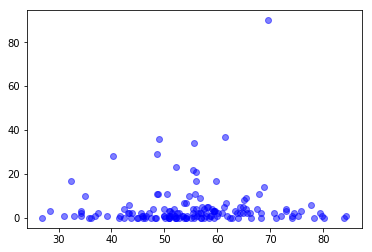

In [31]:
# 计算pearson系数
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

try:
    conn = pymysql.connect(host='127.0.0.1',
                           port=3306,
                           user='root',
                           passwd='',
                           db='dbdemo',
                           charset='utf8',
                           use_unicode=True, )

    cursor = conn.cursor()
#     sql="select citations,features from novelty2 where magazineName='计算机研究与发展'"
    sql="select citations,features from novelty2"
    cursor.execute(sql)
    result = list(cursor.fetchall())
#     c_novelty.append(_novelty[0][0])
#     cited_pearsonr.append(citednum)
#     print("&&&&",_novelty[0][0],citednum)
#             print("****",x[1],x[2],x[3],x[4],_novelty[0][0])
    cursor.close()
except Exception as e:
    print(e)
    conn.rollback()
finally:
    conn.close()
novelty=[]
citation=[]
for x in result:
    citation.append(x[0])
    novelty.append(x[1])
    
c_row, c_value=pearsonr(novelty,citation)
print("****",len(citation),len(novelty))
print("result",c_row,c_value)
plt.scatter(novelty,citation,c='blue',alpha=0.5)
# plt.scatter(c_novelty,cited_pearsonr,c='green',alpha=0.5)

plt.show()
    

In [33]:
import importlib,sys
importlib.reload(sys)
import os
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

# from nlp_rake import rake
print("okk")